# Data


In [ ]:
#===============================================================================
# Packages
!pip install optuna
!pip install pytorch-tabnet
!pip install pytorch-forecasting

#===============================================================================

# Core data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize

# Scikit-learn components
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Hyperparameter optimization
import optuna

# PyTorch and TabNet
import torch
from pytorch_tabnet.tab_model import TabNetRegressor

# PyTorch Forecasting
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss

# Lightning
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping as LightningEarlyStopping, LearningRateMonitor




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dataset_raw.csv to dataset_raw.csv


In [ ]:
#===============================================================================
# Load Dataset
dataset_raw = pd.read_csv('dataset_raw.csv')

In [ ]:
# Dataset Cleaning
dataset_raw["Date"] = pd.to_datetime(dataset_raw["Date"])

# === Add lag for tomorrow and reorder columns
dataset_raw = dataset_raw.sort_values("Date")
dataset_raw["gold_price_lag"] = dataset_raw["gold_price"].shift(-1)

# === Fill na's
columns_ffill = [
    "silver_price", "platinum_price", "oil_price",
    "us10yr", "de10yr", "jp10yr", "uk10yr", "ch10yr",
    "interest_uk", "interest_ecb", "interest_us", "CPI", "unemployment_rate",
    "SP500", "EUROSTOXX50", "Nikkei225", "fed_sentiment", "VIX"
]

dataset_raw[columns_ffill] = dataset_raw[columns_ffill].ffill()

columns_fillna = [
    "positive_future", "negative_future", "neutral_future", "none_future",
    "positive_past", "negative_past", "neutral_past", "none_past"
]

dataset_raw[columns_fillna] = dataset_raw[columns_fillna].fillna(0)

# ===  Calculate features
dataset_raw = dataset_raw.assign(
    gold_price_orginal = dataset_raw["gold_price"],
    gold_price_change = dataset_raw["gold_price"].pct_change(),
    gold_price_change_lag = dataset_raw["gold_price"].pct_change().shift(-1),

    silver_price_change = dataset_raw["silver_price"].pct_change(),
    platinum_price_change = dataset_raw["platinum_price"].pct_change(),
    oil_price_change = dataset_raw["oil_price"].pct_change(),
    CPI_change = dataset_raw["CPI"].pct_change(),
    SP500_change = dataset_raw["SP500"].pct_change(),
    EUROSTOXX50_change = dataset_raw["EUROSTOXX50"].pct_change(),
    Nikkei225_change = dataset_raw["Nikkei225"].pct_change(),

    us10yr_change = dataset_raw["us10yr"].diff(),
    de10yr_change = dataset_raw["de10yr"].diff(),
    jp10yr_change = dataset_raw["jp10yr"].diff(),
    uk10yr_change = dataset_raw["uk10yr"].diff(),
    ch10yr_change = dataset_raw["ch10yr"].diff(),
    interest_uk_change = dataset_raw["interest_uk"].diff(),
    interest_ecb_change = dataset_raw["interest_ecb"].diff(),
    interest_us_change = dataset_raw["interest_us"].diff(),
    unemployment_rate_change = dataset_raw["unemployment_rate"].diff(),
    fed_sentiment_change = dataset_raw["fed_sentiment"].diff(),
    VIX_change = dataset_raw["VIX"].diff()
)

# === Splitting Data
train_data_raw = dataset_raw[(dataset_raw["Date"] > "2001-01-01") & (dataset_raw["Date"] < "2013-07-01")]
val_data_raw   = dataset_raw[(dataset_raw["Date"] > "2013-07-01") & (dataset_raw["Date"] < "2016-04-01")]
test_data_raw  = dataset_raw[(dataset_raw["Date"] > "2016-04-01") & (dataset_raw["Date"] < "2019-01-01")]
train_val_data_raw = dataset_raw[(dataset_raw["Date"] > "2001-01-01") & (dataset_raw["Date"] < "2016-03-01")]

# === NA & Inf checks
def check_integrity(df):
    return df.isna().sum().sum() == 0 and np.isinf(df).sum().sum() == 0

# === No na's or infs
print("no na's or infs")
print(check_integrity(train_data_raw))
print(check_integrity(val_data_raw))
print(check_integrity(test_data_raw))



# ==== Save to df
train_df = train_data_raw
val_df = val_data_raw
test_df = test_data_raw
train_val_df = train_val_data_raw

no na's or infs
True
True
True


In [ ]:
#===============================================================================
# characteristics

# Macro and Finance variables
chars_rel_macro = [
    "gold_price",
    "gold_price_change",
    "silver_price",
    "silver_price_change",
    "platinum_price",
    "platinum_price_change",
    "oil_price",
    "oil_price_change",
    "us10yr",
    "us10yr_change",
    "de10yr",
    "de10yr_change",
    "jp10yr",
    "jp10yr_change",
    "uk10yr",
    "uk10yr_change",
    "ch10yr",
    "ch10yr_change",
    "interest_uk",
    "interest_uk_change",
    "interest_ecb",
    "interest_ecb_change",
    "interest_us",
    "interest_us_change",
    "CPI",
    "CPI_change",
    "unemployment_rate",
    "unemployment_rate_change",
    "SP500",
    "SP500_change",
    "EUROSTOXX50",
    "EUROSTOXX50_change",
    "Nikkei225",
    "Nikkei225_change",
    "VIX",
    "VIX_change"
]

# All relevant characteristics (including sentiment and future/past sentiment variables)
chars_rel_all = [
    "gold_price",
    "gold_price_change",
    "silver_price",
    "silver_price_change",
    "platinum_price",
    "platinum_price_change",
    "oil_price",
    "oil_price_change",
    "us10yr",
    "us10yr_change",
    "de10yr",
    "de10yr_change",
    "jp10yr",
    "jp10yr_change",
    "uk10yr",
    "uk10yr_change",
    "ch10yr",
    "ch10yr_change",
    "interest_uk",
    "interest_uk_change",
    "interest_ecb",
    "interest_ecb_change",
    "interest_us",
    "interest_us_change",
    "CPI",
    "CPI_change",
    "unemployment_rate",
    "unemployment_rate_change",
    "SP500",
    "SP500_change",
    "EUROSTOXX50",
    "EUROSTOXX50_change",
    "Nikkei225",
    "Nikkei225_change",
    "fed_sentiment",
    "fed_sentiment_change",
    "VIX",
    "VIX_change",
    "positive_future",
    "negative_future",
   # "neutral_future",
   # "none_future",
    "positive_past",
    "negative_past",
   # "neutral_past",
   # "none_past"
]

#===============================================================================
# characteristics Smaller

# Macro and Finance variables
chars_rel_macro_no_change = [
    "gold_price",
    "silver_price",
    "platinum_price",
    "oil_price",
    "us10yr",
    "interest_us",
    "CPI",
    "unemployment_rate",
    "SP500",
    "VIX"
]

In [ ]:
#===============================================================================
# Create y and x

# Training data
X_train_all = train_df[chars_rel_all]   # Explanatory variables for training
X_train_macro = train_df[chars_rel_macro]

# Validation data
X_val_all = val_df[chars_rel_all]   # Explanatory variables for validation
X_val_macro = val_df[chars_rel_macro]

# Test data
X_test_all = test_df[chars_rel_all]   # Explanatory variables for testing
X_test_macro = test_df[chars_rel_macro]



#===============================================================================
# y's
y_train = train_df['gold_price_change_lag'].values  # Target variable for training (lagged gold price)
y_val = val_df['gold_price_change_lag'].values  # Target variable for validation (lagged gold price)
y_test = test_df['gold_price_change_lag'].values  # Target variable for testing (lagged gold price)


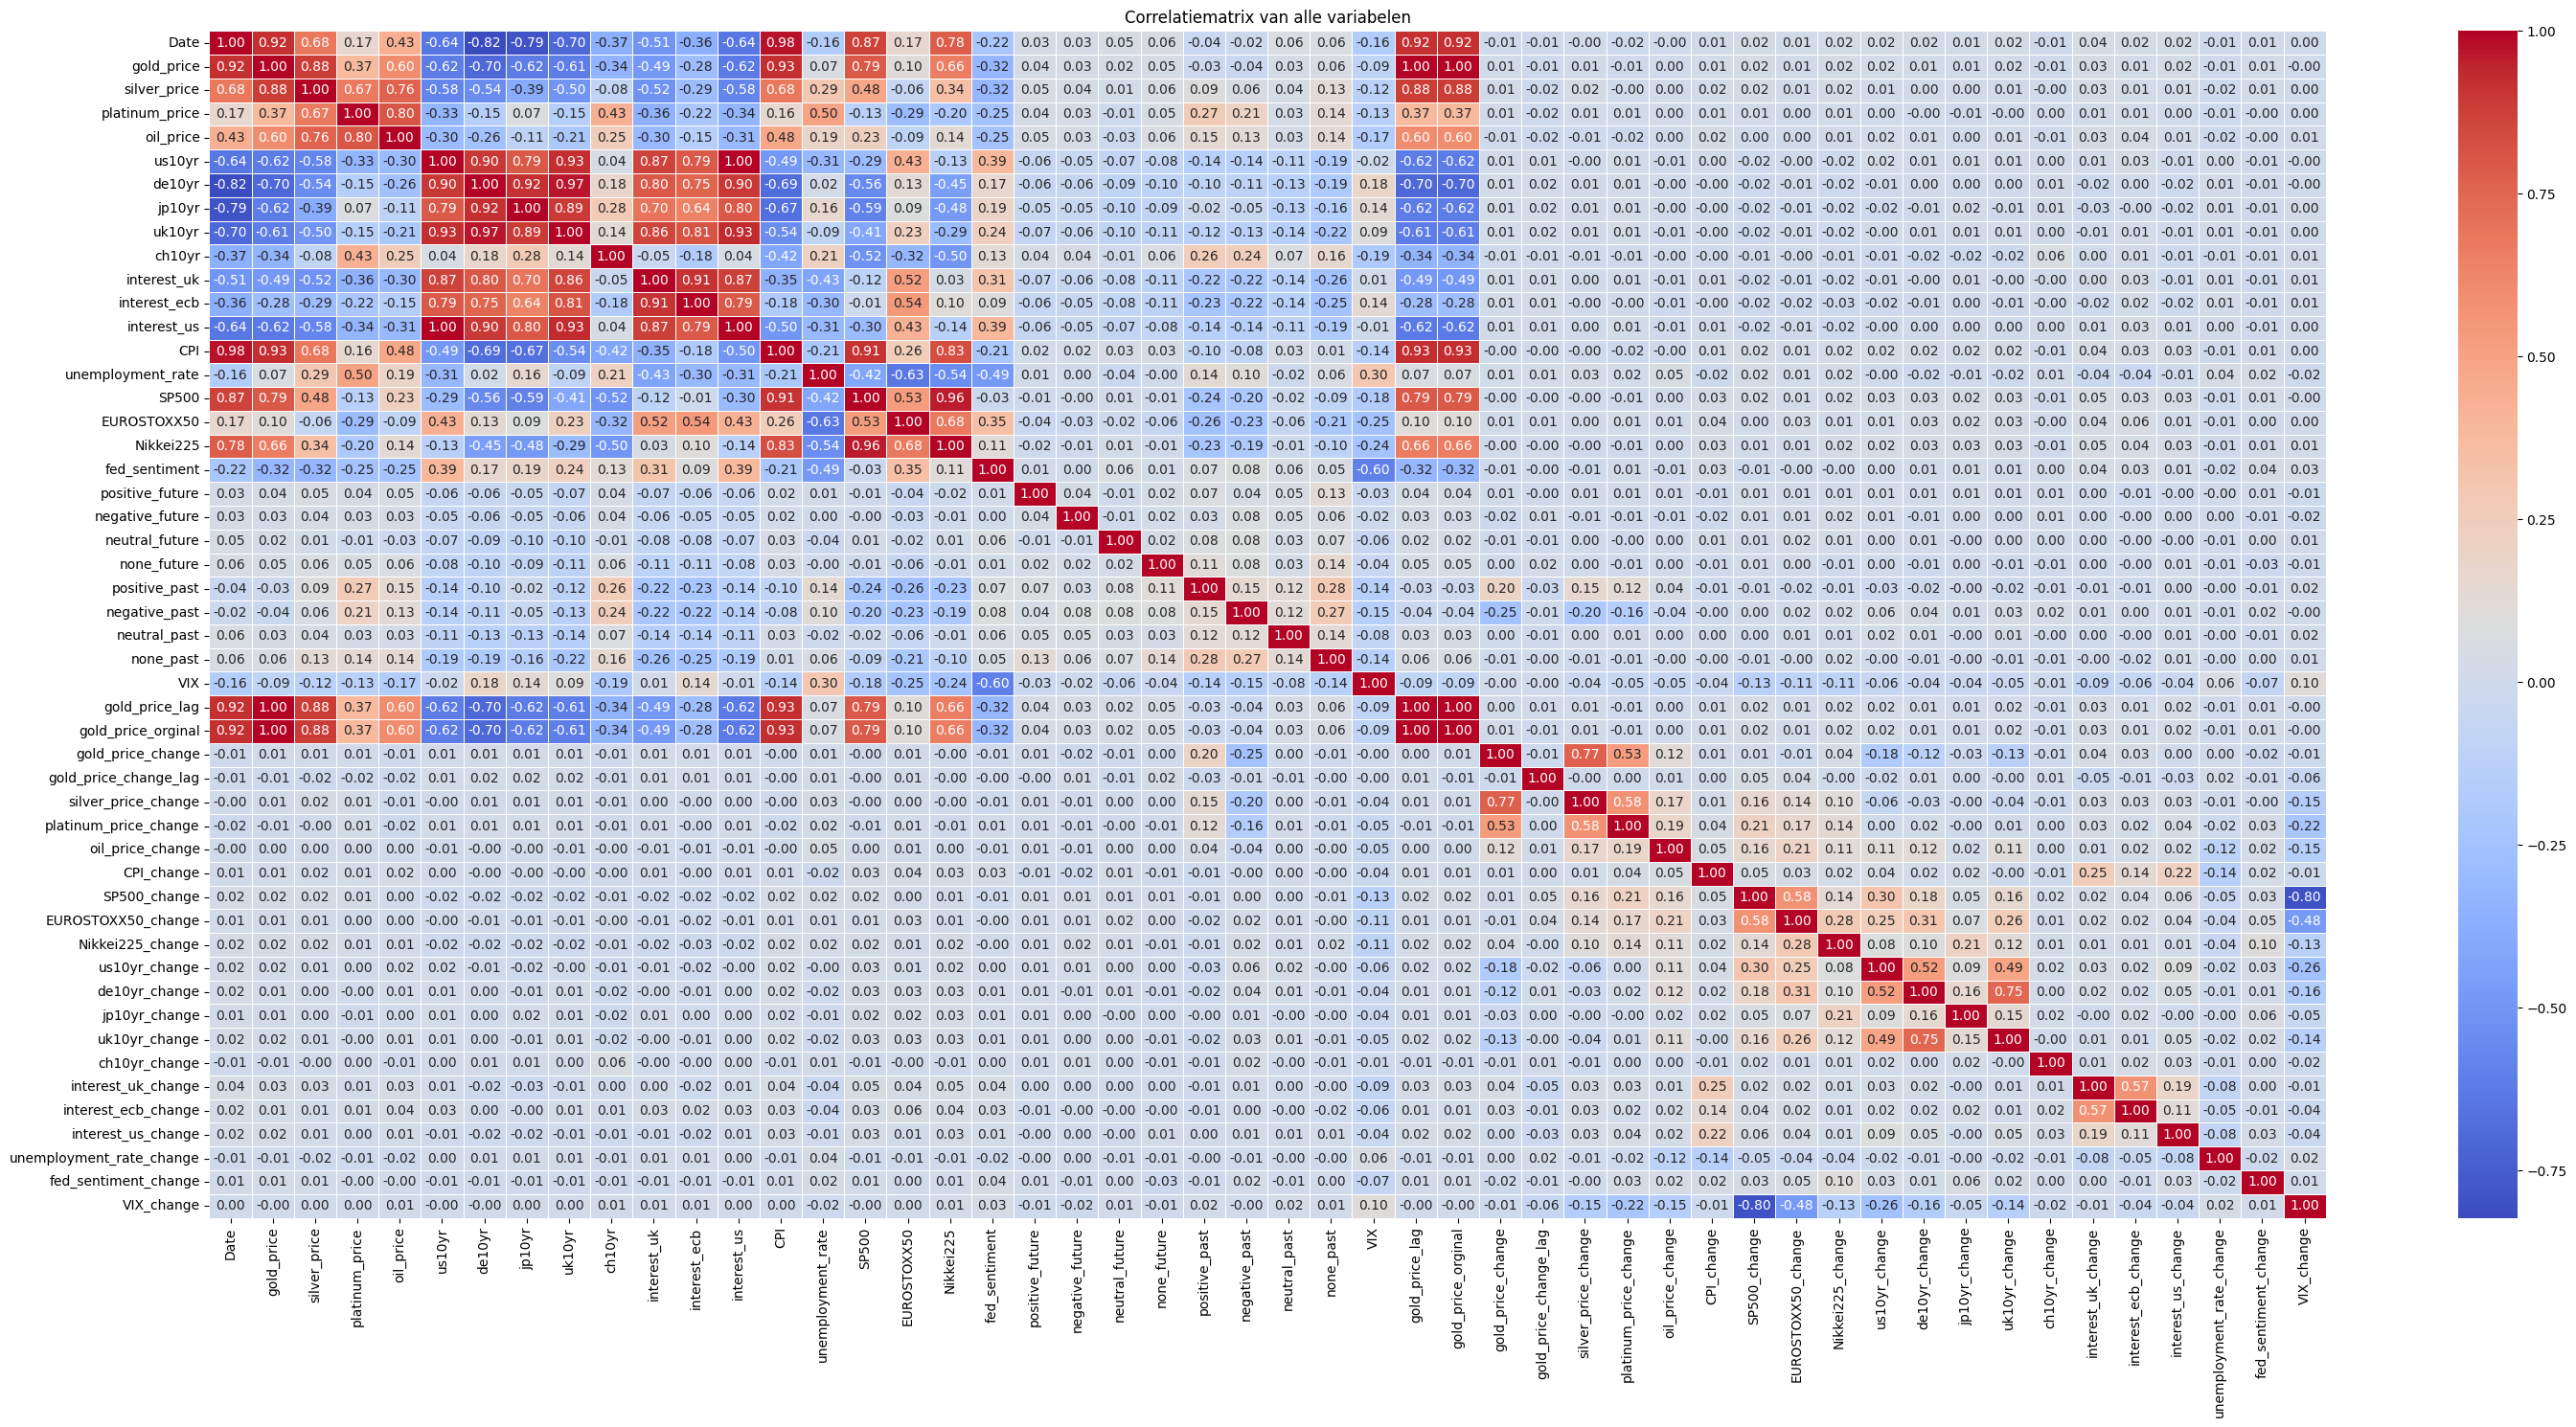

In [ ]:
# Stel je DataFrame heet df en bevat al je features + eventueel gold_price
correlation_matrix = dataset_raw.corr()

# Correlatiematrix als heatmap visualiseren
plt.figure(figsize=(30, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlatiematrix van alle variabelen")
plt.tight_layout()
plt.show()

# SVR Macro


In [ ]:
#===============================================================================
# SVR MACRO (using only macroeconomic features)
#===============================================================================

# Define parameter grid for macro SVR
param_grid_svr_macro = {
    'kernel': ['rbf'], # ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 10, 100, 1000],
    'epsilon': [0.001, 0.01, 0.1, 0.5, 1]
}

# Scale y values for macro SVR
y_scaler_svr_macro = StandardScaler()
y_train_scaled_svr_macro = y_scaler_svr_macro.fit_transform(y_train.reshape(-1, 1)).ravel()
y_val_scaled_svr_macro = y_scaler_svr_macro.transform(y_val.reshape(-1, 1)).ravel()
y_test_scaled_svr_macro = y_scaler_svr_macro.transform(y_test.reshape(-1, 1)).ravel()

# Create empty dataframe to store macro results
results_svr_macro = pd.DataFrame(columns=['kernel', 'C', 'epsilon', 'train_rmse', 'val_rmse'])

print("Training SVR with macro features only...")
# Loop through all combinations for macro
for kernel in param_grid_svr_macro['kernel']:
    print(f"Kernel: {kernel}")
    for C in param_grid_svr_macro['C']:
        print(f"C: {C}")
        for epsilon in param_grid_svr_macro['epsilon']:
            print(f"Epsilon: {epsilon}")
            # Initialize and train model
            svr_macro = SVR(kernel=kernel, C=C, epsilon=epsilon, gamma='scale')
            svr_macro.fit(X_train_macro, y_train_scaled_svr_macro)

            # Predictions
            y_train_pred_scaled_svr_macro = svr_macro.predict(X_train_macro)
            y_val_pred_scaled_svr_macro = svr_macro.predict(X_val_macro)

            # Inverse transform to get original scale
            y_train_pred_svr_macro = y_scaler_svr_macro.inverse_transform(y_train_pred_scaled_svr_macro.reshape(-1, 1)).ravel()
            y_val_pred_svr_macro = y_scaler_svr_macro.inverse_transform(y_val_pred_scaled_svr_macro.reshape(-1, 1)).ravel()

            # Calculate RMSE
            train_rmse_svr_macro = np.sqrt(mean_squared_error(y_train, y_train_pred_svr_macro))
            val_rmse_svr_macro = np.sqrt(mean_squared_error(y_val, y_val_pred_svr_macro))

            # Store results
            results_svr_macro = pd.concat([results_svr_macro, pd.DataFrame({
                'kernel': [kernel],
                'C': [C],
                'epsilon': [epsilon],
                'train_rmse': [train_rmse_svr_macro],
                'val_rmse': [val_rmse_svr_macro]
            })], ignore_index=True)

            # Print progress
            print(f"Kernel: {kernel}, C: {C}, epsilon: {epsilon}, Train RMSE: {train_rmse_svr_macro:.4f}, Val RMSE: {val_rmse_svr_macro:.4f}")

# Find best model for macro
best_idx_svr_macro = results_svr_macro['val_rmse'].idxmin()
best_params_svr_macro = results_svr_macro.loc[best_idx_svr_macro, ['kernel', 'C', 'epsilon']]
print("\nBest parameters for macro SVR:")
print(f"Kernel: {best_params_svr_macro['kernel']}")
print(f"C: {best_params_svr_macro['C']}")
print(f"Epsilon: {best_params_svr_macro['epsilon']}")
print(f"Validation RMSE: {results_svr_macro.loc[best_idx_svr_macro, 'val_rmse']:.4f}")

# Test best model on test set for macro
best_svr_macro = SVR(
    kernel=best_params_svr_macro['kernel'],
    C=best_params_svr_macro['C'],
    epsilon=best_params_svr_macro['epsilon'],
    gamma='scale'
)
best_svr_macro.fit(X_train_macro, y_train_scaled_svr_macro)
y_test_pred_scaled_svr_macro = best_svr_macro.predict(X_test_macro)
y_test_pred_svr_macro = y_scaler_svr_macro.inverse_transform(y_test_pred_scaled_svr_macro.reshape(-1, 1)).ravel()
test_rmse_svr_macro = np.sqrt(mean_squared_error(y_test, y_test_pred_svr_macro))
print(f"Test RMSE with best parameters for macro SVR: {test_rmse_svr_macro:.4f}")

#===============================================================================
# SVR ALL (using all features including sentiment data)
#===============================================================================

# Define parameter grid for all features SVR
param_grid_svr_all = {
    'kernel': ['rbf'], # ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 10, 100, 1000],
    'epsilon': [0.001, 0.01, 0.1, 0.5, 1]
}

# Scale y values for all features SVR
y_scaler_svr_all = StandardScaler()
y_train_scaled_svr_all = y_scaler_svr_all.fit_transform(y_train.reshape(-1, 1)).ravel()
y_val_scaled_svr_all = y_scaler_svr_all.transform(y_val.reshape(-1, 1)).ravel()
y_test_scaled_svr_all = y_scaler_svr_all.transform(y_test.reshape(-1, 1)).ravel()

# Create empty dataframe to store all features results
results_svr_all = pd.DataFrame(columns=['kernel', 'C', 'epsilon', 'train_rmse', 'val_rmse'])

print("\nTraining SVR with all features (including sentiment)...")
# Loop through all combinations for all features
for kernel in param_grid_svr_all['kernel']:
    print(f"Kernel: {kernel}")
    for C in param_grid_svr_all['C']:
        print(f"C: {C}")
        for epsilon in param_grid_svr_all['epsilon']:
            print(f"Epsilon: {epsilon}")
            # Initialize and train model
            svr_all = SVR(kernel=kernel, C=C, epsilon=epsilon, gamma='scale')
            svr_all.fit(X_train_all, y_train_scaled_svr_all)

            # Predictions
            y_train_pred_scaled_svr_all = svr_all.predict(X_train_all)
            y_val_pred_scaled_svr_all = svr_all.predict(X_val_all)

            # Inverse transform to get original scale
            y_train_pred_svr_all = y_scaler_svr_all.inverse_transform(y_train_pred_scaled_svr_all.reshape(-1, 1)).ravel()
            y_val_pred_svr_all = y_scaler_svr_all.inverse_transform(y_val_pred_scaled_svr_all.reshape(-1, 1)).ravel()

            # Calculate RMSE
            train_rmse_svr_all = np.sqrt(mean_squared_error(y_train, y_train_pred_svr_all))
            val_rmse_svr_all = np.sqrt(mean_squared_error(y_val, y_val_pred_svr_all))

            # Store results
            results_svr_all = pd.concat([results_svr_all, pd.DataFrame({
                'kernel': [kernel],
                'C': [C],
                'epsilon': [epsilon],
                'train_rmse': [train_rmse_svr_all],
                'val_rmse': [val_rmse_svr_all]
            })], ignore_index=True)

            # Print progress
            print(f"Kernel: {kernel}, C: {C}, epsilon: {epsilon}, Train RMSE: {train_rmse_svr_all:.4f}, Val RMSE: {val_rmse_svr_all:.4f}")

# Find best model for all features
best_idx_svr_all = results_svr_all['val_rmse'].idxmin()
best_params_svr_all = results_svr_all.loc[best_idx_svr_all, ['kernel', 'C', 'epsilon']]
print("\nBest parameters for all features SVR:")
print(f"Kernel: {best_params_svr_all['kernel']}")
print(f"C: {best_params_svr_all['C']}")
print(f"Epsilon: {best_params_svr_all['epsilon']}")
print(f"Validation RMSE: {results_svr_all.loc[best_idx_svr_all, 'val_rmse']:.4f}")

# Test best model on test set for all features
best_svr_all = SVR(
    kernel=best_params_svr_all['kernel'],
    C=best_params_svr_all['C'],
    epsilon=best_params_svr_all['epsilon'],
    gamma='scale'
)
best_svr_all.fit(X_train_all, y_train_scaled_svr_all)
y_test_pred_scaled_svr_all = best_svr_all.predict(X_test_all)
y_test_pred_svr_all = y_scaler_svr_all.inverse_transform(y_test_pred_scaled_svr_all.reshape(-1, 1)).ravel()
test_rmse_svr_all = np.sqrt(mean_squared_error(y_test, y_test_pred_svr_all))
print(f"Test RMSE with best parameters for all features SVR: {test_rmse_svr_all:.4f}")

# Compare macro vs all features performance
print("\nPerformance Comparison:")
print(f"SVR Macro Test RMSE: {test_rmse_svr_macro:.4f}")
print(f"SVR All Features Test RMSE: {test_rmse_svr_all:.4f}")
print(f"Improvement with sentiment features: {(test_rmse_svr_macro - test_rmse_svr_all) / test_rmse_svr_macro * 100:.2f}%")

Training SVR with macro features only...
Kernel: rbf
C: 0.1
Epsilon: 0.001


<ipython-input-8-bba3223bc187>:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_svr_macro = pd.concat([results_svr_macro, pd.DataFrame({


Kernel: rbf, C: 0.1, epsilon: 0.001, Train RMSE: 0.0118, Val RMSE: 0.0099
Epsilon: 0.01
Kernel: rbf, C: 0.1, epsilon: 0.01, Train RMSE: 0.0118, Val RMSE: 0.0099
Epsilon: 0.1
Kernel: rbf, C: 0.1, epsilon: 0.1, Train RMSE: 0.0118, Val RMSE: 0.0099
Epsilon: 0.5
Kernel: rbf, C: 0.1, epsilon: 0.5, Train RMSE: 0.0118, Val RMSE: 0.0099
Epsilon: 1
Kernel: rbf, C: 0.1, epsilon: 1, Train RMSE: 0.0118, Val RMSE: 0.0098
C: 1
Epsilon: 0.001
Kernel: rbf, C: 1, epsilon: 0.001, Train RMSE: 0.0118, Val RMSE: 0.0099
Epsilon: 0.01
Kernel: rbf, C: 1, epsilon: 0.01, Train RMSE: 0.0118, Val RMSE: 0.0099
Epsilon: 0.1
Kernel: rbf, C: 1, epsilon: 0.1, Train RMSE: 0.0117, Val RMSE: 0.0099
Epsilon: 0.5
Kernel: rbf, C: 1, epsilon: 0.5, Train RMSE: 0.0118, Val RMSE: 0.0099
Epsilon: 1
Kernel: rbf, C: 1, epsilon: 1, Train RMSE: 0.0117, Val RMSE: 0.0098
C: 10
Epsilon: 0.001
Kernel: rbf, C: 10, epsilon: 0.001, Train RMSE: 0.0117, Val RMSE: 0.0098
Epsilon: 0.01
Kernel: rbf, C: 10, epsilon: 0.01, Train RMSE: 0.0117, Val

<ipython-input-8-bba3223bc187>:124: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_svr_all = pd.concat([results_svr_all, pd.DataFrame({


Kernel: rbf, C: 0.1, epsilon: 0.001, Train RMSE: 0.0118, Val RMSE: 0.0099
Epsilon: 0.01
Kernel: rbf, C: 0.1, epsilon: 0.01, Train RMSE: 0.0118, Val RMSE: 0.0099
Epsilon: 0.1
Kernel: rbf, C: 0.1, epsilon: 0.1, Train RMSE: 0.0118, Val RMSE: 0.0099
Epsilon: 0.5
Kernel: rbf, C: 0.1, epsilon: 0.5, Train RMSE: 0.0118, Val RMSE: 0.0099
Epsilon: 1
Kernel: rbf, C: 0.1, epsilon: 1, Train RMSE: 0.0118, Val RMSE: 0.0098
C: 1
Epsilon: 0.001
Kernel: rbf, C: 1, epsilon: 0.001, Train RMSE: 0.0118, Val RMSE: 0.0099
Epsilon: 0.01
Kernel: rbf, C: 1, epsilon: 0.01, Train RMSE: 0.0118, Val RMSE: 0.0099
Epsilon: 0.1
Kernel: rbf, C: 1, epsilon: 0.1, Train RMSE: 0.0117, Val RMSE: 0.0099
Epsilon: 0.5
Kernel: rbf, C: 1, epsilon: 0.5, Train RMSE: 0.0118, Val RMSE: 0.0099
Epsilon: 1
Kernel: rbf, C: 1, epsilon: 1, Train RMSE: 0.0117, Val RMSE: 0.0098
C: 10
Epsilon: 0.001
Kernel: rbf, C: 10, epsilon: 0.001, Train RMSE: 0.0117, Val RMSE: 0.0098
Epsilon: 0.01
Kernel: rbf, C: 10, epsilon: 0.01, Train RMSE: 0.0117, Val

In [ ]:
#===============================================================================
# SVR MACRO: Predictions and Evaluation
#===============================================================================

# Predictions (scaled) and inverse transform
y_test_pred_scaled_svr_macro = best_svr_macro.predict(X_test_macro)
y_test_pred_svr_macro = y_scaler_svr_macro.inverse_transform(y_test_pred_scaled_svr_macro.reshape(-1, 1)).ravel()

y_train_pred_scaled_svr_macro = best_svr_macro.predict(X_train_macro)
y_train_pred_svr_macro = y_scaler_svr_macro.inverse_transform(y_train_pred_scaled_svr_macro.reshape(-1, 1)).ravel()

y_val_pred_scaled_svr_macro = best_svr_macro.predict(X_val_macro)
y_val_pred_svr_macro = y_scaler_svr_macro.inverse_transform(y_val_pred_scaled_svr_macro.reshape(-1, 1)).ravel()

# Combine train and val predictions for combined metrics
y_train_val = np.concatenate([y_train, y_val])
y_pred_train_val_svr_macro = np.concatenate([y_train_pred_svr_macro, y_val_pred_svr_macro])
y_pred_test_svr_macro = y_test_pred_svr_macro

# MSE for macro model
mse_train_svr_macro_ret = mean_squared_error(y_train, y_train_pred_svr_macro)
mse_val_svr_macro_ret = mean_squared_error(y_val, y_val_pred_svr_macro)
mse_train_val_svr_macro_ret = mean_squared_error(y_train_val, y_pred_train_val_svr_macro)
mse_test_svr_macro_ret = mean_squared_error(y_test, y_pred_test_svr_macro)

# MAE for macro model
mae_train_svr_macro_ret = mean_absolute_error(y_train, y_train_pred_svr_macro)
mae_val_svr_macro_ret = mean_absolute_error(y_val, y_val_pred_svr_macro)
mae_train_val_svr_macro_ret = mean_absolute_error(y_train_val, y_pred_train_val_svr_macro)
mae_test_svr_macro_ret = mean_absolute_error(y_test, y_pred_test_svr_macro)

# R² for macro model
r2_train_svr_macro_ret = r2_score(y_train, y_train_pred_svr_macro)
r2_val_svr_macro_ret = r2_score(y_val, y_val_pred_svr_macro)
r2_train_val_svr_macro_ret = r2_score(y_train_val, y_pred_train_val_svr_macro)
r2_test_svr_macro_ret = r2_score(y_test, y_pred_test_svr_macro)

# Store results for macro model
results_svr_macro_ret = pd.DataFrame({
    'Metric': ['MSE', 'MAE', 'R2'],
    'Train': [mse_train_svr_macro_ret, mae_train_svr_macro_ret, r2_train_svr_macro_ret],
    'Val': [mse_val_svr_macro_ret, mae_val_svr_macro_ret, r2_val_svr_macro_ret],
    'Train+Val': [mse_train_val_svr_macro_ret, mae_train_val_svr_macro_ret, r2_train_val_svr_macro_ret],
    'Test': [mse_test_svr_macro_ret, mae_test_svr_macro_ret, r2_test_svr_macro_ret]
})

print("SVR Macro Return Metrics:")
print(results_svr_macro_ret)

# Results on original gold price scale for macro model
gold_price_prediction_svr_macro_train = ((y_train_pred_svr_macro + 1) * train_df['gold_price']).values
gold_price_prediction_svr_macro_val = ((y_val_pred_svr_macro + 1) * val_df['gold_price']).values
gold_price_prediction_svr_macro_test = ((y_pred_test_svr_macro + 1) * test_df['gold_price']).values

# MSE on gold price for macro model
mse_train_svr_macro_gold_abs = mean_squared_error(train_df['gold_price'], gold_price_prediction_svr_macro_train)
mse_val_svr_macro_gold_abs = mean_squared_error(val_df['gold_price'], gold_price_prediction_svr_macro_val)
mse_test_svr_macro_gold_abs = mean_squared_error(test_df['gold_price'], gold_price_prediction_svr_macro_test)

# MAE on gold price for macro model
mae_train_svr_macro_gold_abs = mean_absolute_error(train_df['gold_price'], gold_price_prediction_svr_macro_train)
mae_val_svr_macro_gold_abs = mean_absolute_error(val_df['gold_price'], gold_price_prediction_svr_macro_val)
mae_test_svr_macro_gold_abs = mean_absolute_error(test_df['gold_price'], gold_price_prediction_svr_macro_test)

# R² on gold price for macro model
r2_train_svr_macro_gold_abs = r2_score(train_df['gold_price'], gold_price_prediction_svr_macro_train)
r2_val_svr_macro_gold_abs = r2_score(val_df['gold_price'], gold_price_prediction_svr_macro_val)
r2_test_svr_macro_gold_abs = r2_score(test_df['gold_price'], gold_price_prediction_svr_macro_test)

# Store gold price results for macro model
results_svr_macro_gold_price_abs = pd.DataFrame({
    'Metric': ['MSE', 'MAE', 'R2'],
    'Train': [mse_train_svr_macro_gold_abs, mae_train_svr_macro_gold_abs, r2_train_svr_macro_gold_abs],
    'Val': [mse_val_svr_macro_gold_abs, mae_val_svr_macro_gold_abs, r2_val_svr_macro_gold_abs],
    'Test': [mse_test_svr_macro_gold_abs, mae_test_svr_macro_gold_abs, r2_test_svr_macro_gold_abs]
})

print("\nSVR Macro Gold Price Metrics:")
print(results_svr_macro_gold_price_abs)

#===============================================================================
# SVR ALL (with sentiment): Predictions and Evaluation
#===============================================================================

# Predictions (scaled) and inverse transform for all features model
y_test_pred_scaled_svr_all = best_svr_all.predict(X_test_all)
y_test_pred_svr_all = y_scaler_svr_all.inverse_transform(y_test_pred_scaled_svr_all.reshape(-1, 1)).ravel()

y_train_pred_scaled_svr_all = best_svr_all.predict(X_train_all)
y_train_pred_svr_all = y_scaler_svr_all.inverse_transform(y_train_pred_scaled_svr_all.reshape(-1, 1)).ravel()

y_val_pred_scaled_svr_all = best_svr_all.predict(X_val_all)
y_val_pred_svr_all = y_scaler_svr_all.inverse_transform(y_val_pred_scaled_svr_all.reshape(-1, 1)).ravel()

# Combine train and val predictions for combined metrics
y_pred_train_val_svr_all = np.concatenate([y_train_pred_svr_all, y_val_pred_svr_all])
y_pred_test_svr_all = y_test_pred_svr_all

# MSE for all features model
mse_train_svr_all_ret = mean_squared_error(y_train, y_train_pred_svr_all)
mse_val_svr_all_ret = mean_squared_error(y_val, y_val_pred_svr_all)
mse_train_val_svr_all_ret = mean_squared_error(y_train_val, y_pred_train_val_svr_all)
mse_test_svr_all_ret = mean_squared_error(y_test, y_pred_test_svr_all)

# MAE for all features model
mae_train_svr_all_ret = mean_absolute_error(y_train, y_train_pred_svr_all)
mae_val_svr_all_ret = mean_absolute_error(y_val, y_val_pred_svr_all)
mae_train_val_svr_all_ret = mean_absolute_error(y_train_val, y_pred_train_val_svr_all)
mae_test_svr_all_ret = mean_absolute_error(y_test, y_pred_test_svr_all)

# R² for all features model
r2_train_svr_all_ret = r2_score(y_train, y_train_pred_svr_all)
r2_val_svr_all_ret = r2_score(y_val, y_val_pred_svr_all)
r2_train_val_svr_all_ret = r2_score(y_train_val, y_pred_train_val_svr_all)
r2_test_svr_all_ret = r2_score(y_test, y_pred_test_svr_all)

# Store results for all features model
results_svr_all_ret = pd.DataFrame({
    'Metric': ['MSE', 'MAE', 'R2'],
    'Train': [mse_train_svr_all_ret, mae_train_svr_all_ret, r2_train_svr_all_ret],
    'Val': [mse_val_svr_all_ret, mae_val_svr_all_ret, r2_val_svr_all_ret],
    'Train+Val': [mse_train_val_svr_all_ret, mae_train_val_svr_all_ret, r2_train_val_svr_all_ret],
    'Test': [mse_test_svr_all_ret, mae_test_svr_all_ret, r2_test_svr_all_ret]
})

print("\nSVR All Features Return Metrics:")
print(results_svr_all_ret)

# Results on original gold price scale for all features model
gold_price_prediction_svr_all_train = ((y_train_pred_svr_all + 1) * train_df['gold_price']).values
gold_price_prediction_svr_all_val = ((y_val_pred_svr_all + 1) * val_df['gold_price']).values
gold_price_prediction_svr_all_test = ((y_pred_test_svr_all + 1) * test_df['gold_price']).values

# MSE on gold price for all features model
mse_train_svr_all_gold_abs = mean_squared_error(train_df['gold_price'], gold_price_prediction_svr_all_train)
mse_val_svr_all_gold_abs = mean_squared_error(val_df['gold_price'], gold_price_prediction_svr_all_val)
mse_test_svr_all_gold_abs = mean_squared_error(test_df['gold_price'], gold_price_prediction_svr_all_test)

# MAE on gold price for all features model
mae_train_svr_all_gold_abs = mean_absolute_error(train_df['gold_price'], gold_price_prediction_svr_all_train)
mae_val_svr_all_gold_abs = mean_absolute_error(val_df['gold_price'], gold_price_prediction_svr_all_val)
mae_test_svr_all_gold_abs = mean_absolute_error(test_df['gold_price'], gold_price_prediction_svr_all_test)

# R² on gold price for all features model
r2_train_svr_all_gold_abs = r2_score(train_df['gold_price'], gold_price_prediction_svr_all_train)
r2_val_svr_all_gold_abs = r2_score(val_df['gold_price'], gold_price_prediction_svr_all_val)
r2_test_svr_all_gold_abs = r2_score(test_df['gold_price'], gold_price_prediction_svr_all_test)

# Store gold price results for all features model
results_svr_all_gold_price_abs = pd.DataFrame({
    'Metric': ['MSE', 'MAE', 'R2'],
    'Train': [mse_train_svr_all_gold_abs, mae_train_svr_all_gold_abs, r2_train_svr_all_gold_abs],
    'Val': [mse_val_svr_all_gold_abs, mae_val_svr_all_gold_abs, r2_val_svr_all_gold_abs],
    'Test': [mse_test_svr_all_gold_abs, mae_test_svr_all_gold_abs, r2_test_svr_all_gold_abs]
})

print("\nSVR All Features Gold Price Metrics:")
print(results_svr_all_gold_price_abs)

#===============================================================================
# Model Comparison
#===============================================================================

# Compare return prediction performance
comparison_svr_ret = pd.DataFrame({
    'Metric': ['R2', 'MSE', 'MAE'],
    'SVR Macro (Train)': [r2_train_svr_macro_ret, mse_train_svr_macro_ret, mae_train_svr_macro_ret],
    'SVR All (Train)': [r2_train_svr_all_ret, mse_train_svr_all_ret, mae_train_svr_all_ret],
    'SVR Macro (Test)': [r2_test_svr_macro_ret, mse_test_svr_macro_ret, mae_test_svr_macro_ret],
    'SVR All (Test)': [r2_test_svr_all_ret, mse_test_svr_all_ret, mae_test_svr_all_ret]
})

print("\nComparison of Return Prediction Performance:")
print(comparison_svr_ret)

# Compare gold price prediction performance
comparison_svr_gold = pd.DataFrame({
    'Metric': ['R2', 'MSE', 'MAE'],
    'SVR Macro (Train)': [r2_train_svr_macro_gold_abs, mse_train_svr_macro_gold_abs, mae_train_svr_macro_gold_abs],
    'SVR All (Train)': [r2_train_svr_all_gold_abs, mse_train_svr_all_gold_abs, mae_train_svr_all_gold_abs],
    'SVR Macro (Test)': [r2_test_svr_macro_gold_abs, mse_test_svr_macro_gold_abs, mae_test_svr_macro_gold_abs],
    'SVR All (Test)': [r2_test_svr_all_gold_abs, mse_test_svr_all_gold_abs, mae_test_svr_all_gold_abs]
})

print("\nComparison of Gold Price Prediction Performance:")
print(comparison_svr_gold)

# Calculate improvement percentage
mse_improvement_svr_ret = ((mse_test_svr_macro_ret - mse_test_svr_all_ret) / mse_test_svr_macro_ret) * 100
mae_improvement_svr_ret = ((mae_test_svr_macro_ret - mae_test_svr_all_ret) / mae_test_svr_macro_ret) * 100
r2_improvement_svr_ret = ((r2_test_svr_all_ret - r2_test_svr_macro_ret) / abs(r2_test_svr_macro_ret)) * 100 if r2_test_svr_macro_ret != 0 else float('inf')

print("\nImprovement with Sentiment Features:")
print(f"R² Improvement: {r2_improvement_svr_ret:.2f}%")
print(f"MSE Improvement: {mse_improvement_svr_ret:.2f}%")
print(f"MAE Improvement: {mae_improvement_svr_ret:.2f}%")

SVR Macro Return Metrics:
  Metric     Train       Val  Train+Val      Test
0    MSE  0.000138  0.000096   0.000130  0.000051
1    MAE  0.008309  0.007247   0.008117  0.005297
2     R2  0.002413  0.000367   0.002442 -0.008730

SVR Macro Gold Price Metrics:
  Metric     Train       Val      Test
0    MSE  0.584924  0.524533  1.146016
1    MAE  0.628431  0.648885  0.782065
2     R2  0.999997  0.999919  0.999551

SVR All Features Return Metrics:
  Metric     Train       Val  Train+Val      Test
0    MSE  0.000138  0.000096   0.000130  0.000051
1    MAE  0.008309  0.007248   0.008118  0.005289
2     R2  0.002388  0.000147   0.002391 -0.006974

SVR All Features Gold Price Metrics:
  Metric     Train       Val      Test
0    MSE  0.585457  0.544998  1.003143
1    MAE  0.628274  0.662690  0.738945
2     R2  0.999997  0.999916  0.999607

Comparison of Return Prediction Performance:
  Metric  SVR Macro (Train)  SVR All (Train)  SVR Macro (Test)  SVR All (Test)
0     R2           0.002413       


===== SVR Macro Portfolio Evaluation =====
Final Portfolio Return: 0.2277 (22.77%)
Final Gold Return: 0.0414 (4.14%)
Outperformance: 18.63%

SVR Macro Trading Statistics:
Correct:
 correct_svr_macro
1    364
0    338
Name: count, dtype: int64 

Up:
 up
1    364
0    338
Name: count, dtype: int64 

Going Long:
 going_long_svr_macro
0    508
1    194
Name: count, dtype: int64 


===== SVR All Features Portfolio Evaluation =====
Final Portfolio Return: 0.1744 (17.44%)
Final Gold Return: 0.0414 (4.14%)
Outperformance: 13.29%

SVR All Features Trading Statistics:
Correct:
 correct_svr_all
1    355
0    347
Name: count, dtype: int64 

Up:
 up
1    364
0    338
Name: count, dtype: int64 

Going Long:
 going_long_svr_all
0    497
1    205
Name: count, dtype: int64 



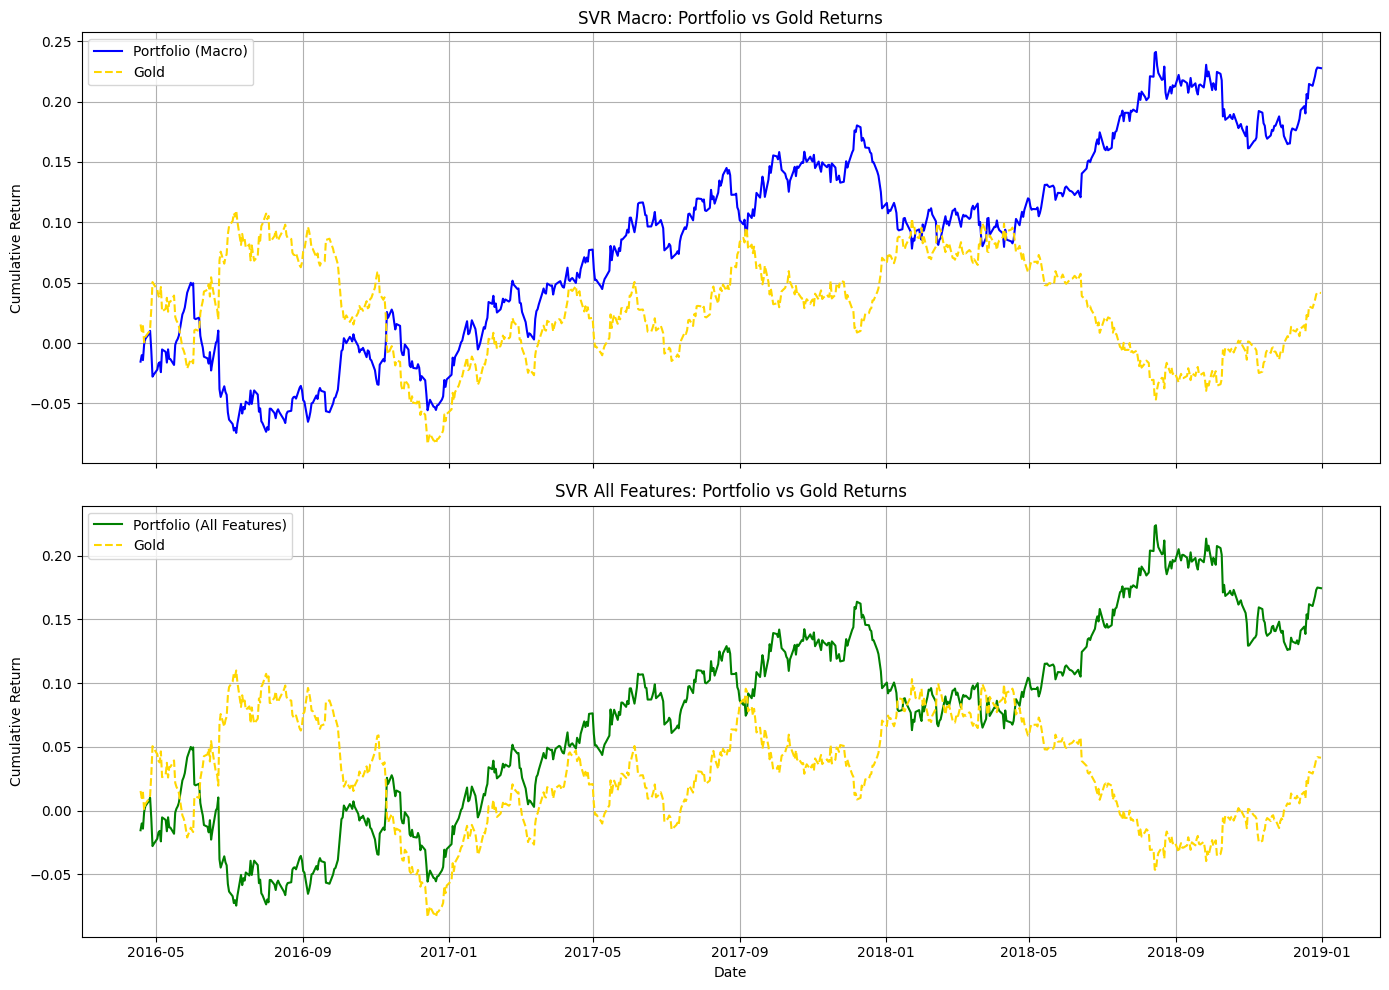

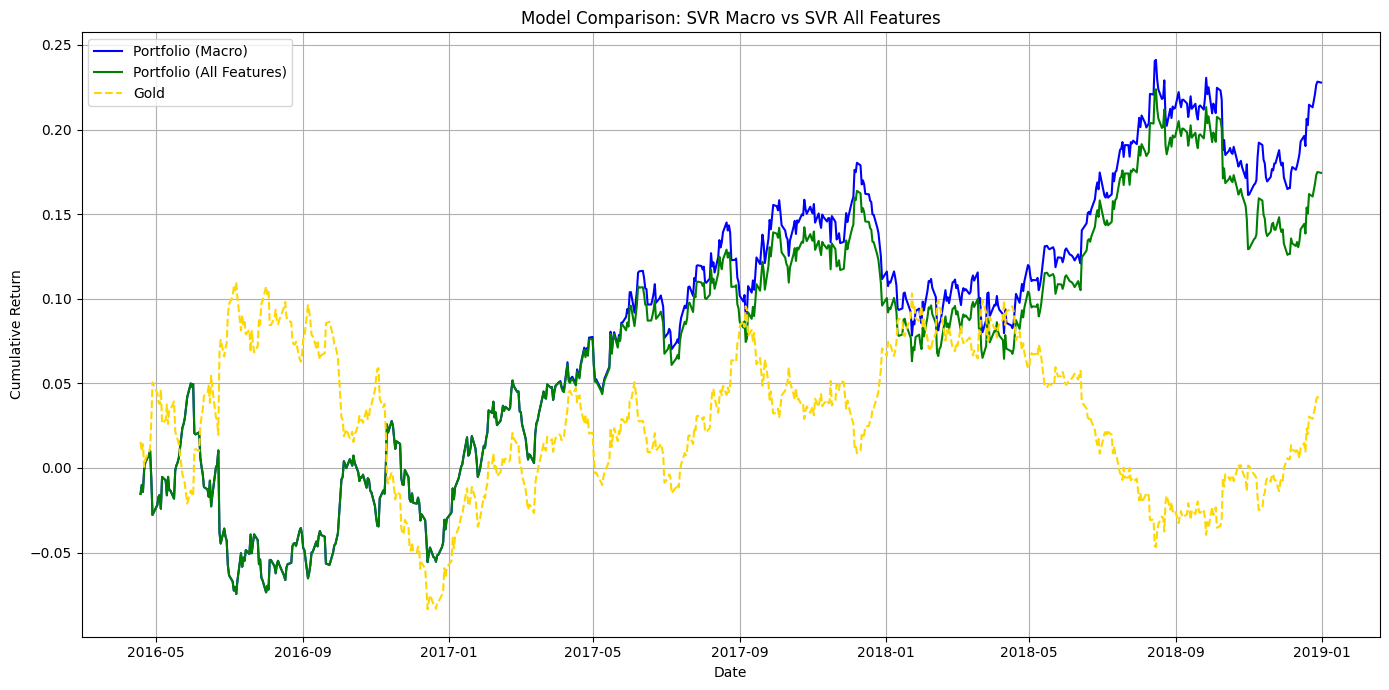

In [ ]:
#===============================================================================
# Portfolio Construction and Evaluation - SVR Macro
#===============================================================================

start = 10

# Construct portfolio based on SVR Macro model, starting from row 10
gold_prices_svr_macro = pd.DataFrame({
    'Date': test_df['Date'].iloc[start:],
    'gold_price_orginal': test_df['gold_price_orginal'].iloc[start:],
    'gold_price_lag': test_df['gold_price_lag'].iloc[start:],
    'gold_price_prediction_svr_macro': gold_price_prediction_svr_macro_test[start:]
})

# Reset index after slicing
gold_prices_svr_macro = gold_prices_svr_macro.reset_index(drop=True)

gold_prices_svr_macro['going_long_svr_macro'] = np.where(gold_prices_svr_macro['gold_price_prediction_svr_macro'] > 1 * gold_prices_svr_macro['gold_price_orginal'], 1, 0)
gold_prices_svr_macro['up'] = np.where(gold_prices_svr_macro['gold_price_lag'] > 1 * gold_prices_svr_macro['gold_price_orginal'], 1, 0)
gold_prices_svr_macro['correct_svr_macro'] = np.where(gold_prices_svr_macro['going_long_svr_macro'] == gold_prices_svr_macro['up'], 1, 0)
gold_prices_svr_macro['percentages_svr_macro'] = (gold_prices_svr_macro['gold_price_lag'] - gold_prices_svr_macro['gold_price_orginal']) / gold_prices_svr_macro['gold_price_orginal']
gold_prices_svr_macro['absolute_percentage_svr_macro'] = abs(gold_prices_svr_macro['percentages_svr_macro'])
gold_prices_svr_macro['portfolio_percentage_svr_macro'] = np.where(gold_prices_svr_macro['correct_svr_macro'] == 1, gold_prices_svr_macro['absolute_percentage_svr_macro'], -gold_prices_svr_macro['absolute_percentage_svr_macro'])
gold_prices_svr_macro['cum_return_portfolio_svr_macro'] = (1 + gold_prices_svr_macro['portfolio_percentage_svr_macro']).cumprod() - 1
gold_prices_svr_macro['cum_return_gold_svr_macro'] = (1 + gold_prices_svr_macro['percentages_svr_macro']).cumprod() - 1

# Calculate final returns for SVR Macro
final_portfolio_return_svr_macro = gold_prices_svr_macro['cum_return_portfolio_svr_macro'].iloc[-1]
final_gold_return_svr_macro = gold_prices_svr_macro['cum_return_gold_svr_macro'].iloc[-1]

print("\n===== SVR Macro Portfolio Evaluation =====")
print(f"Final Portfolio Return: {final_portfolio_return_svr_macro:.4f} ({final_portfolio_return_svr_macro*100:.2f}%)")
print(f"Final Gold Return: {final_gold_return_svr_macro:.4f} ({final_gold_return_svr_macro*100:.2f}%)")
print(f"Outperformance: {(final_portfolio_return_svr_macro - final_gold_return_svr_macro)*100:.2f}%")

# Print statistics for SVR Macro
print("\nSVR Macro Trading Statistics:")
series = pd.Series(gold_prices_svr_macro['correct_svr_macro'])
print("Correct:\n", series.value_counts(), "\n")

series = pd.Series(gold_prices_svr_macro['up'])
print("Up:\n", series.value_counts(), "\n")

series = pd.Series(gold_prices_svr_macro['going_long_svr_macro'])
print("Going Long:\n", series.value_counts(), "\n")

#===============================================================================
# Portfolio Construction and Evaluation - SVR All Features
#===============================================================================

# Construct portfolio based on SVR All Features model, starting from row 10
gold_prices_svr_all = pd.DataFrame({
    'Date': test_df['Date'].iloc[start:],
    'gold_price_orginal': test_df['gold_price_orginal'].iloc[start:],
    'gold_price_lag': test_df['gold_price_lag'].iloc[start:],
    'gold_price_prediction_svr_all': gold_price_prediction_svr_all_test[start:]
})

# Reset index after slicing
gold_prices_svr_all = gold_prices_svr_all.reset_index(drop=True)

gold_prices_svr_all['going_long_svr_all'] = np.where(gold_prices_svr_all['gold_price_prediction_svr_all'] > 1 * gold_prices_svr_all['gold_price_orginal'], 1, 0)
gold_prices_svr_all['up'] = np.where(gold_prices_svr_all['gold_price_lag'] > 1 * gold_prices_svr_all['gold_price_orginal'], 1, 0)
gold_prices_svr_all['correct_svr_all'] = np.where(gold_prices_svr_all['going_long_svr_all'] == gold_prices_svr_all['up'], 1, 0)
gold_prices_svr_all['percentages_svr_all'] = (gold_prices_svr_all['gold_price_lag'] - gold_prices_svr_all['gold_price_orginal']) / gold_prices_svr_all['gold_price_orginal']
gold_prices_svr_all['absolute_percentage_svr_all'] = abs(gold_prices_svr_all['percentages_svr_all'])
gold_prices_svr_all['portfolio_percentage_svr_all'] = np.where(gold_prices_svr_all['correct_svr_all'] == 1, gold_prices_svr_all['absolute_percentage_svr_all'], -gold_prices_svr_all['absolute_percentage_svr_all'])
gold_prices_svr_all['cum_return_portfolio_svr_all'] = (1 + gold_prices_svr_all['portfolio_percentage_svr_all']).cumprod() - 1
gold_prices_svr_all['cum_return_gold_svr_all'] = (1 + gold_prices_svr_all['percentages_svr_all']).cumprod() - 1

# Calculate final returns for SVR All
final_portfolio_return_svr_all = gold_prices_svr_all['cum_return_portfolio_svr_all'].iloc[-1]
final_gold_return_svr_all = gold_prices_svr_all['cum_return_gold_svr_all'].iloc[-1]

print("\n===== SVR All Features Portfolio Evaluation =====")
print(f"Final Portfolio Return: {final_portfolio_return_svr_all:.4f} ({final_portfolio_return_svr_all*100:.2f}%)")
print(f"Final Gold Return: {final_gold_return_svr_all:.4f} ({final_gold_return_svr_all*100:.2f}%)")
print(f"Outperformance: {(final_portfolio_return_svr_all - final_gold_return_svr_all)*100:.2f}%")

# Print statistics for SVR All
print("\nSVR All Features Trading Statistics:")
series = pd.Series(gold_prices_svr_all['correct_svr_all'])
print("Correct:\n", series.value_counts(), "\n")

series = pd.Series(gold_prices_svr_all['up'])
print("Up:\n", series.value_counts(), "\n")

series = pd.Series(gold_prices_svr_all['going_long_svr_all'])
print("Going Long:\n", series.value_counts(), "\n")

#===============================================================================
# Visualization - Portfolio vs Gold Returns for Both Models
#===============================================================================

# Set up the figure for two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot for SVR Macro
ax1.plot(gold_prices_svr_macro['Date'], gold_prices_svr_macro['cum_return_portfolio_svr_macro'], label='Portfolio (Macro)', color='blue')
ax1.plot(gold_prices_svr_macro['Date'], gold_prices_svr_macro['cum_return_gold_svr_macro'], label='Gold', color='gold', linestyle='--')
ax1.set_ylabel('Cumulative Return')
ax1.set_title('SVR Macro: Portfolio vs Gold Returns')
ax1.legend()
ax1.grid(True)

# Plot for SVR All Features
ax2.plot(gold_prices_svr_all['Date'], gold_prices_svr_all['cum_return_portfolio_svr_all'], label='Portfolio (All Features)', color='green')
ax2.plot(gold_prices_svr_all['Date'], gold_prices_svr_all['cum_return_gold_svr_all'], label='Gold', color='gold', linestyle='--')
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Return')
ax2.set_title('SVR All Features: Portfolio vs Gold Returns')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

#===============================================================================
# Visualization - Direct Comparison of Both Portfolios
#===============================================================================

plt.figure(figsize=(14, 7))

# Plot both portfolio returns on the same graph
plt.plot(gold_prices_svr_macro['Date'], gold_prices_svr_macro['cum_return_portfolio_svr_macro'], label='Portfolio (Macro)', color='blue')
plt.plot(gold_prices_svr_all['Date'], gold_prices_svr_all['cum_return_portfolio_svr_all'], label='Portfolio (All Features)', color='green')
plt.plot(gold_prices_svr_macro['Date'], gold_prices_svr_macro['cum_return_gold_svr_macro'], label='Gold', color='gold', linestyle='--')

# Add styling
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Model Comparison: SVR Macro vs SVR All Features')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# CNN-LSTM model

In [ ]:
#n_trials

#===============================================================================
# CNN-LSTM MACRO Data Preparation
#===============================================================================

# Prepare the data for time series (create sequences of a fixed size) - MACRO
def create_sequences_cnn_lstm_macro(data, target, timesteps=4):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps])
        y.append(target[i+timesteps])
    return np.array(X), np.array(y)

# Use the function to create time series sequences - MACRO
timesteps_cnn_lstm_macro = 4
X_train_seq_cnn_lstm_macro, y_train_seq_cnn_lstm_macro = create_sequences_cnn_lstm_macro(X_train_macro, y_train, timesteps_cnn_lstm_macro)
X_val_seq_cnn_lstm_macro, y_val_seq_cnn_lstm_macro = create_sequences_cnn_lstm_macro(X_val_macro, y_val, timesteps_cnn_lstm_macro)
X_test_seq_cnn_lstm_macro, y_test_seq_cnn_lstm_macro = create_sequences_cnn_lstm_macro(X_test_macro, y_test, timesteps_cnn_lstm_macro)

# Check the shape of the generated sequences - MACRO
print(f"Training Data Shape (MACRO): {X_train_seq_cnn_lstm_macro.shape}")
print(f"Validation Data Shape (MACRO): {X_val_seq_cnn_lstm_macro.shape}")
print(f"Test Data Shape (MACRO): {X_test_seq_cnn_lstm_macro.shape}")

# Input shape for MACRO model
input_shape_cnn_lstm_macro = (X_train_seq_cnn_lstm_macro.shape[1], X_train_seq_cnn_lstm_macro.shape[2])
print(f"Input shape being used (MACRO): {input_shape_cnn_lstm_macro}")

#===============================================================================
# CNN-LSTM ALL Data Preparation
#===============================================================================

# Prepare the data for time series (create sequences of a fixed size) - ALL
def create_sequences_cnn_lstm_all(data, target, timesteps=4):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps])
        y.append(target[i+timesteps])
    return np.array(X), np.array(y)

# Use the function to create time series sequences - ALL
timesteps_cnn_lstm_all = 4
X_train_seq_cnn_lstm_all, y_train_seq_cnn_lstm_all = create_sequences_cnn_lstm_all(X_train_all, y_train, timesteps_cnn_lstm_all)
X_val_seq_cnn_lstm_all, y_val_seq_cnn_lstm_all = create_sequences_cnn_lstm_all(X_val_all, y_val, timesteps_cnn_lstm_all)
X_test_seq_cnn_lstm_all, y_test_seq_cnn_lstm_all = create_sequences_cnn_lstm_all(X_test_all, y_test, timesteps_cnn_lstm_all)

# Check the shape of the generated sequences - ALL
print(f"Training Data Shape (ALL): {X_train_seq_cnn_lstm_all.shape}")
print(f"Validation Data Shape (ALL): {X_val_seq_cnn_lstm_all.shape}")
print(f"Test Data Shape (ALL): {X_test_seq_cnn_lstm_all.shape}")

# Input shape for ALL model
input_shape_cnn_lstm_all = (X_train_seq_cnn_lstm_all.shape[1], X_train_seq_cnn_lstm_all.shape[2])
print(f"Input shape being used (ALL): {input_shape_cnn_lstm_all}")

#===============================================================================
# Model Building Functions
#===============================================================================

# Build the CNN-LSTM model with architecture matching the diagram - MACRO
def build_cnn_lstm_macro_model(input_shape):
    model_cnn_lstm_macro = Sequential()

    # First convolutional layer with 32 filters
    model_cnn_lstm_macro.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=input_shape))

    # Second convolutional layer with 64 filters
    model_cnn_lstm_macro.add(Conv1D(filters=64, kernel_size=2, activation='relu'))

    # Max pooling layer
    model_cnn_lstm_macro.add(MaxPooling1D(pool_size=2))

    # LSTM layer with 100 units
    model_cnn_lstm_macro.add(LSTM(units=100, return_sequences=False))

    # Output layer
    model_cnn_lstm_macro.add(Dense(1, activation='linear'))

    return model_cnn_lstm_macro

# Build the CNN-LSTM model with architecture matching the diagram - ALL
def build_cnn_lstm_all_model(input_shape):
    model_cnn_lstm_all = Sequential()

    # First convolutional layer with 32 filters
    model_cnn_lstm_all.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=input_shape))

    # Second convolutional layer with 64 filters
    model_cnn_lstm_all.add(Conv1D(filters=64, kernel_size=2, activation='relu'))

    # Max pooling layer
    model_cnn_lstm_all.add(MaxPooling1D(pool_size=2))

    # LSTM layer with 100 units
    model_cnn_lstm_all.add(LSTM(units=100, return_sequences=False))

    # Output layer
    model_cnn_lstm_all.add(Dense(1, activation='linear'))

    return model_cnn_lstm_all

#===============================================================================
# CNN-LSTM MACRO Hyperparameter Optimization with Optuna
#===============================================================================

def objective_cnn_lstm_macro(trial):
    # Define hyperparameter search space
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    patience = trial.suggest_int('patience', 5, 15)
    epochs = trial.suggest_int('epochs', 50, 150)

    # Build model with current hyperparameters
    tf.keras.backend.clear_session()
    model_cnn_lstm_macro = build_cnn_lstm_macro_model(input_shape=input_shape_cnn_lstm_macro)

    # Set learning rate
    model_cnn_lstm_macro.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )

    # Define early stopping
    early_stopping_cnn_lstm_macro = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=0
    )

    # Train the model
    history_cnn_lstm_macro = model_cnn_lstm_macro.fit(
        X_train_seq_cnn_lstm_macro, y_train_seq_cnn_lstm_macro,
        validation_data=(X_val_seq_cnn_lstm_macro, y_val_seq_cnn_lstm_macro),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping_cnn_lstm_macro],
        verbose=0
    )

    # Evaluate on validation set
    val_loss = model_cnn_lstm_macro.evaluate(X_val_seq_cnn_lstm_macro, y_val_seq_cnn_lstm_macro, verbose=0)[0]

    return val_loss

# Create Optuna study for MACRO model
print("Starting Optuna optimization for CNN-LSTM MACRO model...")
study_cnn_lstm_macro = optuna.create_study(direction='minimize')
study_cnn_lstm_macro.optimize(objective_cnn_lstm_macro, n_trials=30)

# Print best parameters
print("Best hyperparameters for CNN-LSTM MACRO model:")
best_params_cnn_lstm_macro = study_cnn_lstm_macro.best_params
for param, value in best_params_cnn_lstm_macro.items():
    print(f"    {param}: {value}")
print(f"Best validation loss: {study_cnn_lstm_macro.best_value:.4f}")

# Train final model with best parameters
tf.keras.backend.clear_session()
model_cnn_lstm_macro = build_cnn_lstm_macro_model(input_shape=input_shape_cnn_lstm_macro)
model_cnn_lstm_macro.compile(
    optimizer=Adam(learning_rate=best_params_cnn_lstm_macro['learning_rate']),
    loss='mse',
    metrics=['mae']
)

early_stopping_cnn_lstm_macro = EarlyStopping(
    monitor='val_loss',
    patience=best_params_cnn_lstm_macro['patience'],
    restore_best_weights=True
)

history_cnn_lstm_macro = model_cnn_lstm_macro.fit(
    X_train_seq_cnn_lstm_macro, y_train_seq_cnn_lstm_macro,
    validation_data=(X_val_seq_cnn_lstm_macro, y_val_seq_cnn_lstm_macro),
    epochs=best_params_cnn_lstm_macro['epochs'],
    batch_size=best_params_cnn_lstm_macro['batch_size'],
    callbacks=[early_stopping_cnn_lstm_macro],
    verbose=1
)

# Evaluate final macro model
loss_cnn_lstm_macro, mae_cnn_lstm_macro = model_cnn_lstm_macro.evaluate(
    X_test_seq_cnn_lstm_macro, y_test_seq_cnn_lstm_macro
)
print(f"Final CNN-LSTM MACRO Test Loss (MSE): {loss_cnn_lstm_macro:.4f}")
print(f"Final CNN-LSTM MACRO Test MAE: {mae_cnn_lstm_macro:.4f}")

#===============================================================================
# CNN-LSTM ALL Hyperparameter Optimization with Optuna
#===============================================================================

def objective_cnn_lstm_all(trial):
    # Define hyperparameter search space
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    patience = trial.suggest_int('patience', 5, 15)
    epochs = trial.suggest_int('epochs', 50, 150)

    # Build model with current hyperparameters
    tf.keras.backend.clear_session()
    model_cnn_lstm_all = build_cnn_lstm_all_model(input_shape=input_shape_cnn_lstm_all)

    # Set learning rate
    model_cnn_lstm_all.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )

    # Define early stopping
    early_stopping_cnn_lstm_all = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=0
    )

    # Train the model
    history_cnn_lstm_all = model_cnn_lstm_all.fit(
        X_train_seq_cnn_lstm_all, y_train_seq_cnn_lstm_all,
        validation_data=(X_val_seq_cnn_lstm_all, y_val_seq_cnn_lstm_all),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping_cnn_lstm_all],
        verbose=0
    )

    # Evaluate on validation set
    val_loss = model_cnn_lstm_all.evaluate(X_val_seq_cnn_lstm_all, y_val_seq_cnn_lstm_all, verbose=0)[0]

    return val_loss

# Create Optuna study for ALL model
print("Starting Optuna optimization for CNN-LSTM ALL model...")
study_cnn_lstm_all = optuna.create_study(direction='minimize')
study_cnn_lstm_all.optimize(objective_cnn_lstm_all, n_trials=30)

# Print best parameters
print("Best hyperparameters for CNN-LSTM ALL model:")
best_params_cnn_lstm_all = study_cnn_lstm_all.best_params
for param, value in best_params_cnn_lstm_all.items():
    print(f"    {param}: {value}")
print(f"Best validation loss: {study_cnn_lstm_all.best_value:.4f}")

# Train final model with best parameters
tf.keras.backend.clear_session()
model_cnn_lstm_all = build_cnn_lstm_all_model(input_shape=input_shape_cnn_lstm_all)
model_cnn_lstm_all.compile(
    optimizer=Adam(learning_rate=best_params_cnn_lstm_all['learning_rate']),
    loss='mse',
    metrics=['mae']
)

early_stopping_cnn_lstm_all = EarlyStopping(
    monitor='val_loss',
    patience=best_params_cnn_lstm_all['patience'],
    restore_best_weights=True
)

history_cnn_lstm_all = model_cnn_lstm_all.fit(
    X_train_seq_cnn_lstm_all, y_train_seq_cnn_lstm_all,
    validation_data=(X_val_seq_cnn_lstm_all, y_val_seq_cnn_lstm_all),
    epochs=best_params_cnn_lstm_all['epochs'],
    batch_size=best_params_cnn_lstm_all['batch_size'],
    callbacks=[early_stopping_cnn_lstm_all],
    verbose=1
)

# Evaluate final all model
loss_cnn_lstm_all, mae_cnn_lstm_all = model_cnn_lstm_all.evaluate(
    X_test_seq_cnn_lstm_all, y_test_seq_cnn_lstm_all
)
print(f"Final CNN-LSTM ALL Test Loss (MSE): {loss_cnn_lstm_all:.4f}")
print(f"Final CNN-LSTM ALL Test MAE: {mae_cnn_lstm_all:.4f}")


Training Data Shape (MACRO): (3249, 4, 36)
Validation Data Shape (MACRO): (713, 4, 36)
Test Data Shape (MACRO): (708, 4, 36)
Input shape being used (MACRO): (4, 36)


[I 2025-05-17 10:45:25,705] A new study created in memory with name: no-name-31947877-265c-44d7-aa8c-f1a6dffdffcc


Training Data Shape (ALL): (3249, 4, 42)
Validation Data Shape (ALL): (713, 4, 42)
Test Data Shape (ALL): (708, 4, 42)
Input shape being used (ALL): (4, 42)
Starting Optuna optimization for CNN-LSTM MACRO model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-05-17 10:45:43,870] Trial 0 finished with value: 9.809418406803161e-05 and parameters: {'batch_size': 16, 'learning_rate': 0.0005412092831778246, 'patience': 9, 'epochs': 86}. Best is trial 0 with value: 9.809418406803161e-05.
[I 2025-05-17 10:46:01,975] Trial 1 finished with value: 9.590815898263827e-05 and parameters: {'batch_size': 32, 'learning_rate': 0.00099937180499624, 'patience': 14, 'epochs': 106}. Best is trial 1 with value: 9.590815898263827e-05.
[I 2025-05-17 10:46:13,281] Trial 2 finished with value: 9.597047755960375e-05 and parameters: {'batch_size': 64, 'learning_rate': 0.00043124859608839014, 'patience': 9, 'epochs': 105}.

Best hyperparameters for CNN-LSTM MACRO model:
    batch_size: 16
    learning_rate: 0.0018784899173167383
    patience: 10
    epochs: 83
Best validation loss: 0.0001
Epoch 1/83
204/204 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0059 - mae: 0.0370 - val_loss: 1.0329e-04 - val_mae: 0.0077
Epoch 2/83
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.5027e-04 - mae: 0.0088 - val_loss: 1.1713e-04 - val_mae: 0.0082
Epoch 3/83
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5747e-04 - mae: 0.0093 - val_loss: 9.7780e-05 - val_mae: 0.0073
Epoch 4/83
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5709e-04 - mae: 0.0091 - val_loss: 1.4921e-04 - val_mae: 0.0097
Epoch 5/83
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5006e-04 - mae: 0.0091 - val_loss: 1.2980e-04 - val_mae: 0.0088
Epoch 6/83
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6576e-04 - mae: 0.0095 - val_loss: 1.0288e-04 - val_mae: 0.0077
Epoch 7/83
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5157e-04 - mae: 0.

[I 2025-05-17 10:55:31,779] A new study created in memory with name: no-name-c5931c7d-9426-4eca-a015-1595c4a5d30d


Final CNN-LSTM MACRO Test Loss (MSE): 0.0001
Final CNN-LSTM MACRO Test MAE: 0.0052
Starting Optuna optimization for CNN-LSTM ALL model...


[I 2025-05-17 10:56:04,358] Trial 0 finished with value: 9.591898560756817e-05 and parameters: {'batch_size': 16, 'learning_rate': 0.00048431785185475596, 'patience': 8, 'epochs': 142}. Best is trial 0 with value: 9.591898560756817e-05.
[I 2025-05-17 10:56:17,713] Trial 1 finished with value: 9.590759145794436e-05 and parameters: {'batch_size': 128, 'learning_rate': 0.0018453316609683414, 'patience': 15, 'epochs': 110}. Best is trial 1 with value: 9.590759145794436e-05.
[I 2025-05-17 10:56:33,853] Trial 2 finished with value: 9.591462730895728e-05 and parameters: {'batch_size': 64, 'learning_rate': 0.0005355027437554305, 'patience': 7, 'epochs': 134}. Best is trial 1 with value: 9.590759145794436e-05.
[I 2025-05-17 10:57:02,724] Trial 3 finished with value: 9.672604210209101e-05 and parameters: {'batch_size': 16, 'learning_rate': 0.004239850044879753, 'patience': 9, 'epochs': 64}. Best is trial 1 with value: 9.590759145794436e-05.
[I 2025-05-17 10:57:23,781] Trial 4 finished with value

Best hyperparameters for CNN-LSTM ALL model:
    batch_size: 64
    learning_rate: 0.0002497310165045695
    patience: 10
    epochs: 103
Best validation loss: 0.0001
Epoch 1/103
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.5844 - mae: 0.7520 - val_loss: 0.1710 - val_mae: 0.4134
Epoch 2/103
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1202 - mae: 0.3324 - val_loss: 0.0087 - val_mae: 0.0925
Epoch 3/103
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0064 - mae: 0.0785 - val_loss: 0.0022 - val_mae: 0.0461
Epoch 4/103
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016 - mae: 0.0379 - val_loss: 5.0846e-04 - val_mae: 0.0207
Epoch 5/103
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.0713e-04 - mae: 0.0171 - val_loss: 1.5813e-04 - val_mae: 0.0102
Epoch 6/103
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6271e-04 - mae: 0.0095 - val_loss: 1.0354e-04 - val_mae: 0.0078
Epoch 7/103
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4286e-04 - mae: 0.0086 - val_loss: 9.7112e-05 -

In [ ]:
#===============================================================================
# CNN-LSTM MACRO: Make predictions and evaluate
#===============================================================================

# Make predictions for CNN-LSTM MACRO
y_pred_train_cnn_lstm_macro = model_cnn_lstm_macro.predict(X_train_seq_cnn_lstm_macro)
y_pred_val_cnn_lstm_macro = model_cnn_lstm_macro.predict(X_val_seq_cnn_lstm_macro)
y_pred_test_cnn_lstm_macro = model_cnn_lstm_macro.predict(X_test_seq_cnn_lstm_macro)

# Calculate Mean Squared Error (MSE) for CNN-LSTM MACRO
mse_train_cnn_lstm_macro_ret = mean_squared_error(y_train_seq_cnn_lstm_macro, y_pred_train_cnn_lstm_macro)
mse_val_cnn_lstm_macro_ret = mean_squared_error(y_val_seq_cnn_lstm_macro, y_pred_val_cnn_lstm_macro)
mse_test_cnn_lstm_macro_ret = mean_squared_error(y_test_seq_cnn_lstm_macro, y_pred_test_cnn_lstm_macro)

# Calculate Mean Absolute Error (MAE) for CNN-LSTM MACRO
mae_train_cnn_lstm_macro_ret = mean_absolute_error(y_train_seq_cnn_lstm_macro, y_pred_train_cnn_lstm_macro)
mae_val_cnn_lstm_macro_ret = mean_absolute_error(y_val_seq_cnn_lstm_macro, y_pred_val_cnn_lstm_macro)
mae_test_cnn_lstm_macro_ret = mean_absolute_error(y_test_seq_cnn_lstm_macro, y_pred_test_cnn_lstm_macro)

# Calculate R-squared (R²) for CNN-LSTM MACRO
r2_train_cnn_lstm_macro_ret = r2_score(y_train_seq_cnn_lstm_macro, y_pred_train_cnn_lstm_macro)
r2_val_cnn_lstm_macro_ret = r2_score(y_val_seq_cnn_lstm_macro, y_pred_val_cnn_lstm_macro)
r2_test_cnn_lstm_macro_ret = r2_score(y_test_seq_cnn_lstm_macro, y_pred_test_cnn_lstm_macro)

# Save the results for CNN-LSTM MACRO
results_cnn_lstm_macro_ret = pd.DataFrame({
    'Metric': ['MSE', 'MAE', 'R2'],
    'Train': [mse_train_cnn_lstm_macro_ret, mae_train_cnn_lstm_macro_ret, r2_train_cnn_lstm_macro_ret],
    'Val': [mse_val_cnn_lstm_macro_ret, mae_val_cnn_lstm_macro_ret, r2_val_cnn_lstm_macro_ret],
    'Test': [mse_test_cnn_lstm_macro_ret, mae_test_cnn_lstm_macro_ret, r2_test_cnn_lstm_macro_ret]
})

print("CNN-LSTM MACRO Return Metrics:")
print(results_cnn_lstm_macro_ret)

# Flatten predictions for CNN-LSTM MACRO
y_pred_train_cnn_lstm_macro = y_pred_train_cnn_lstm_macro.flatten()
y_pred_val_cnn_lstm_macro = y_pred_val_cnn_lstm_macro.flatten()
y_pred_test_cnn_lstm_macro = y_pred_test_cnn_lstm_macro.flatten()

# Calculate predictions on original gold price scale for CNN-LSTM MACRO
gold_price_prediction_cnn_lstm_macro_train = ((y_pred_train_cnn_lstm_macro + 1) * train_df['gold_price'][timesteps_cnn_lstm_macro:]).values
gold_price_prediction_cnn_lstm_macro_val = ((y_pred_val_cnn_lstm_macro + 1) * val_df['gold_price'][timesteps_cnn_lstm_macro:]).values
gold_price_prediction_cnn_lstm_macro_test = ((y_pred_test_cnn_lstm_macro + 1) * test_df['gold_price'][timesteps_cnn_lstm_macro:]).values

# Calculate MSE for gold price on original scale for CNN-LSTM MACRO
mse_train_cnn_lstm_macro_gold = mean_squared_error(train_df['gold_price'][timesteps_cnn_lstm_macro:], gold_price_prediction_cnn_lstm_macro_train)
mse_val_cnn_lstm_macro_gold = mean_squared_error(val_df['gold_price'][timesteps_cnn_lstm_macro:], gold_price_prediction_cnn_lstm_macro_val)
mse_test_cnn_lstm_macro_gold = mean_squared_error(test_df['gold_price'][timesteps_cnn_lstm_macro:], gold_price_prediction_cnn_lstm_macro_test)

# Calculate MAE for gold price on original scale for CNN-LSTM MACRO
mae_train_cnn_lstm_macro_gold = mean_absolute_error(train_df['gold_price'][timesteps_cnn_lstm_macro:], gold_price_prediction_cnn_lstm_macro_train)
mae_val_cnn_lstm_macro_gold = mean_absolute_error(val_df['gold_price'][timesteps_cnn_lstm_macro:], gold_price_prediction_cnn_lstm_macro_val)
mae_test_cnn_lstm_macro_gold = mean_absolute_error(test_df['gold_price'][timesteps_cnn_lstm_macro:], gold_price_prediction_cnn_lstm_macro_test)

# Calculate R² for gold price on original scale for CNN-LSTM MACRO
r2_train_cnn_lstm_macro_gold = r2_score(train_df['gold_price'][timesteps_cnn_lstm_macro:], gold_price_prediction_cnn_lstm_macro_train)
r2_val_cnn_lstm_macro_gold = r2_score(val_df['gold_price'][timesteps_cnn_lstm_macro:], gold_price_prediction_cnn_lstm_macro_val)
r2_test_cnn_lstm_macro_gold = r2_score(test_df['gold_price'][timesteps_cnn_lstm_macro:], gold_price_prediction_cnn_lstm_macro_test)

# Save results for CNN-LSTM MACRO on gold price scale
results_cnn_lstm_macro_gold = pd.DataFrame({
    'Metric': ['MSE', 'MAE', 'R2'],
    'Train': [mse_train_cnn_lstm_macro_gold, mae_train_cnn_lstm_macro_gold, r2_train_cnn_lstm_macro_gold],
    'Val': [mse_val_cnn_lstm_macro_gold, mae_val_cnn_lstm_macro_gold, r2_val_cnn_lstm_macro_gold],
    'Test': [mse_test_cnn_lstm_macro_gold, mae_test_cnn_lstm_macro_gold, r2_test_cnn_lstm_macro_gold]
})

print("\nCNN-LSTM MACRO Gold Price Metrics:")
print(results_cnn_lstm_macro_gold)

#===============================================================================
# CNN-LSTM ALL: Make predictions and evaluate
#===============================================================================

# Make predictions for CNN-LSTM ALL
y_pred_train_cnn_lstm_all = model_cnn_lstm_all.predict(X_train_seq_cnn_lstm_all)
y_pred_val_cnn_lstm_all = model_cnn_lstm_all.predict(X_val_seq_cnn_lstm_all)
y_pred_test_cnn_lstm_all = model_cnn_lstm_all.predict(X_test_seq_cnn_lstm_all)

# Calculate Mean Squared Error (MSE) for CNN-LSTM ALL
mse_train_cnn_lstm_all_ret = mean_squared_error(y_train_seq_cnn_lstm_all, y_pred_train_cnn_lstm_all)
mse_val_cnn_lstm_all_ret = mean_squared_error(y_val_seq_cnn_lstm_all, y_pred_val_cnn_lstm_all)
mse_test_cnn_lstm_all_ret = mean_squared_error(y_test_seq_cnn_lstm_all, y_pred_test_cnn_lstm_all)

# Calculate Mean Absolute Error (MAE) for CNN-LSTM ALL
mae_train_cnn_lstm_all_ret = mean_absolute_error(y_train_seq_cnn_lstm_all, y_pred_train_cnn_lstm_all)
mae_val_cnn_lstm_all_ret = mean_absolute_error(y_val_seq_cnn_lstm_all, y_pred_val_cnn_lstm_all)
mae_test_cnn_lstm_all_ret = mean_absolute_error(y_test_seq_cnn_lstm_all, y_pred_test_cnn_lstm_all)

# Calculate R-squared (R²) for CNN-LSTM ALL
r2_train_cnn_lstm_all_ret = r2_score(y_train_seq_cnn_lstm_all, y_pred_train_cnn_lstm_all)
r2_val_cnn_lstm_all_ret = r2_score(y_val_seq_cnn_lstm_all, y_pred_val_cnn_lstm_all)
r2_test_cnn_lstm_all_ret = r2_score(y_test_seq_cnn_lstm_all, y_pred_test_cnn_lstm_all)

# Save the results for CNN-LSTM ALL
results_cnn_lstm_all_ret = pd.DataFrame({
    'Metric': ['MSE', 'MAE', 'R2'],
    'Train': [mse_train_cnn_lstm_all_ret, mae_train_cnn_lstm_all_ret, r2_train_cnn_lstm_all_ret],
    'Val': [mse_val_cnn_lstm_all_ret, mae_val_cnn_lstm_all_ret, r2_val_cnn_lstm_all_ret],
    'Test': [mse_test_cnn_lstm_all_ret, mae_test_cnn_lstm_all_ret, r2_test_cnn_lstm_all_ret]
})

print("\nCNN-LSTM ALL Return Metrics:")
print(results_cnn_lstm_all_ret)

# Flatten predictions for CNN-LSTM ALL
y_pred_train_cnn_lstm_all = y_pred_train_cnn_lstm_all.flatten()
y_pred_val_cnn_lstm_all = y_pred_val_cnn_lstm_all.flatten()
y_pred_test_cnn_lstm_all = y_pred_test_cnn_lstm_all.flatten()

# Calculate predictions on original gold price scale for CNN-LSTM ALL
gold_price_prediction_cnn_lstm_all_train = ((y_pred_train_cnn_lstm_all + 1) * train_df['gold_price'][timesteps_cnn_lstm_all:]).values
gold_price_prediction_cnn_lstm_all_val = ((y_pred_val_cnn_lstm_all + 1) * val_df['gold_price'][timesteps_cnn_lstm_all:]).values
gold_price_prediction_cnn_lstm_all_test = ((y_pred_test_cnn_lstm_all + 1) * test_df['gold_price'][timesteps_cnn_lstm_all:]).values

# Calculate MSE for gold price on original scale for CNN-LSTM ALL
mse_train_cnn_lstm_all_gold = mean_squared_error(train_df['gold_price'][timesteps_cnn_lstm_all:], gold_price_prediction_cnn_lstm_all_train)
mse_val_cnn_lstm_all_gold = mean_squared_error(val_df['gold_price'][timesteps_cnn_lstm_all:], gold_price_prediction_cnn_lstm_all_val)
mse_test_cnn_lstm_all_gold = mean_squared_error(test_df['gold_price'][timesteps_cnn_lstm_all:], gold_price_prediction_cnn_lstm_all_test)

# Calculate MAE for gold price on original scale for CNN-LSTM ALL
mae_train_cnn_lstm_all_gold = mean_absolute_error(train_df['gold_price'][timesteps_cnn_lstm_all:], gold_price_prediction_cnn_lstm_all_train)
mae_val_cnn_lstm_all_gold = mean_absolute_error(val_df['gold_price'][timesteps_cnn_lstm_all:], gold_price_prediction_cnn_lstm_all_val)
mae_test_cnn_lstm_all_gold = mean_absolute_error(test_df['gold_price'][timesteps_cnn_lstm_all:], gold_price_prediction_cnn_lstm_all_test)

# Calculate R² for gold price on original scale for CNN-LSTM ALL
r2_train_cnn_lstm_all_gold = r2_score(train_df['gold_price'][timesteps_cnn_lstm_all:], gold_price_prediction_cnn_lstm_all_train)
r2_val_cnn_lstm_all_gold = r2_score(val_df['gold_price'][timesteps_cnn_lstm_all:], gold_price_prediction_cnn_lstm_all_val)
r2_test_cnn_lstm_all_gold = r2_score(test_df['gold_price'][timesteps_cnn_lstm_all:], gold_price_prediction_cnn_lstm_all_test)

# Save results for CNN-LSTM ALL on gold price scale
results_cnn_lstm_all_gold = pd.DataFrame({
    'Metric': ['MSE', 'MAE', 'R2'],
    'Train': [mse_train_cnn_lstm_all_gold, mae_train_cnn_lstm_all_gold, r2_train_cnn_lstm_all_gold],
    'Val': [mse_val_cnn_lstm_all_gold, mae_val_cnn_lstm_all_gold, r2_val_cnn_lstm_all_gold],
    'Test': [mse_test_cnn_lstm_all_gold, mae_test_cnn_lstm_all_gold, r2_test_cnn_lstm_all_gold]
})

print("\nCNN-LSTM ALL Gold Price Metrics:")
print(results_cnn_lstm_all_gold)



102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
CNN-LSTM MACRO Return Metrics:
  Metric     Train       Val      Test
0    MSE  0.000139  0.000096  0.000050
1    MAE  0.008384  0.007204  0.005239
2     R2 -0.004530 -0.000818 -0.002040

CNN-LSTM MACRO Gold Price Metrics:
  Metric     Train       Val      Test
0    MSE  0.055129  0.092729  0.050000
1    MAE  0.201917  0.303858  0.223314
2     R2  1.000000  0.999986  0.999961
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

CNN-LSTM ALL Return Metrics:
  Metric     Train       Val      Test
0    MSE  0.000138  0.000096  0.000050
1    MAE  0.008342  0.007237  0.005222
2     R2 -0.000241 -0.001150 -0.001696

CNN-LSTM ALL Gold Price Metrics:
  Metric     Train       Val      Test
0    MSE  0.119371  0.200264  0.001313
1    MAE  0.296994  0.446546  0.035842
2     R2  0.999999  0.999969  0.999917


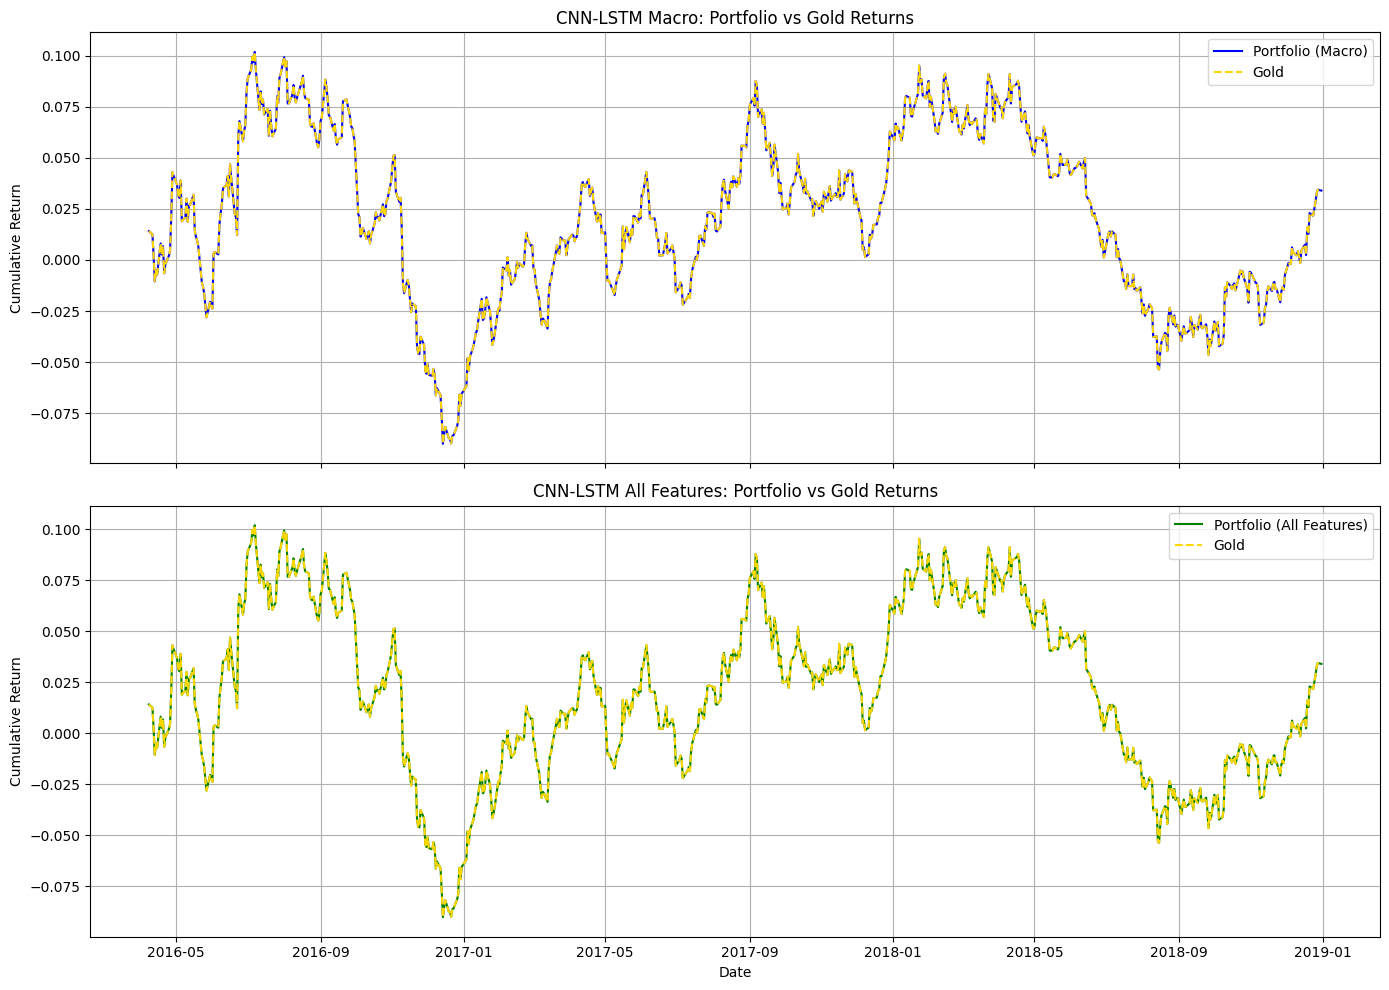

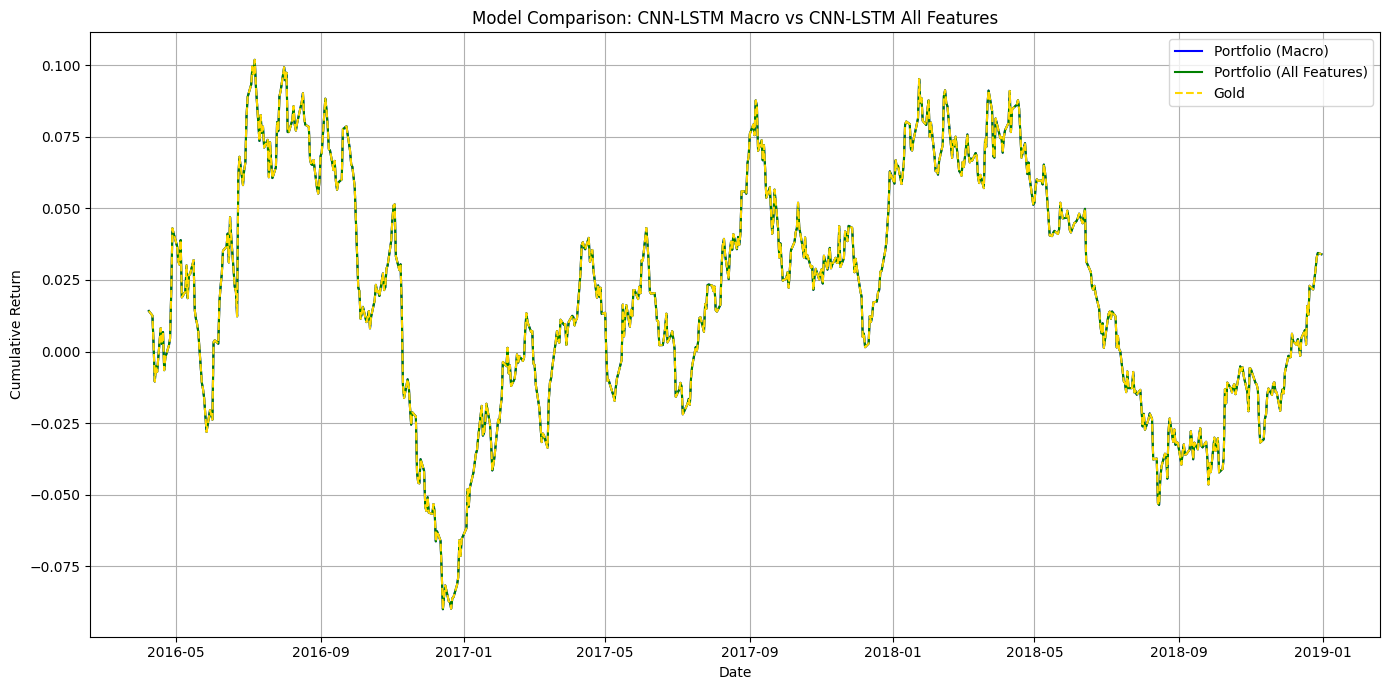

In [ ]:
#===============================================================================
# Portfolio Construction and Evaluation - CNN-LSTM Macro
#===============================================================================

# Construct portfolio based on CNN-LSTM Macro model
gold_prices_cnn_lstm_macro = pd.DataFrame({
    'Date': test_df['Date'][timesteps_cnn_lstm_macro:],
    'gold_price_orginal': test_df['gold_price_orginal'][timesteps_cnn_lstm_macro:],
    'gold_price_lag': test_df['gold_price_lag'][timesteps_cnn_lstm_macro:],
    'gold_price_prediction_cnn_lstm_macro': gold_price_prediction_cnn_lstm_macro_test
})

gold_prices_cnn_lstm_macro['going_long_cnn_lstm_macro'] = np.where(gold_prices_cnn_lstm_macro['gold_price_prediction_cnn_lstm_macro'] > 1 * gold_prices_cnn_lstm_macro['gold_price_orginal'], 1, 0)
gold_prices_cnn_lstm_macro['up'] = np.where(gold_prices_cnn_lstm_macro['gold_price_lag'] > 1 * gold_prices_cnn_lstm_macro['gold_price_orginal'], 1, 0)
gold_prices_cnn_lstm_macro['correct_cnn_lstm_macro'] = np.where(gold_prices_cnn_lstm_macro['going_long_cnn_lstm_macro'] == gold_prices_cnn_lstm_macro['up'], 1, 0)
gold_prices_cnn_lstm_macro['percentages_cnn_lstm_macro'] = (gold_prices_cnn_lstm_macro['gold_price_lag'] - gold_prices_cnn_lstm_macro['gold_price_orginal']) / gold_prices_cnn_lstm_macro['gold_price_orginal']
gold_prices_cnn_lstm_macro['absolute_percentage_cnn_lstm_macro'] = abs(gold_prices_cnn_lstm_macro['percentages_cnn_lstm_macro'])
gold_prices_cnn_lstm_macro['portfolio_percentage_cnn_lstm_macro'] = np.where(gold_prices_cnn_lstm_macro['correct_cnn_lstm_macro'] == 1, gold_prices_cnn_lstm_macro['absolute_percentage_cnn_lstm_macro'], -gold_prices_cnn_lstm_macro['absolute_percentage_cnn_lstm_macro'])
gold_prices_cnn_lstm_macro['cum_return_portfolio_cnn_lstm_macro'] = (1 + gold_prices_cnn_lstm_macro['portfolio_percentage_cnn_lstm_macro']).cumprod() - 1
gold_prices_cnn_lstm_macro['cum_return_gold_cnn_lstm_macro'] = (1 + gold_prices_cnn_lstm_macro['percentages_cnn_lstm_macro']).cumprod() - 1

# Calculate final returns for CNN-LSTM Macro
final_portfolio_return_cnn_lstm_macro = gold_prices_cnn_lstm_macro['cum_return_portfolio_cnn_lstm_macro'].iloc[-1]
final_gold_return_cnn_lstm_macro = gold_prices_cnn_lstm_macro['cum_return_gold_cnn_lstm_macro'].iloc[-1]

print("\n===== CNN-LSTM Macro Portfolio Evaluation =====")
print(f"Final Portfolio Return: {final_portfolio_return_cnn_lstm_macro:.4f} ({final_portfolio_return_cnn_lstm_macro*100:.2f}%)")
print(f"Final Gold Return: {final_gold_return_cnn_lstm_macro:.4f} ({final_gold_return_cnn_lstm_macro*100:.2f}%)")
print(f"Outperformance: {(final_portfolio_return_cnn_lstm_macro - final_gold_return_cnn_lstm_macro)*100:.2f}%")

#===============================================================================
# Portfolio Construction and Evaluation - CNN-LSTM All Features
#===============================================================================

# Construct portfolio based on CNN-LSTM All Features model
gold_prices_cnn_lstm_all = pd.DataFrame({
    'Date': test_df['Date'][timesteps_cnn_lstm_all:],
    'gold_price_orginal': test_df['gold_price_orginal'][timesteps_cnn_lstm_all:],
    'gold_price_lag': test_df['gold_price_lag'][timesteps_cnn_lstm_all:],
    'gold_price_prediction_cnn_lstm_all': gold_price_prediction_cnn_lstm_all_test
})

gold_prices_cnn_lstm_all['going_long_cnn_lstm_all'] = np.where(gold_prices_cnn_lstm_all['gold_price_prediction_cnn_lstm_all'] > 1 * gold_prices_cnn_lstm_all['gold_price_orginal'], 1, 0)
gold_prices_cnn_lstm_all['up'] = np.where(gold_prices_cnn_lstm_all['gold_price_lag'] > 1 * gold_prices_cnn_lstm_all['gold_price_orginal'], 1, 0)
gold_prices_cnn_lstm_all['correct_cnn_lstm_all'] = np.where(gold_prices_cnn_lstm_all['going_long_cnn_lstm_all'] == gold_prices_cnn_lstm_all['up'], 1, 0)
gold_prices_cnn_lstm_all['percentages_cnn_lstm_all'] = (gold_prices_cnn_lstm_all['gold_price_lag'] - gold_prices_cnn_lstm_all['gold_price_orginal']) / gold_prices_cnn_lstm_all['gold_price_orginal']
gold_prices_cnn_lstm_all['absolute_percentage_cnn_lstm_all'] = abs(gold_prices_cnn_lstm_all['percentages_cnn_lstm_all'])
gold_prices_cnn_lstm_all['portfolio_percentage_cnn_lstm_all'] = np.where(gold_prices_cnn_lstm_all['correct_cnn_lstm_all'] == 1, gold_prices_cnn_lstm_all['absolute_percentage_cnn_lstm_all'], -gold_prices_cnn_lstm_all['absolute_percentage_cnn_lstm_all'])
gold_prices_cnn_lstm_all['cum_return_portfolio_cnn_lstm_all'] = (1 + gold_prices_cnn_lstm_all['portfolio_percentage_cnn_lstm_all']).cumprod() - 1
gold_prices_cnn_lstm_all['cum_return_gold_cnn_lstm_all'] = (1 + gold_prices_cnn_lstm_all['percentages_cnn_lstm_all']).cumprod() - 1

# Calculate final returns for CNN-LSTM All
final_portfolio_return_cnn_lstm_all = gold_prices_cnn_lstm_all['cum_return_portfolio_cnn_lstm_all'].iloc[-1]
final_gold_return_cnn_lstm_all = gold_prices_cnn_lstm_all['cum_return_gold_cnn_lstm_all'].iloc[-1]

print("\n===== CNN-LSTM All Features Portfolio Evaluation =====")
print(f"Final Portfolio Return: {final_portfolio_return_cnn_lstm_all:.4f} ({final_portfolio_return_cnn_lstm_all*100:.2f}%)")
print(f"Final Gold Return: {final_gold_return_cnn_lstm_all:.4f} ({final_gold_return_cnn_lstm_all*100:.2f}%)")
print(f"Outperformance: {(final_portfolio_return_cnn_lstm_all - final_gold_return_cnn_lstm_all)*100:.2f}%")

#===============================================================================
# Visualization - Portfolio vs Gold Returns for Both Models
#===============================================================================

# Set up the figure for two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot for CNN-LSTM Macro
ax1.plot(gold_prices_cnn_lstm_macro['Date'], gold_prices_cnn_lstm_macro['cum_return_portfolio_cnn_lstm_macro'], label='Portfolio (Macro)', color='blue')
ax1.plot(gold_prices_cnn_lstm_macro['Date'], gold_prices_cnn_lstm_macro['cum_return_gold_cnn_lstm_macro'], label='Gold', color='gold', linestyle='--')
ax1.set_ylabel('Cumulative Return')
ax1.set_title('CNN-LSTM Macro: Portfolio vs Gold Returns')
ax1.legend()
ax1.grid(True)

# Plot for CNN-LSTM All Features
ax2.plot(gold_prices_cnn_lstm_all['Date'], gold_prices_cnn_lstm_all['cum_return_portfolio_cnn_lstm_all'], label='Portfolio (All Features)', color='green')
ax2.plot(gold_prices_cnn_lstm_all['Date'], gold_prices_cnn_lstm_all['cum_return_gold_cnn_lstm_all'], label='Gold', color='gold', linestyle='--')
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Return')
ax2.set_title('CNN-LSTM All Features: Portfolio vs Gold Returns')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

#===============================================================================
# Visualization - Direct Comparison of Both Portfolios
#===============================================================================

plt.figure(figsize=(14, 7))

# Plot both portfolio returns on the same graph
plt.plot(gold_prices_cnn_lstm_macro['Date'], gold_prices_cnn_lstm_macro['cum_return_portfolio_cnn_lstm_macro'], label='Portfolio (Macro)', color='blue')
plt.plot(gold_prices_cnn_lstm_all['Date'], gold_prices_cnn_lstm_all['cum_return_portfolio_cnn_lstm_all'], label='Portfolio (All Features)', color='green')
plt.plot(gold_prices_cnn_lstm_macro['Date'], gold_prices_cnn_lstm_macro['cum_return_gold_cnn_lstm_macro'], label='Gold', color='gold', linestyle='--')

# Add styling
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Model Comparison: CNN-LSTM Macro vs CNN-LSTM All Features')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()





# TabNet Model


In [ ]:
#n_trials 2x

#===============================================================================
# TabNet Model - Macro Features
#===============================================================================

# Normaliseer data voor Macro
scaler_tabnet_macro = StandardScaler()
X_train_scaled_tabnet_macro = scaler_tabnet_macro.fit_transform(X_train_macro)
X_val_scaled_tabnet_macro = scaler_tabnet_macro.transform(X_val_macro)
X_test_scaled_tabnet_macro = scaler_tabnet_macro.transform(X_test_macro)

y_train_reshaped_tabnet = y_train.reshape(-1, 1)
y_val_reshaped_tabnet = y_val.reshape(-1, 1)
y_test_reshaped_tabnet = y_test.reshape(-1, 1)

# Definieer de objective functie voor Optuna - Macro (Full Categorical)
def objective_tabnet_macro(trial):
    # Categorical choices based on the paper
    n_d = trial.suggest_categorical("n_d", [8, 16, 24, 32, 64, 128])
    n_a = trial.suggest_categorical("n_a", [8, 16, 24, 32, 64, 128])
    n_steps = trial.suggest_categorical("n_steps", [3, 4, 5, 6, 7, 8, 9, 10])
    gamma = trial.suggest_categorical("gamma", [1.0, 1.2, 1.5, 2.0])
    lambda_sparse = trial.suggest_categorical("lambda_sparse", [0, 0.000001, 0.0001, 0.001, 0.01, 0.1])
    learning_rate = trial.suggest_categorical("lr", [0.0001, 0.0005, 0.001, 0.005, 0.01])
    mask_type = trial.suggest_categorical("mask_type", ["sparsemax"])

    # Added batch_size as categorical
    batch_size = trial.suggest_categorical("batch_size", [256, 512, 1024, 2048])

    # Virtual batch size should be <= batch_size
    virtual_batch_size = min(128, batch_size // 2)

    model_tabnet_macro_trial = TabNetRegressor(
        n_d=n_d,
        n_a=n_a,
        n_steps=n_steps,
        gamma=gamma,
        lambda_sparse=lambda_sparse,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=learning_rate),
        mask_type=mask_type,
        verbose=0,
        seed=42
    )

    model_tabnet_macro_trial.fit(
        X_train=X_train_scaled_tabnet_macro, y_train=y_train_reshaped_tabnet,
        eval_set=[(X_val_scaled_tabnet_macro, y_val_reshaped_tabnet)],
        eval_metric=["rmse"],
        max_epochs=100,
        patience=15,
        batch_size=batch_size,
        virtual_batch_size=virtual_batch_size,
        num_workers=0,
        drop_last=False
    )

    preds_tabnet_macro = model_tabnet_macro_trial.predict(X_val_scaled_tabnet_macro).flatten()
    mse_tabnet_macro = mean_squared_error(y_val, preds_tabnet_macro)
    return mse_tabnet_macro

# Run de Optuna studie voor Macro
print("=== Optimizing TabNet Macro Features (Full Categorical) ===")
study_tabnet_macro = optuna.create_study(direction="minimize")
study_tabnet_macro.optimize(objective_tabnet_macro, n_trials=30)  # Increased for categorical search

# Beste parameters voor Macro
print("Beste hyperparameters voor TabNet Macro:", study_tabnet_macro.best_params)
print("Beste MSE voor TabNet Macro:", study_tabnet_macro.best_value)

#===============================================================================
# TabNet Model - All Features
#===============================================================================

# 📊 Normaliseer data voor All Features
scaler_tabnet_all = StandardScaler()
X_train_scaled_tabnet_all = scaler_tabnet_all.fit_transform(X_train_all)
X_val_scaled_tabnet_all = scaler_tabnet_all.transform(X_val_all)
X_test_scaled_tabnet_all = scaler_tabnet_all.transform(X_test_all)

# Definieer de objective functie voor Optuna - All Features (Full Categorical)
def objective_tabnet_all(trial):
    # Categorical choices based on the paper
    n_d = trial.suggest_categorical("n_d", [8, 16, 24, 32, 64, 128])
    n_a = trial.suggest_categorical("n_a", [8, 16, 24, 32, 64, 128])
    n_steps = trial.suggest_categorical("n_steps", [3, 4, 5, 6, 7, 8, 9, 10])
    gamma = trial.suggest_categorical("gamma", [1.0, 1.2, 1.5, 2.0])
    lambda_sparse = trial.suggest_categorical("lambda_sparse", [0, 0.000001, 0.0001, 0.001, 0.01, 0.1])
    learning_rate = trial.suggest_categorical("lr", [0.0001, 0.0005, 0.001, 0.005, 0.01])
    mask_type = trial.suggest_categorical("mask_type", ["sparsemax"])

    # Added batch_size as categorical
    batch_size = trial.suggest_categorical("batch_size", [256, 512, 1024, 2048])

    # Virtual batch size should be <= batch_size
    virtual_batch_size = min(128, batch_size // 2)

    model_tabnet_all_trial = TabNetRegressor(
        n_d=n_d,
        n_a=n_a,
        n_steps=n_steps,
        gamma=gamma,
        lambda_sparse=lambda_sparse,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=learning_rate),
        mask_type=mask_type,
        verbose=0,
        seed=42
    )

    model_tabnet_all_trial.fit(
        X_train=X_train_scaled_tabnet_all, y_train=y_train_reshaped_tabnet,
        eval_set=[(X_val_scaled_tabnet_all, y_val_reshaped_tabnet)],
        eval_metric=["rmse"],
        max_epochs=100,
        patience=15,
        batch_size=batch_size,
        virtual_batch_size=virtual_batch_size,
        num_workers=0,
        drop_last=False
    )

    preds_tabnet_all = model_tabnet_all_trial.predict(X_val_scaled_tabnet_all).flatten()
    mse_tabnet_all = mean_squared_error(y_val, preds_tabnet_all)
    return mse_tabnet_all

# Run de Optuna studie voor All Features
print("\n=== Optimizing TabNet All Features (Full Categorical) ===")
study_tabnet_all = optuna.create_study(direction="minimize")
study_tabnet_all.optimize(objective_tabnet_all, n_trials=30)  # Increased for categorical search

# Beste parameters voor All Features
print("Beste hyperparameters voor TabNet All:", study_tabnet_all.best_params)
print("Beste MSE voor TabNet All:", study_tabnet_all.best_value)

#===============================================================================
# Model Comparison Summary
#===============================================================================

print("\n" + "="*50)
print("TabNet Model Comparison Summary (Full Categorical)")
print("="*50)
print(f"Best MSE - Macro Features: {study_tabnet_macro.best_value:.6f}")
print(f"Best MSE - All Features: {study_tabnet_all.best_value:.6f}")
print("="*50)

# Print the categorical values used
print("\nCategorical parameter spaces used:")
print("n_d: [8, 16, 24, 32, 64, 128]")
print("n_a: [8, 16, 24, 32, 64, 128]")
print("n_steps: [3, 4, 5, 6, 7, 8, 9, 10]")
print("gamma: [1.0, 1.2, 1.5, 2.0]")
print("lambda_sparse: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1]")
print("learning_rate: [0.0001, 0.0005, 0.001, 0.005, 0.01]")
print("mask_type: ['entmax', 'sparsemax']")
print("batch_size: [256, 512, 1024, 2048]")

# Print virtual batch size logic
print("\nNote: virtual_batch_size is set to min(128, batch_size // 2)")

[I 2025-05-13 22:25:02,079] A new study created in memory with name: no-name-c5dcee84-ebc5-4e83-9d2a-ed87bb236453


=== Optimizing TabNet Macro Features (Full Categorical) ===

Early stopping occurred at epoch 40 with best_epoch = 25 and best_val_0_rmse = 0.15783


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 22:25:33,943] Trial 0 finished with value: 0.024908761684741078 and parameters: {'n_d': 128, 'n_a': 8, 'n_steps': 3, 'gamma': 1.2, 'lambda_sparse': 1e-06, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 1024}. Best is trial 0 with value: 0.024908761684741078.
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 22:26:09,971] Trial 1 finished with value: 0.0025574716078267043 and parameters: {'n_d': 24, 'n_a': 32, 'n_steps': 3, 'gamma': 1.2, 'lambda_sparse': 0.0001, 'lr': 0.005, 'mask_type': 'sparsemax', 'batch_size': 1024}. Best is trial 1 with value: 0.0025574716078267043.



Early stopping occurred at epoch 89 with best_epoch = 74 and best_val_0_rmse = 0.05057

Early stopping occurred at epoch 97 with best_epoch = 82 and best_val_0_rmse = 0.11872


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 22:26:56,441] Trial 2 finished with value: 0.014093429985774761 and parameters: {'n_d': 64, 'n_a': 24, 'n_steps': 3, 'gamma': 1.2, 'lambda_sparse': 0.001, 'lr': 0.005, 'mask_type': 'sparsemax', 'batch_size': 2048}. Best is trial 1 with value: 0.0025574716078267043.



Early stopping occurred at epoch 17 with best_epoch = 2 and best_val_0_rmse = 2.08714


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 22:27:13,944] Trial 3 finished with value: 4.356151129859388 and parameters: {'n_d': 64, 'n_a': 8, 'n_steps': 9, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'lr': 0.001, 'mask_type': 'sparsemax', 'batch_size': 2048}. Best is trial 1 with value: 0.0025574716078267043.



Early stopping occurred at epoch 43 with best_epoch = 28 and best_val_0_rmse = 1.60384


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 22:29:16,450] Trial 4 finished with value: 2.5722896350836524 and parameters: {'n_d': 128, 'n_a': 64, 'n_steps': 10, 'gamma': 2.0, 'lambda_sparse': 0.1, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 2048}. Best is trial 1 with value: 0.0025574716078267043.
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 22:29:45,061] Trial 5 finished with value: 0.019738799943092165 and parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 4, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'lr': 0.005, 'mask_type': 'sparsemax', 'batch_size': 2048}. Best is trial 1 with value: 0.0025574716078267043.



Early stopping occurred at epoch 69 with best_epoch = 54 and best_val_0_rmse = 0.14049

Early stopping occurred at epoch 17 with best_epoch = 2 and best_val_0_rmse = 5.27499


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 22:30:09,854] Trial 6 finished with value: 27.8254789634348 and parameters: {'n_d': 24, 'n_a': 128, 'n_steps': 6, 'gamma': 1.5, 'lambda_sparse': 0.1, 'lr': 0.0001, 'mask_type': 'sparsemax', 'batch_size': 2048}. Best is trial 1 with value: 0.0025574716078267043.


Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse = 2.14455


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 22:33:49,725] Trial 7 finished with value: 4.599107422551197 and parameters: {'n_d': 128, 'n_a': 24, 'n_steps': 10, 'gamma': 1.5, 'lambda_sparse': 0.1, 'lr': 0.0005, 'mask_type': 'sparsemax', 'batch_size': 2048}. Best is trial 1 with value: 0.0025574716078267043.



Early stopping occurred at epoch 73 with best_epoch = 58 and best_val_0_rmse = 0.82168


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 22:34:46,013] Trial 8 finished with value: 0.6751642523835192 and parameters: {'n_d': 24, 'n_a': 16, 'n_steps': 6, 'gamma': 1.5, 'lambda_sparse': 0.001, 'lr': 0.0005, 'mask_type': 'sparsemax', 'batch_size': 512}. Best is trial 1 with value: 0.0025574716078267043.



Early stopping occurred at epoch 85 with best_epoch = 70 and best_val_0_rmse = 0.0099


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 22:36:00,367] Trial 9 finished with value: 9.792971868957857e-05 and parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 7, 'gamma': 1.5, 'lambda_sparse': 0.01, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 512}. Best is trial 9 with value: 9.792971868957857e-05.


Stop training because you reached max_epochs = 100 with best_epoch = 97 and best_val_0_rmse = 0.00987


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 22:37:25,243] Trial 10 finished with value: 9.733798606335141e-05 and parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 7, 'gamma': 1.0, 'lambda_sparse': 0.01, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 512}. Best is trial 10 with value: 9.733798606335141e-05.


Stop training because you reached max_epochs = 100 with best_epoch = 97 and best_val_0_rmse = 0.00987


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 22:38:51,105] Trial 11 finished with value: 9.733798606335141e-05 and parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 7, 'gamma': 1.0, 'lambda_sparse': 0.01, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 512}. Best is trial 10 with value: 9.733798606335141e-05.



Early stopping occurred at epoch 71 with best_epoch = 56 and best_val_0_rmse = 0.00994


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 22:40:13,340] Trial 12 finished with value: 9.889938605370226e-05 and parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 7, 'gamma': 1.0, 'lambda_sparse': 0.01, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 256}. Best is trial 10 with value: 9.733798606335141e-05.



Early stopping occurred at epoch 59 with best_epoch = 44 and best_val_0_rmse = 0.00981


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 22:40:59,301] Trial 13 finished with value: 9.624860463824105e-05 and parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 7, 'gamma': 1.0, 'lambda_sparse': 0, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 512}. Best is trial 13 with value: 9.624860463824105e-05.



Early stopping occurred at epoch 16 with best_epoch = 1 and best_val_0_rmse = 3.84971


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 22:41:16,187] Trial 14 finished with value: 14.8202315211908 and parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 8, 'gamma': 1.0, 'lambda_sparse': 0, 'lr': 0.0001, 'mask_type': 'sparsemax', 'batch_size': 512}. Best is trial 13 with value: 9.624860463824105e-05.


Stop training because you reached max_epochs = 100 with best_epoch = 98 and best_val_0_rmse = 0.15014


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 22:43:02,948] Trial 15 finished with value: 0.02254176789944875 and parameters: {'n_d': 16, 'n_a': 64, 'n_steps': 7, 'gamma': 1.0, 'lambda_sparse': 0, 'lr': 0.001, 'mask_type': 'sparsemax', 'batch_size': 512}. Best is trial 13 with value: 9.624860463824105e-05.



Early stopping occurred at epoch 38 with best_epoch = 23 and best_val_0_rmse = 0.01504


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 22:43:59,259] Trial 16 finished with value: 0.00022627802191585924 and parameters: {'n_d': 16, 'n_a': 128, 'n_steps': 5, 'gamma': 2.0, 'lambda_sparse': 0, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 256}. Best is trial 13 with value: 9.624860463824105e-05.



Early stopping occurred at epoch 38 with best_epoch = 23 and best_val_0_rmse = 0.00982


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 22:44:27,337] Trial 17 finished with value: 9.636653702014295e-05 and parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 7, 'gamma': 1.0, 'lambda_sparse': 1e-06, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 512}. Best is trial 13 with value: 9.624860463824105e-05.
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 22:45:15,005] Trial 18 finished with value: 0.0001522489735398831 and parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 4, 'gamma': 1.0, 'lambda_sparse': 1e-06, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 512}. Best is trial 13 with value: 9.624860463824105e-05.


Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse = 0.01234

Early stopping occurred at epoch 16 with best_epoch = 1 and best_val_0_rmse = 1.41926


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 22:45:29,757] Trial 19 finished with value: 2.0143105119638918 and parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 9, 'gamma': 1.0, 'lambda_sparse': 1e-06, 'lr': 0.0005, 'mask_type': 'sparsemax', 'batch_size': 512}. Best is trial 13 with value: 9.624860463824105e-05.



Early stopping occurred at epoch 15 with best_epoch = 0 and best_val_0_rmse = 1.44495


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 22:45:45,964] Trial 20 finished with value: 2.0878753324396335 and parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 8, 'gamma': 2.0, 'lambda_sparse': 0, 'lr': 0.0001, 'mask_type': 'sparsemax', 'batch_size': 256}. Best is trial 13 with value: 9.624860463824105e-05.



Early stopping occurred at epoch 73 with best_epoch = 58 and best_val_0_rmse = 0.00981


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 22:46:41,065] Trial 21 finished with value: 9.622874471504312e-05 and parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 7, 'gamma': 1.0, 'lambda_sparse': 0.01, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 512}. Best is trial 21 with value: 9.622874471504312e-05.



Early stopping occurred at epoch 45 with best_epoch = 30 and best_val_0_rmse = 0.00983


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 22:47:14,296] Trial 22 finished with value: 9.655613395067975e-05 and parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 7, 'gamma': 1.0, 'lambda_sparse': 1e-06, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 512}. Best is trial 21 with value: 9.622874471504312e-05.



Early stopping occurred at epoch 45 with best_epoch = 30 and best_val_0_rmse = 0.00983


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 22:47:47,847] Trial 23 finished with value: 9.655613395067975e-05 and parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 7, 'gamma': 1.0, 'lambda_sparse': 1e-06, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 512}. Best is trial 21 with value: 9.622874471504312e-05.


Stop training because you reached max_epochs = 100 with best_epoch = 92 and best_val_0_rmse = 0.01072


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 22:48:32,690] Trial 24 finished with value: 0.00011481553783701005 and parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 1024}. Best is trial 21 with value: 9.622874471504312e-05.


Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse = 0.35695


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 22:49:57,448] Trial 25 finished with value: 0.1274117289340666 and parameters: {'n_d': 16, 'n_a': 24, 'n_steps': 7, 'gamma': 1.0, 'lambda_sparse': 0.01, 'lr': 0.001, 'mask_type': 'sparsemax', 'batch_size': 512}. Best is trial 21 with value: 9.622874471504312e-05.



Early stopping occurred at epoch 55 with best_epoch = 40 and best_val_0_rmse = 0.00986


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 22:50:43,279] Trial 26 finished with value: 9.718828477906408e-05 and parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 7, 'gamma': 1.0, 'lambda_sparse': 0.001, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 512}. Best is trial 21 with value: 9.622874471504312e-05.



Early stopping occurred at epoch 80 with best_epoch = 65 and best_val_0_rmse = 0.00986


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 22:52:05,691] Trial 27 finished with value: 9.720885846891761e-05 and parameters: {'n_d': 8, 'n_a': 64, 'n_steps': 7, 'gamma': 1.0, 'lambda_sparse': 1e-06, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 512}. Best is trial 21 with value: 9.622874471504312e-05.



Early stopping occurred at epoch 82 with best_epoch = 67 and best_val_0_rmse = 0.00985


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 22:54:20,494] Trial 28 finished with value: 9.692458114580407e-05 and parameters: {'n_d': 16, 'n_a': 128, 'n_steps': 7, 'gamma': 1.2, 'lambda_sparse': 0, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 512}. Best is trial 21 with value: 9.622874471504312e-05.



Early stopping occurred at epoch 20 with best_epoch = 5 and best_val_0_rmse = 1.57994


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 22:54:46,517] Trial 29 finished with value: 2.49621975451994 and parameters: {'n_d': 64, 'n_a': 8, 'n_steps': 10, 'gamma': 2.0, 'lambda_sparse': 0.01, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 1024}. Best is trial 21 with value: 9.622874471504312e-05.
[I 2025-05-13 22:54:46,537] A new study created in memory with name: no-name-57dc00cb-3309-4de1-97e2-de484c4933d6


Beste hyperparameters voor TabNet Macro: {'n_d': 16, 'n_a': 16, 'n_steps': 7, 'gamma': 1.0, 'lambda_sparse': 0.01, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 512}
Beste MSE voor TabNet Macro: 9.622874471504312e-05

=== Optimizing TabNet All Features (Full Categorical) ===

Early stopping occurred at epoch 72 with best_epoch = 57 and best_val_0_rmse = 0.01184


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 22:57:40,893] Trial 0 finished with value: 0.00014020830046943878 and parameters: {'n_d': 32, 'n_a': 128, 'n_steps': 8, 'gamma': 1.5, 'lambda_sparse': 1e-06, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 256}. Best is trial 0 with value: 0.00014020830046943878.



Early stopping occurred at epoch 16 with best_epoch = 1 and best_val_0_rmse = 1.38708


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 22:58:00,678] Trial 1 finished with value: 1.92400046564758 and parameters: {'n_d': 24, 'n_a': 64, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 1e-06, 'lr': 0.0001, 'mask_type': 'sparsemax', 'batch_size': 256}. Best is trial 0 with value: 0.00014020830046943878.


Stop training because you reached max_epochs = 100 with best_epoch = 91 and best_val_0_rmse = 0.35769


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 22:59:03,449] Trial 2 finished with value: 0.127939269082565 and parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 6, 'gamma': 1.2, 'lambda_sparse': 0, 'lr': 0.001, 'mask_type': 'sparsemax', 'batch_size': 1024}. Best is trial 0 with value: 0.00014020830046943878.



Early stopping occurred at epoch 65 with best_epoch = 50 and best_val_0_rmse = 0.01003


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 23:00:08,946] Trial 3 finished with value: 0.00010068419137270256 and parameters: {'n_d': 24, 'n_a': 24, 'n_steps': 6, 'gamma': 1.0, 'lambda_sparse': 0.01, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 256}. Best is trial 3 with value: 0.00010068419137270256.



Early stopping occurred at epoch 60 with best_epoch = 45 and best_val_0_rmse = 2.09536


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 23:03:49,451] Trial 4 finished with value: 4.39053673890663 and parameters: {'n_d': 128, 'n_a': 64, 'n_steps': 10, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'lr': 0.0001, 'mask_type': 'sparsemax', 'batch_size': 256}. Best is trial 3 with value: 0.00010068419137270256.



Early stopping occurred at epoch 32 with best_epoch = 17 and best_val_0_rmse = 1.43309


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 23:04:57,998] Trial 5 finished with value: 2.0537485743003203 and parameters: {'n_d': 128, 'n_a': 16, 'n_steps': 10, 'gamma': 1.2, 'lambda_sparse': 0.001, 'lr': 0.005, 'mask_type': 'sparsemax', 'batch_size': 2048}. Best is trial 3 with value: 0.00010068419137270256.



Early stopping occurred at epoch 43 with best_epoch = 28 and best_val_0_rmse = 1.02065


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 23:06:54,824] Trial 6 finished with value: 1.0417268990232447 and parameters: {'n_d': 128, 'n_a': 128, 'n_steps': 5, 'gamma': 1.2, 'lambda_sparse': 0.1, 'lr': 0.0001, 'mask_type': 'sparsemax', 'batch_size': 256}. Best is trial 3 with value: 0.00010068419137270256.



Early stopping occurred at epoch 66 with best_epoch = 51 and best_val_0_rmse = 0.01082


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 23:09:25,253] Trial 7 finished with value: 0.00011712355244261998 and parameters: {'n_d': 64, 'n_a': 128, 'n_steps': 6, 'gamma': 1.2, 'lambda_sparse': 0, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 256}. Best is trial 3 with value: 0.00010068419137270256.


Stop training because you reached max_epochs = 100 with best_epoch = 85 and best_val_0_rmse = 0.75514


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 23:13:37,633] Trial 8 finished with value: 0.5702343369691374 and parameters: {'n_d': 128, 'n_a': 32, 'n_steps': 10, 'gamma': 1.2, 'lambda_sparse': 1e-06, 'lr': 0.001, 'mask_type': 'sparsemax', 'batch_size': 512}. Best is trial 3 with value: 0.00010068419137270256.


Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse = 0.01009


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 23:15:07,817] Trial 9 finished with value: 0.00010173020601012637 and parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 7, 'gamma': 2.0, 'lambda_sparse': 1e-06, 'lr': 0.005, 'mask_type': 'sparsemax', 'batch_size': 512}. Best is trial 3 with value: 0.00010068419137270256.
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 23:15:43,610] Trial 10 finished with value: 0.2468224578106338 and parameters: {'n_d': 24, 'n_a': 24, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.01, 'lr': 0.0005, 'mask_type': 'sparsemax', 'batch_size': 2048}. Best is trial 3 with value: 0.00010068419137270256.


Stop training because you reached max_epochs = 100 with best_epoch = 90 and best_val_0_rmse = 0.49681
Stop training because you reached max_epochs = 100 with best_epoch = 88 and best_val_0_rmse = 0.00986


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 23:17:16,118] Trial 11 finished with value: 9.723197285305726e-05 and parameters: {'n_d': 16, 'n_a': 24, 'n_steps': 7, 'gamma': 2.0, 'lambda_sparse': 0.01, 'lr': 0.005, 'mask_type': 'sparsemax', 'batch_size': 512}. Best is trial 11 with value: 9.723197285305726e-05.



Early stopping occurred at epoch 63 with best_epoch = 48 and best_val_0_rmse = 0.00979


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 23:18:24,468] Trial 12 finished with value: 9.575973617051742e-05 and parameters: {'n_d': 16, 'n_a': 24, 'n_steps': 9, 'gamma': 2.0, 'lambda_sparse': 0.01, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 512}. Best is trial 12 with value: 9.575973617051742e-05.



Early stopping occurred at epoch 89 with best_epoch = 74 and best_val_0_rmse = 0.00988


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 23:19:52,834] Trial 13 finished with value: 9.765475125116755e-05 and parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 9, 'gamma': 2.0, 'lambda_sparse': 0.01, 'lr': 0.005, 'mask_type': 'sparsemax', 'batch_size': 512}. Best is trial 12 with value: 9.575973617051742e-05.



Early stopping occurred at epoch 84 with best_epoch = 69 and best_val_0_rmse = 1.08912


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 23:21:06,411] Trial 14 finished with value: 1.18617542839675 and parameters: {'n_d': 16, 'n_a': 24, 'n_steps': 7, 'gamma': 2.0, 'lambda_sparse': 0.01, 'lr': 0.0005, 'mask_type': 'sparsemax', 'batch_size': 512}. Best is trial 12 with value: 9.575973617051742e-05.



Early stopping occurred at epoch 65 with best_epoch = 50 and best_val_0_rmse = 0.00983


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 23:21:42,334] Trial 15 finished with value: 9.664598640847708e-05 and parameters: {'n_d': 16, 'n_a': 24, 'n_steps': 4, 'gamma': 2.0, 'lambda_sparse': 0.01, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 512}. Best is trial 12 with value: 9.575973617051742e-05.


Stop training because you reached max_epochs = 100 with best_epoch = 98 and best_val_0_rmse = 0.00987


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 23:22:25,593] Trial 16 finished with value: 9.733588357397096e-05 and parameters: {'n_d': 8, 'n_a': 24, 'n_steps': 4, 'gamma': 2.0, 'lambda_sparse': 0.0001, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 1024}. Best is trial 12 with value: 9.575973617051742e-05.



Early stopping occurred at epoch 70 with best_epoch = 55 and best_val_0_rmse = 0.0098


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 23:23:42,937] Trial 17 finished with value: 9.601611231469542e-05 and parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 9, 'gamma': 2.0, 'lambda_sparse': 0.001, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 512}. Best is trial 12 with value: 9.575973617051742e-05.



Early stopping occurred at epoch 70 with best_epoch = 55 and best_val_0_rmse = 0.0098


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 23:25:02,037] Trial 18 finished with value: 9.601611231469542e-05 and parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 9, 'gamma': 2.0, 'lambda_sparse': 0.001, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 512}. Best is trial 12 with value: 9.575973617051742e-05.


Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse = 0.01039


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 23:27:40,354] Trial 19 finished with value: 0.00010797412709721775 and parameters: {'n_d': 64, 'n_a': 32, 'n_steps': 9, 'gamma': 2.0, 'lambda_sparse': 0.001, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 512}. Best is trial 12 with value: 9.575973617051742e-05.


Stop training because you reached max_epochs = 100 with best_epoch = 93 and best_val_0_rmse = 0.00983


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 23:28:55,870] Trial 20 finished with value: 9.659313657267843e-05 and parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 9, 'gamma': 1.5, 'lambda_sparse': 0.1, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 1024}. Best is trial 12 with value: 9.575973617051742e-05.



Early stopping occurred at epoch 70 with best_epoch = 55 and best_val_0_rmse = 0.0098


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 23:30:16,210] Trial 21 finished with value: 9.601611231469542e-05 and parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 9, 'gamma': 2.0, 'lambda_sparse': 0.001, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 512}. Best is trial 12 with value: 9.575973617051742e-05.



Early stopping occurred at epoch 70 with best_epoch = 55 and best_val_0_rmse = 0.0098


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 23:31:32,736] Trial 22 finished with value: 9.601611231469542e-05 and parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 9, 'gamma': 2.0, 'lambda_sparse': 0.001, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 512}. Best is trial 12 with value: 9.575973617051742e-05.



Early stopping occurred at epoch 70 with best_epoch = 55 and best_val_0_rmse = 0.0098


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 23:32:50,977] Trial 23 finished with value: 9.601611231469542e-05 and parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 9, 'gamma': 2.0, 'lambda_sparse': 0.001, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 512}. Best is trial 12 with value: 9.575973617051742e-05.



Early stopping occurred at epoch 37 with best_epoch = 22 and best_val_0_rmse = 0.78441


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 23:33:24,258] Trial 24 finished with value: 0.6152951185516375 and parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 9, 'gamma': 2.0, 'lambda_sparse': 0.001, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 2048}. Best is trial 12 with value: 9.575973617051742e-05.



Early stopping occurred at epoch 66 with best_epoch = 51 and best_val_0_rmse = 0.39606


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 23:33:56,224] Trial 25 finished with value: 0.15686445329845794 and parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 3, 'gamma': 2.0, 'lambda_sparse': 0.001, 'lr': 0.0005, 'mask_type': 'sparsemax', 'batch_size': 512}. Best is trial 12 with value: 9.575973617051742e-05.



Early stopping occurred at epoch 70 with best_epoch = 55 and best_val_0_rmse = 0.0098


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 23:35:17,322] Trial 26 finished with value: 9.601611231469542e-05 and parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 9, 'gamma': 2.0, 'lambda_sparse': 0.001, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 512}. Best is trial 12 with value: 9.575973617051742e-05.


Stop training because you reached max_epochs = 100 with best_epoch = 96 and best_val_0_rmse = 0.18541


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 23:37:20,184] Trial 27 finished with value: 0.034375353046540255 and parameters: {'n_d': 16, 'n_a': 64, 'n_steps': 8, 'gamma': 2.0, 'lambda_sparse': 0, 'lr': 0.001, 'mask_type': 'sparsemax', 'batch_size': 512}. Best is trial 12 with value: 9.575973617051742e-05.



Early stopping occurred at epoch 62 with best_epoch = 47 and best_val_0_rmse = 0.00979


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 23:38:12,991] Trial 28 finished with value: 9.581681430847283e-05 and parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 9, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 512}. Best is trial 12 with value: 9.575973617051742e-05.



Early stopping occurred at epoch 55 with best_epoch = 40 and best_val_0_rmse = 0.0098


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-13 23:38:47,523] Trial 29 finished with value: 9.609351256719942e-05 and parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 8, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 1024}. Best is trial 12 with value: 9.575973617051742e-05.


Beste hyperparameters voor TabNet All: {'n_d': 16, 'n_a': 24, 'n_steps': 9, 'gamma': 2.0, 'lambda_sparse': 0.01, 'lr': 0.01, 'mask_type': 'sparsemax', 'batch_size': 512}
Beste MSE voor TabNet All: 9.575973617051742e-05

TabNet Model Comparison Summary (Full Categorical)
Best MSE - Macro Features: 0.000096
Best MSE - All Features: 0.000096

Categorical parameter spaces used:
n_d: [8, 16, 24, 32, 64, 128]
n_a: [8, 16, 24, 32, 64, 128]
n_steps: [3, 4, 5, 6, 7, 8, 9, 10]
gamma: [1.0, 1.2, 1.5, 2.0]
lambda_sparse: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1]
learning_rate: [0.0001, 0.0005, 0.001, 0.005, 0.01]
mask_type: ['entmax', 'sparsemax']
batch_size: [256, 512, 1024, 2048]

Note: virtual_batch_size is set to min(128, batch_size // 2)


In [ ]:
#===============================================================================
# Train Best TabNet Models
#===============================================================================

# Voor Macro Features
best_params_tabnet_macro = study_tabnet_macro.best_params
best_model_tabnet_macro = TabNetRegressor(
    n_d=best_params_tabnet_macro["n_d"],
    n_a=best_params_tabnet_macro["n_a"],
    n_steps=best_params_tabnet_macro["n_steps"],
    gamma=best_params_tabnet_macro["gamma"],
    lambda_sparse=best_params_tabnet_macro["lambda_sparse"],
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=best_params_tabnet_macro["lr"]),
    mask_type=best_params_tabnet_macro["mask_type"],
    verbose=1,
    seed=42
)

best_model_tabnet_macro.fit(
    X_train=X_train_scaled_tabnet_macro, y_train=y_train_reshaped_tabnet,
    eval_set=[(X_val_scaled_tabnet_macro, y_val_reshaped_tabnet)],
    eval_metric=["rmse"],
    max_epochs=200,
    patience=30,
    batch_size=512,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# Voor All Features
best_params_tabnet_all = study_tabnet_all.best_params
best_model_tabnet_all = TabNetRegressor(
    n_d=best_params_tabnet_all["n_d"],
    n_a=best_params_tabnet_all["n_a"],
    n_steps=best_params_tabnet_all["n_steps"],
    gamma=best_params_tabnet_all["gamma"],
    lambda_sparse=best_params_tabnet_all["lambda_sparse"],
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=best_params_tabnet_all["lr"]),
    mask_type=best_params_tabnet_all["mask_type"],
    verbose=1,
    seed=42
)

best_model_tabnet_all.fit(
    X_train=X_train_scaled_tabnet_all, y_train=y_train_reshaped_tabnet,
    eval_set=[(X_val_scaled_tabnet_all, y_val_reshaped_tabnet)],
    eval_metric=["rmse"],
    max_epochs=200,
    patience=30,
    batch_size=512,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

#===============================================================================
# Evaluate Best Models on Test Set
#===============================================================================

# Macro Features Test Evaluation
test_preds_tabnet_macro = best_model_tabnet_macro.predict(X_test_scaled_tabnet_macro).flatten()
test_mse_tabnet_macro = mean_squared_error(y_test, test_preds_tabnet_macro)
print(f"TabNet Macro Test set MSE: {test_mse_tabnet_macro:.6f}")

# All Features Test Evaluation
test_preds_tabnet_all = best_model_tabnet_all.predict(X_test_scaled_tabnet_all).flatten()
test_mse_tabnet_all = mean_squared_error(y_test, test_preds_tabnet_all)
print(f"TabNet All Test set MSE: {test_mse_tabnet_all:.6f}")

#===============================================================================
# Final Comparison
#===============================================================================

print("\n" + "="*50)
print("TabNet Final Test Results")
print("="*50)
print(f"Macro Features MSE: {test_mse_tabnet_macro:.6f}")
print(f"All Features MSE: {test_mse_tabnet_all:.6f}")

if test_mse_tabnet_macro > 0:
    improvement = ((test_mse_tabnet_macro - test_mse_tabnet_all) / test_mse_tabnet_macro * 100)
    if improvement >= 0:
        print(f"Test Set Improvement with All Features: {improvement:.2f}%")
    else:
        print(f"Test Set: All Features perform worse than Macro Features: {abs(improvement):.2f}%")
print("="*50)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.60515 | val_0_rmse: 0.93912 |  0:00:00s
epoch 1  | loss: 1.74929 | val_0_rmse: 0.89029 |  0:00:01s
epoch 2  | loss: 1.28866 | val_0_rmse: 0.67256 |  0:00:01s
epoch 3  | loss: 0.86753 | val_0_rmse: 0.64487 |  0:00:02s
epoch 4  | loss: 0.52822 | val_0_rmse: 0.48635 |  0:00:03s
epoch 5  | loss: 0.4494  | val_0_rmse: 0.4446  |  0:00:03s
epoch 6  | loss: 0.36664 | val_0_rmse: 0.49717 |  0:00:04s
epoch 7  | loss: 0.23803 | val_0_rmse: 0.60165 |  0:00:05s
epoch 8  | loss: 0.18555 | val_0_rmse: 0.43373 |  0:00:06s
epoch 9  | loss: 0.13665 | val_0_rmse: 0.28609 |  0:00:07s
epoch 10 | loss: 0.08841 | val_0_rmse: 0.22814 |  0:00:08s
epoch 11 | loss: 0.06599 | val_0_rmse: 0.17493 |  0:00:08s
epoch 12 | loss: 0.04611 | val_0_rmse: 0.20074 |  0:00:09s
epoch 13 | loss: 0.0348  | val_0_rmse: 0.20828 |  0:00:10s
epoch 14 | loss: 0.0308  | val_0_rmse: 0.16281 |  0:00:10s
epoch 15 | loss: 0.02463 | val_0_rmse: 0.11388 |  0:00:11s
epoch 16 | loss: 0.01695 | val_0_rmse: 0.09462 |  0:00:1

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 20.91797| val_0_rmse: 3.96279 |  0:00:00s
epoch 1  | loss: 3.43561 | val_0_rmse: 1.88041 |  0:00:01s
epoch 2  | loss: 2.26325 | val_0_rmse: 1.34129 |  0:00:02s
epoch 3  | loss: 1.41699 | val_0_rmse: 1.45763 |  0:00:03s
epoch 4  | loss: 0.82449 | val_0_rmse: 1.32773 |  0:00:04s
epoch 5  | loss: 0.58371 | val_0_rmse: 1.11578 |  0:00:05s
epoch 6  | loss: 0.45184 | val_0_rmse: 0.85818 |  0:00:07s
epoch 7  | loss: 0.4026  | val_0_rmse: 1.46697 |  0:00:08s
epoch 8  | loss: 0.42238 | val_0_rmse: 1.47412 |  0:00:09s
epoch 9  | loss: 0.44636 | val_0_rmse: 1.58714 |  0:00:10s
epoch 10 | loss: 0.38633 | val_0_rmse: 2.39472 |  0:00:10s
epoch 11 | loss: 0.19167 | val_0_rmse: 1.52378 |  0:00:11s
epoch 12 | loss: 0.17159 | val_0_rmse: 0.59774 |  0:00:12s
epoch 13 | loss: 0.11608 | val_0_rmse: 0.9322  |  0:00:13s
epoch 14 | loss: 0.09286 | val_0_rmse: 0.50887 |  0:00:14s
epoch 15 | loss: 0.12854 | val_0_rmse: 0.85738 |  0:00:15s
epoch 16 | loss: 0.12541 | val_0_rmse: 0.88355 |  0:00:1

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet Macro Test set MSE: 0.000052
TabNet All Test set MSE: 0.000054

TabNet Final Test Results
Macro Features MSE: 0.000052
All Features MSE: 0.000054
Test Set: All Features perform worse than Macro Features: 3.72%


In [ ]:
#===============================================================================
# Maak voorspellingen met TabNet - Macro Features
#===============================================================================
y_pred_train_tabnet_macro = best_model_tabnet_macro.predict(X_train_scaled_tabnet_macro).flatten()
y_pred_val_tabnet_macro = best_model_tabnet_macro.predict(X_val_scaled_tabnet_macro).flatten()
y_pred_test_tabnet_macro = best_model_tabnet_macro.predict(X_test_scaled_tabnet_macro).flatten()

#===============================================================================
# Bereken Mean Squared Error (MSE) - Macro Features
#===============================================================================
mse_train_tabnet_macro = mean_squared_error(y_train, y_pred_train_tabnet_macro)
mse_val_tabnet_macro = mean_squared_error(y_val, y_pred_val_tabnet_macro)
mse_test_tabnet_macro = mean_squared_error(y_test, y_pred_test_tabnet_macro)

#===============================================================================
# Bereken Mean Absolute Error (MAE) - Macro Features
#===============================================================================
mae_train_tabnet_macro = mean_absolute_error(y_train, y_pred_train_tabnet_macro)
mae_val_tabnet_macro = mean_absolute_error(y_val, y_pred_val_tabnet_macro)
mae_test_tabnet_macro = mean_absolute_error(y_test, y_pred_test_tabnet_macro)

#===============================================================================
# Bereken R-squared (R²) - Macro Features
#===============================================================================
r2_train_tabnet_macro = r2_score(y_train, y_pred_train_tabnet_macro)
r2_val_tabnet_macro = r2_score(y_val, y_pred_val_tabnet_macro)
r2_test_tabnet_macro = r2_score(y_test, y_pred_test_tabnet_macro)

#===============================================================================
# Resultaten opslaan - Macro Features
#===============================================================================
results_tabnet_macro_ret = pd.DataFrame({
    'Metric': ['R2', 'MSE', 'MAE'],
    'Train': [r2_train_tabnet_macro, mse_train_tabnet_macro, mae_train_tabnet_macro],
    'Val': [r2_val_tabnet_macro, mse_val_tabnet_macro, mae_val_tabnet_macro],
    'Test': [r2_test_tabnet_macro, mse_test_tabnet_macro, mae_test_tabnet_macro]
})

print("TabNet Macro - Relative Returns:")
print(results_tabnet_macro_ret)

#===============================================================================
# Resultaten op originele gold price schaal - Macro Features
#===============================================================================
gold_price_prediction_tabnet_macro_train = ((y_pred_train_tabnet_macro + 1) * train_df['gold_price']).values
gold_price_prediction_tabnet_macro_val = ((y_pred_val_tabnet_macro + 1) * val_df['gold_price']).values
gold_price_prediction_tabnet_macro_test = ((y_pred_test_tabnet_macro + 1) * test_df['gold_price']).values

#===============================================================================
# Bereken MSE op originele schaal - Macro Features
#===============================================================================
mse_train_tabnet_macro_gold = mean_squared_error(train_df['gold_price'], gold_price_prediction_tabnet_macro_train)
mse_val_tabnet_macro_gold = mean_squared_error(val_df['gold_price'], gold_price_prediction_tabnet_macro_val)
mse_test_tabnet_macro_gold = mean_squared_error(test_df['gold_price'], gold_price_prediction_tabnet_macro_test)

#===============================================================================
# Bereken MAE op originele schaal - Macro Features
#===============================================================================
mae_train_tabnet_macro_gold = mean_absolute_error(train_df['gold_price'], gold_price_prediction_tabnet_macro_train)
mae_val_tabnet_macro_gold = mean_absolute_error(val_df['gold_price'], gold_price_prediction_tabnet_macro_val)
mae_test_tabnet_macro_gold = mean_absolute_error(test_df['gold_price'], gold_price_prediction_tabnet_macro_test)

#===============================================================================
# Bereken R² op originele schaal - Macro Features
#===============================================================================
r2_train_tabnet_macro_gold = r2_score(train_df['gold_price'], gold_price_prediction_tabnet_macro_train)
r2_val_tabnet_macro_gold = r2_score(val_df['gold_price'], gold_price_prediction_tabnet_macro_val)
r2_test_tabnet_macro_gold = r2_score(test_df['gold_price'], gold_price_prediction_tabnet_macro_test)

#===============================================================================
# Resultaten opslaan op originele schaal - Macro Features
#===============================================================================
results_tabnet_macro_gold_price = pd.DataFrame({
    'Metric': ['R2', 'MSE', 'MAE'],
    'Train': [r2_train_tabnet_macro_gold, mse_train_tabnet_macro_gold, mae_train_tabnet_macro_gold],
    'Val': [r2_val_tabnet_macro_gold, mse_val_tabnet_macro_gold, mae_val_tabnet_macro_gold],
    'Test': [r2_test_tabnet_macro_gold, mse_test_tabnet_macro_gold, mae_test_tabnet_macro_gold]
})

print("\nTabNet Macro - Original Gold Price Scale:")
print(results_tabnet_macro_gold_price)

#===============================================================================
# Maak voorspellingen met TabNet - All Features
#===============================================================================
y_pred_train_tabnet_all = best_model_tabnet_all.predict(X_train_scaled_tabnet_all).flatten()
y_pred_val_tabnet_all = best_model_tabnet_all.predict(X_val_scaled_tabnet_all).flatten()
y_pred_test_tabnet_all = best_model_tabnet_all.predict(X_test_scaled_tabnet_all).flatten()

#===============================================================================
# Bereken Mean Squared Error (MSE) - All Features
#===============================================================================
mse_train_tabnet_all = mean_squared_error(y_train, y_pred_train_tabnet_all)
mse_val_tabnet_all = mean_squared_error(y_val, y_pred_val_tabnet_all)
mse_test_tabnet_all = mean_squared_error(y_test, y_pred_test_tabnet_all)

#===============================================================================
# Bereken Mean Absolute Error (MAE) - All Features
#===============================================================================
mae_train_tabnet_all = mean_absolute_error(y_train, y_pred_train_tabnet_all)
mae_val_tabnet_all = mean_absolute_error(y_val, y_pred_val_tabnet_all)
mae_test_tabnet_all = mean_absolute_error(y_test, y_pred_test_tabnet_all)

#===============================================================================
# Bereken R-squared (R²) - All Features
#===============================================================================
r2_train_tabnet_all = r2_score(y_train, y_pred_train_tabnet_all)
r2_val_tabnet_all = r2_score(y_val, y_pred_val_tabnet_all)
r2_test_tabnet_all = r2_score(y_test, y_pred_test_tabnet_all)

#===============================================================================
# Resultaten opslaan - All Features
#===============================================================================
results_tabnet_all_ret = pd.DataFrame({
    'Metric': ['R2', 'MSE', 'MAE'],
    'Train': [r2_train_tabnet_all, mse_train_tabnet_all, mae_train_tabnet_all],
    'Val': [r2_val_tabnet_all, mse_val_tabnet_all, mae_val_tabnet_all],
    'Test': [r2_test_tabnet_all, mse_test_tabnet_all, mae_test_tabnet_all]
})

print("\nTabNet All - Relative Returns:")
print(results_tabnet_all_ret)

#===============================================================================
# Resultaten op originele gold price schaal - All Features
#===============================================================================
gold_price_prediction_tabnet_all_train = ((y_pred_train_tabnet_all + 1) * train_df['gold_price']).values
gold_price_prediction_tabnet_all_val = ((y_pred_val_tabnet_all + 1) * val_df['gold_price']).values
gold_price_prediction_tabnet_all_test = ((y_pred_test_tabnet_all + 1) * test_df['gold_price']).values

#===============================================================================
# Bereken MSE op originele schaal - All Features
#===============================================================================
mse_train_tabnet_all_gold = mean_squared_error(train_df['gold_price'], gold_price_prediction_tabnet_all_train)
mse_val_tabnet_all_gold = mean_squared_error(val_df['gold_price'], gold_price_prediction_tabnet_all_val)
mse_test_tabnet_all_gold = mean_squared_error(test_df['gold_price'], gold_price_prediction_tabnet_all_test)

#===============================================================================
# Bereken MAE op originele schaal - All Features
#===============================================================================
mae_train_tabnet_all_gold = mean_absolute_error(train_df['gold_price'], gold_price_prediction_tabnet_all_train)
mae_val_tabnet_all_gold = mean_absolute_error(val_df['gold_price'], gold_price_prediction_tabnet_all_val)
mae_test_tabnet_all_gold = mean_absolute_error(test_df['gold_price'], gold_price_prediction_tabnet_all_test)

#===============================================================================
# Bereken R² op originele schaal - All Features
#===============================================================================
r2_train_tabnet_all_gold = r2_score(train_df['gold_price'], gold_price_prediction_tabnet_all_train)
r2_val_tabnet_all_gold = r2_score(val_df['gold_price'], gold_price_prediction_tabnet_all_val)
r2_test_tabnet_all_gold = r2_score(test_df['gold_price'], gold_price_prediction_tabnet_all_test)

#===============================================================================
# Resultaten opslaan op originele schaal - All Features
#===============================================================================
results_tabnet_all_gold_price = pd.DataFrame({
    'Metric': ['R2', 'MSE', 'MAE'],
    'Train': [r2_train_tabnet_all_gold, mse_train_tabnet_all_gold, mae_train_tabnet_all_gold],
    'Val': [r2_val_tabnet_all_gold, mse_val_tabnet_all_gold, mae_val_tabnet_all_gold],
    'Test': [r2_test_tabnet_all_gold, mse_test_tabnet_all_gold, mae_test_tabnet_all_gold]
})

print("\nTabNet All - Original Gold Price Scale:")
print(results_tabnet_all_gold_price)

#===============================================================================
# Model Comparison with Updated Metrics
#===============================================================================

# Compare return prediction performance
comparison_tabnet_ret = pd.DataFrame({
    'Metric': ['R2', 'MSE', 'MAE'],
    'TabNet Macro (Train)': [r2_train_tabnet_macro, mse_train_tabnet_macro, mae_train_tabnet_macro],
    'TabNet All (Train)': [r2_train_tabnet_all, mse_train_tabnet_all, mae_train_tabnet_all],
    'TabNet Macro (Test)': [r2_test_tabnet_macro, mse_test_tabnet_macro, mae_test_tabnet_macro],
    'TabNet All (Test)': [r2_test_tabnet_all, mse_test_tabnet_all, mae_test_tabnet_all]
})

print("\nComparison of Return Prediction Performance:")
print(comparison_tabnet_ret)

# Compare gold price prediction performance
comparison_tabnet_gold = pd.DataFrame({
    'Metric': ['R2', 'MSE', 'MAE'],
    'TabNet Macro (Train)': [r2_train_tabnet_macro_gold, mse_train_tabnet_macro_gold, mae_train_tabnet_macro_gold],
    'TabNet All (Train)': [r2_train_tabnet_all_gold, mse_train_tabnet_all_gold, mae_train_tabnet_all_gold],
    'TabNet Macro (Test)': [r2_test_tabnet_macro_gold, mse_test_tabnet_macro_gold, mae_test_tabnet_macro_gold],
    'TabNet All (Test)': [r2_test_tabnet_all_gold, mse_test_tabnet_all_gold, mae_test_tabnet_all_gold]
})

print("\nComparison of Gold Price Prediction Performance:")
print(comparison_tabnet_gold)

#===============================================================================
# Vergelijk prestaties beide modellen
#===============================================================================
print("\n" + "="*50)
print("TabNet Comparison Summary")
print("="*50)
print("\nReturns Scale:")
print(f"  Macro R²: {r2_test_tabnet_macro:.4f}, MSE: {mse_test_tabnet_macro:.6f}, MAE: {mae_test_tabnet_macro:.6f}")
print(f"  All R²: {r2_test_tabnet_all:.4f},   MSE: {mse_test_tabnet_all:.6f},   MAE: {mae_test_tabnet_all:.6f}")

print("\nGold Price Scale:")
print(f"  Macro R²: {r2_test_tabnet_macro_gold:.4f}, MSE: {mse_test_tabnet_macro_gold:.2f}, MAE: {mae_test_tabnet_macro_gold:.2f}")
print(f"  All R²: {r2_test_tabnet_all_gold:.4f},   MSE: {mse_test_tabnet_all_gold:.2f},   MAE: {mae_test_tabnet_all_gold:.2f}")

# Berekening verbetering
if mse_test_tabnet_macro > 0:
    improvement_ret_r2 = ((r2_test_tabnet_all - r2_test_tabnet_macro) / abs(r2_test_tabnet_macro) * 100) if r2_test_tabnet_macro != 0 else float('inf')
    improvement_ret_mse = ((mse_test_tabnet_macro - mse_test_tabnet_all) / mse_test_tabnet_macro * 100)
    improvement_ret_mae = ((mae_test_tabnet_macro - mae_test_tabnet_all) / mae_test_tabnet_macro * 100)

    improvement_gold_r2 = ((r2_test_tabnet_all_gold - r2_test_tabnet_macro_gold) / abs(r2_test_tabnet_macro_gold) * 100) if r2_test_tabnet_macro_gold != 0 else float('inf')
    improvement_gold_mse = ((mse_test_tabnet_macro_gold - mse_test_tabnet_all_gold) / mse_test_tabnet_macro_gold * 100)
    improvement_gold_mae = ((mae_test_tabnet_macro_gold - mae_test_tabnet_all_gold) / mae_test_tabnet_macro_gold * 100)

    print("\nImprovement with All Features:")
    print(f"  Returns scale - R²: {improvement_ret_r2:.2f}%, MSE: {improvement_ret_mse:.2f}%, MAE: {improvement_ret_mae:.2f}%")
    print(f"  Gold price scale - R²: {improvement_gold_r2:.2f}%, MSE: {improvement_gold_mse:.2f}%, MAE: {improvement_gold_mae:.2f}%")

print("="*50)

TabNet Macro - Relative Returns:
  Metric     Train       Val      Test
0     R2 -0.010984  0.001087 -0.034983
1    MSE  0.000140  0.000096  0.000052
2    MAE  0.008432  0.007251  0.005340

TabNet Macro - Original Gold Price Scale:
  Metric     Train       Val      Test
0     R2  0.999992  0.999864  0.998884
1    MSE  1.842724  0.877321  2.846641
2    MAE  0.691659  0.637413  1.492261

TabNet All - Relative Returns:
  Metric     Train       Val      Test
0     R2 -0.032110  0.004674 -0.073501
1    MSE  0.000143  0.000096  0.000054
2    MAE  0.008472  0.007256  0.005428

TabNet All - Original Gold Price Scale:
  Metric     Train       Val      Test
0     R2  0.999987  0.999512  0.997616
1    MSE  3.098958  3.150647  6.082125
2    MAE  0.745900  1.082048  1.562372

Comparison of Return Prediction Performance:
  Metric  TabNet Macro (Train)  TabNet All (Train)  TabNet Macro (Test)  \
0     R2             -0.010984           -0.032110            -0.034983   
1    MSE              0.000140 


===== TabNet Macro Portfolio Evaluation =====
Final Portfolio Return: 0.0469 (4.69%)
Final Gold Return: 0.0414 (4.14%)
Outperformance: 0.55%

TabNet Macro Trading Statistics:
Correct:
 correct_tabnet_macro
1    370
0    332
Name: count, dtype: int64 

Up:
 up
1    364
0    338
Name: count, dtype: int64 

Going Long:
 going_long_tabnet_macro
1    632
0     70
Name: count, dtype: int64 


===== TabNet All Features Portfolio Evaluation =====
Final Portfolio Return: -0.1662 (-16.62%)
Final Gold Return: 0.0414 (4.14%)
Outperformance: -20.76%

TabNet All Features Trading Statistics:
Correct:
 correct_tabnet_all
0    369
1    333
Name: count, dtype: int64 

Up:
 up
1    364
0    338
Name: count, dtype: int64 

Going Long:
 going_long_tabnet_all
1    371
0    331
Name: count, dtype: int64 



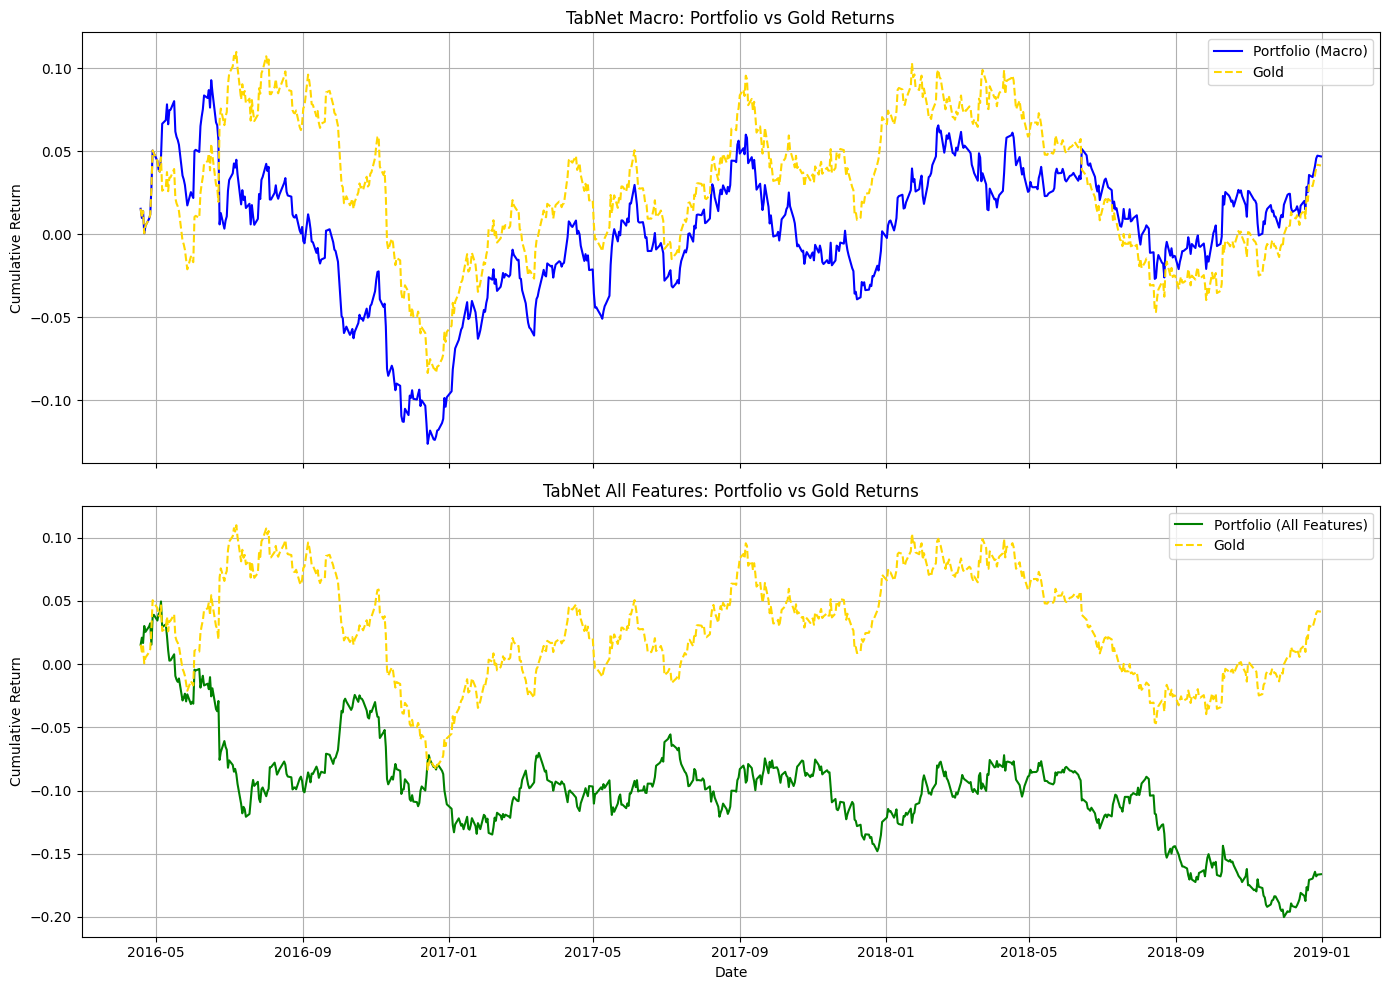

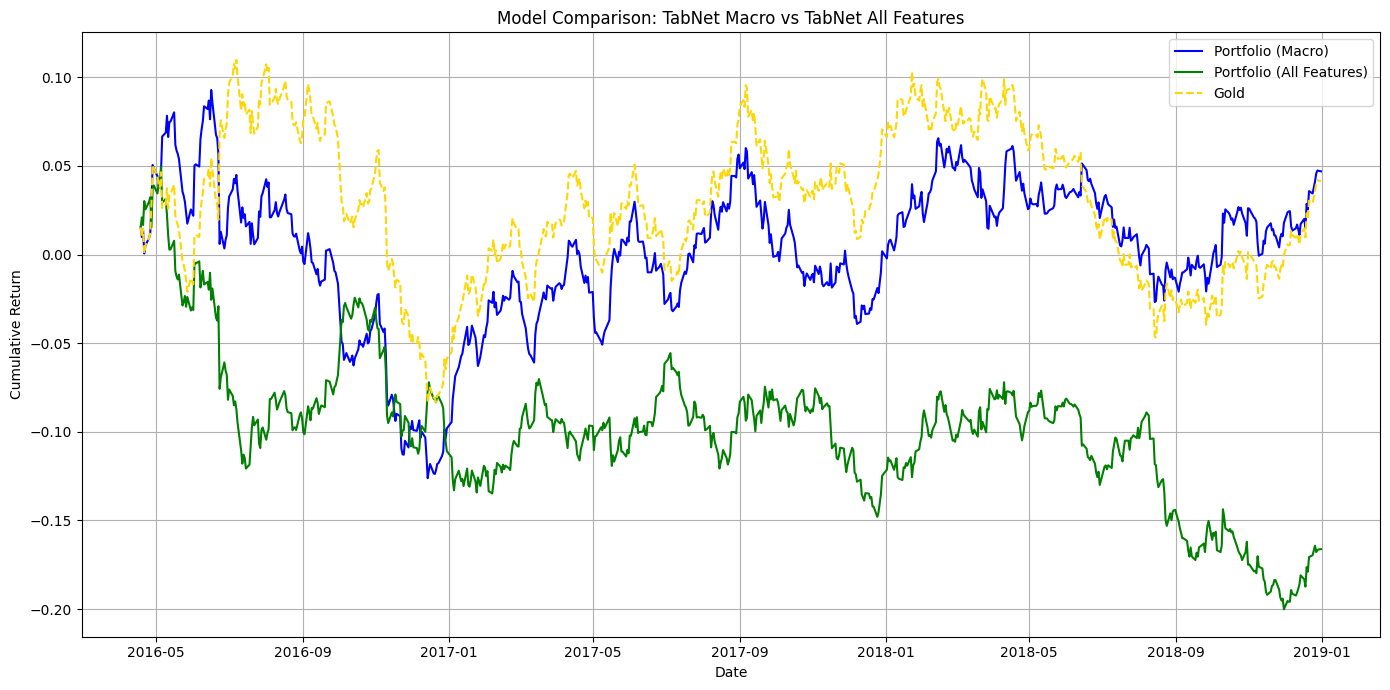


===== TabNet Portfolio Performance Summary =====
Model                Portfolio Return   Gold Return        Outperformance 
----------------------------------------------------------------------
TabNet Macro         0.0469             0.0414             0.0055         
TabNet All           -0.1662            0.0414             -0.2076        

Improvement from Macro to All Features: -0.2131 (-21.31%)


In [ ]:
#===============================================================================
# Portfolio Construction and Evaluation - TabNet Macro
#===============================================================================

start = 10

# Construct portfolio based on TabNet Macro model, starting from row 10
gold_prices_tabnet_macro = pd.DataFrame({
    'Date': test_df['Date'].iloc[start:],
    'gold_price_orginal': test_df['gold_price_orginal'].iloc[start:],
    'gold_price_lag': test_df['gold_price_lag'].iloc[start:],
    'gold_price_prediction_tabnet_macro': gold_price_prediction_tabnet_macro_test[start:]
})

# Reset index after slicing
gold_prices_tabnet_macro = gold_prices_tabnet_macro.reset_index(drop=True)

gold_prices_tabnet_macro['going_long_tabnet_macro'] = np.where(gold_prices_tabnet_macro['gold_price_prediction_tabnet_macro'] > 1 * gold_prices_tabnet_macro['gold_price_orginal'], 1, 0)
gold_prices_tabnet_macro['up'] = np.where(gold_prices_tabnet_macro['gold_price_lag'] > 1 * gold_prices_tabnet_macro['gold_price_orginal'], 1, 0)
gold_prices_tabnet_macro['correct_tabnet_macro'] = np.where(gold_prices_tabnet_macro['going_long_tabnet_macro'] == gold_prices_tabnet_macro['up'], 1, 0)
gold_prices_tabnet_macro['percentages_tabnet_macro'] = (gold_prices_tabnet_macro['gold_price_lag'] - gold_prices_tabnet_macro['gold_price_orginal']) / gold_prices_tabnet_macro['gold_price_orginal']
gold_prices_tabnet_macro['absolute_percentage_tabnet_macro'] = abs(gold_prices_tabnet_macro['percentages_tabnet_macro'])
gold_prices_tabnet_macro['portfolio_percentage_tabnet_macro'] = np.where(gold_prices_tabnet_macro['correct_tabnet_macro'] == 1, gold_prices_tabnet_macro['absolute_percentage_tabnet_macro'], -gold_prices_tabnet_macro['absolute_percentage_tabnet_macro'])
gold_prices_tabnet_macro['cum_return_portfolio_tabnet_macro'] = (1 + gold_prices_tabnet_macro['portfolio_percentage_tabnet_macro']).cumprod() - 1
gold_prices_tabnet_macro['cum_return_gold_tabnet_macro'] = (1 + gold_prices_tabnet_macro['percentages_tabnet_macro']).cumprod() - 1

# Calculate final returns for TabNet Macro
final_portfolio_return_tabnet_macro = gold_prices_tabnet_macro['cum_return_portfolio_tabnet_macro'].iloc[-1]
final_gold_return_tabnet_macro = gold_prices_tabnet_macro['cum_return_gold_tabnet_macro'].iloc[-1]

print("\n===== TabNet Macro Portfolio Evaluation =====")
print(f"Final Portfolio Return: {final_portfolio_return_tabnet_macro:.4f} ({final_portfolio_return_tabnet_macro*100:.2f}%)")
print(f"Final Gold Return: {final_gold_return_tabnet_macro:.4f} ({final_gold_return_tabnet_macro*100:.2f}%)")
print(f"Outperformance: {(final_portfolio_return_tabnet_macro - final_gold_return_tabnet_macro)*100:.2f}%")

# Print statistics for TabNet Macro
print("\nTabNet Macro Trading Statistics:")
series = pd.Series(gold_prices_tabnet_macro['correct_tabnet_macro'])
print("Correct:\n", series.value_counts(), "\n")

series = pd.Series(gold_prices_tabnet_macro['up'])
print("Up:\n", series.value_counts(), "\n")

series = pd.Series(gold_prices_tabnet_macro['going_long_tabnet_macro'])
print("Going Long:\n", series.value_counts(), "\n")

#===============================================================================
# Portfolio Construction and Evaluation - TabNet All Features
#===============================================================================

# Construct portfolio based on TabNet All Features model, starting from row 10
gold_prices_tabnet_all = pd.DataFrame({
    'Date': test_df['Date'].iloc[start:],
    'gold_price_orginal': test_df['gold_price_orginal'].iloc[start:],
    'gold_price_lag': test_df['gold_price_lag'].iloc[start:],
    'gold_price_prediction_tabnet_all': gold_price_prediction_tabnet_all_test[start:]
})

# Reset index after slicing
gold_prices_tabnet_all = gold_prices_tabnet_all.reset_index(drop=True)

gold_prices_tabnet_all['going_long_tabnet_all'] = np.where(gold_prices_tabnet_all['gold_price_prediction_tabnet_all'] > 1 * gold_prices_tabnet_all['gold_price_orginal'], 1, 0)
gold_prices_tabnet_all['up'] = np.where(gold_prices_tabnet_all['gold_price_lag'] > 1 * gold_prices_tabnet_all['gold_price_orginal'], 1, 0)
gold_prices_tabnet_all['correct_tabnet_all'] = np.where(gold_prices_tabnet_all['going_long_tabnet_all'] == gold_prices_tabnet_all['up'], 1, 0)
gold_prices_tabnet_all['percentages_tabnet_all'] = (gold_prices_tabnet_all['gold_price_lag'] - gold_prices_tabnet_all['gold_price_orginal']) / gold_prices_tabnet_all['gold_price_orginal']
gold_prices_tabnet_all['absolute_percentage_tabnet_all'] = abs(gold_prices_tabnet_all['percentages_tabnet_all'])
gold_prices_tabnet_all['portfolio_percentage_tabnet_all'] = np.where(gold_prices_tabnet_all['correct_tabnet_all'] == 1, gold_prices_tabnet_all['absolute_percentage_tabnet_all'], -gold_prices_tabnet_all['absolute_percentage_tabnet_all'])
gold_prices_tabnet_all['cum_return_portfolio_tabnet_all'] = (1 + gold_prices_tabnet_all['portfolio_percentage_tabnet_all']).cumprod() - 1
gold_prices_tabnet_all['cum_return_gold_tabnet_all'] = (1 + gold_prices_tabnet_all['percentages_tabnet_all']).cumprod() - 1

# Calculate final returns for TabNet All
final_portfolio_return_tabnet_all = gold_prices_tabnet_all['cum_return_portfolio_tabnet_all'].iloc[-1]
final_gold_return_tabnet_all = gold_prices_tabnet_all['cum_return_gold_tabnet_all'].iloc[-1]

print("\n===== TabNet All Features Portfolio Evaluation =====")
print(f"Final Portfolio Return: {final_portfolio_return_tabnet_all:.4f} ({final_portfolio_return_tabnet_all*100:.2f}%)")
print(f"Final Gold Return: {final_gold_return_tabnet_all:.4f} ({final_gold_return_tabnet_all*100:.2f}%)")
print(f"Outperformance: {(final_portfolio_return_tabnet_all - final_gold_return_tabnet_all)*100:.2f}%")

# Print statistics for TabNet All
print("\nTabNet All Features Trading Statistics:")
series = pd.Series(gold_prices_tabnet_all['correct_tabnet_all'])
print("Correct:\n", series.value_counts(), "\n")

series = pd.Series(gold_prices_tabnet_all['up'])
print("Up:\n", series.value_counts(), "\n")

series = pd.Series(gold_prices_tabnet_all['going_long_tabnet_all'])
print("Going Long:\n", series.value_counts(), "\n")

#===============================================================================
# Visualization - Portfolio vs Gold Returns for Both Models
#===============================================================================

# Set up the figure for two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot for TabNet Macro
ax1.plot(gold_prices_tabnet_macro['Date'], gold_prices_tabnet_macro['cum_return_portfolio_tabnet_macro'], label='Portfolio (Macro)', color='blue')
ax1.plot(gold_prices_tabnet_macro['Date'], gold_prices_tabnet_macro['cum_return_gold_tabnet_macro'], label='Gold', color='gold', linestyle='--')
ax1.set_ylabel('Cumulative Return')
ax1.set_title('TabNet Macro: Portfolio vs Gold Returns')
ax1.legend()
ax1.grid(True)

# Plot for TabNet All Features
ax2.plot(gold_prices_tabnet_all['Date'], gold_prices_tabnet_all['cum_return_portfolio_tabnet_all'], label='Portfolio (All Features)', color='green')
ax2.plot(gold_prices_tabnet_all['Date'], gold_prices_tabnet_all['cum_return_gold_tabnet_all'], label='Gold', color='gold', linestyle='--')
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Return')
ax2.set_title('TabNet All Features: Portfolio vs Gold Returns')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

#===============================================================================
# Visualization - Direct Comparison of Both Portfolios
#===============================================================================

plt.figure(figsize=(14, 7))

# Plot both portfolio returns on the same graph
plt.plot(gold_prices_tabnet_macro['Date'], gold_prices_tabnet_macro['cum_return_portfolio_tabnet_macro'], label='Portfolio (Macro)', color='blue')
plt.plot(gold_prices_tabnet_all['Date'], gold_prices_tabnet_all['cum_return_portfolio_tabnet_all'], label='Portfolio (All Features)', color='green')
plt.plot(gold_prices_tabnet_macro['Date'], gold_prices_tabnet_macro['cum_return_gold_tabnet_macro'], label='Gold', color='gold', linestyle='--')

# Add styling
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Model Comparison: TabNet Macro vs TabNet All Features')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#===============================================================================
# Consolidated Portfolio Performance Summary
#===============================================================================

print("\n===== TabNet Portfolio Performance Summary =====")
print(f"{'Model':<20} {'Portfolio Return':<18} {'Gold Return':<18} {'Outperformance':<15}")
print("-" * 70)
print(f"{'TabNet Macro':<20} {final_portfolio_return_tabnet_macro:<18.4f} {final_gold_return_tabnet_macro:<18.4f} {(final_portfolio_return_tabnet_macro - final_gold_return_tabnet_macro):<15.4f}")
print(f"{'TabNet All':<20} {final_portfolio_return_tabnet_all:<18.4f} {final_gold_return_tabnet_all:<18.4f} {(final_portfolio_return_tabnet_all - final_gold_return_tabnet_all):<15.4f}")

# Calculate model comparison
improvement_tabnet = final_portfolio_return_tabnet_all - final_portfolio_return_tabnet_macro
print(f"\nImprovement from Macro to All Features: {improvement_tabnet:.4f} ({improvement_tabnet*100:.2f}%)")

# Temporal Fusion Transformer

In [ ]:
#n_trials 2x
#max epochs 4x

#===============================================================================
# TFT Model - Macro Features with Optuna (Lookback Period 10)
#===============================================================================

# Create a time index if not already in your data
def prepare_data_for_tft_macro(X, y, time_idx_start=0):
    # Combine features and target
    data = X.copy()
    data['target'] = y

    # Add time index
    data['time_idx'] = np.arange(time_idx_start, time_idx_start + len(data))

    # Add group ID (for TFT, even with single time series)
    data['group_id'] = 0

    return data

# Prepare training and validation data for macro features
train_data_tft_macro = prepare_data_for_tft_macro(X_train_macro, y_train)
val_data_tft_macro = prepare_data_for_tft_macro(X_val_macro, y_val, time_idx_start=len(train_data_tft_macro))
test_data_tft_macro = prepare_data_for_tft_macro(X_test_macro, y_test, time_idx_start=len(train_data_tft_macro) + len(val_data_tft_macro))

# Get list of feature column names (exclude target, time_idx, and group_id)
feature_names_macro = [col for col in train_data_tft_macro.columns
                      if col not in ['target', 'time_idx', 'group_id']]

# Define the dataset parameters for macro
max_encoder_length_macro = 10  # Look back window (adjust based on your data)
max_prediction_length_macro = 1  # Predict 1 day ahead

# Use a different normalization approach for macro
target_normalizer_macro = GroupNormalizer(
    groups=["group_id"],
    transformation=None,  # Use no transformation
    scale_by_group=True
)

# Create the time series datasets for macro
training_cutoff_macro = train_data_tft_macro["time_idx"].max() - max_prediction_length_macro

# Define the objective function for Optuna - Macro
def objective_tft_macro(trial):
    # Categorical hyperparameters
    state_size = trial.suggest_categorical("state_size", [10, 20, 40, 80, 160, 240, 320])
    dropout_rate = trial.suggest_categorical("dropout_rate", [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9])
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])
    learning_rate = trial.suggest_categorical("learning_rate", [0.0001, 0.001, 0.01])
    max_gradient_norm = trial.suggest_categorical("max_gradient_norm", [0.01, 1.0, 100.0])
    num_heads = trial.suggest_categorical("num_heads", [1, 4])

    # Create datasets with the current batch size
    train_dataset_tft_macro = TimeSeriesDataSet(
        data=train_data_tft_macro,
        time_idx="time_idx",
        target="target",
        group_ids=["group_id"],
        max_encoder_length=max_encoder_length_macro,  # This is 10
        max_prediction_length=max_prediction_length_macro,
        static_categoricals=[],
        static_reals=[],
        time_varying_known_categoricals=[],
        time_varying_known_reals=feature_names_macro,
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=["target"],
        target_normalizer=target_normalizer_macro,
        add_relative_time_idx=True,
        add_target_scales=False,
        add_encoder_length=True,
    )

    val_dataset_tft_macro = TimeSeriesDataSet(
        data=val_data_tft_macro,
        time_idx="time_idx",
        target="target",
        group_ids=["group_id"],
        max_encoder_length=max_encoder_length_macro,  # This is 10
        max_prediction_length=max_prediction_length_macro,
        static_categoricals=[],
        static_reals=[],
        time_varying_known_categoricals=[],
        time_varying_known_reals=feature_names_macro,
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=["target"],
        target_normalizer=target_normalizer_macro,
        add_relative_time_idx=True,
        add_target_scales=False,
        add_encoder_length=True,
        min_prediction_idx=val_data_tft_macro['time_idx'].min() + max_encoder_length_macro,
        min_encoder_length=max_encoder_length_macro,
    )

    # Create data loaders
    train_dataloader_tft_macro = train_dataset_tft_macro.to_dataloader(train=True, batch_size=batch_size)
    val_dataloader_tft_macro = val_dataset_tft_macro.to_dataloader(train=False, batch_size=batch_size, shuffle=False)

    # Define the TFT model with trial hyperparameters
    tft_macro_trial = TemporalFusionTransformer.from_dataset(
        train_dataset_tft_macro,
        learning_rate=learning_rate,
        hidden_size=state_size,
        attention_head_size=num_heads,
        dropout=dropout_rate,
        hidden_continuous_size=state_size // 2,
        loss=QuantileLoss(),
        optimizer="adam",
        reduce_on_plateau_patience=4,
    )

    # Create trainer - FIXED: Removed LearningRateMonitor
    trainer_tft_macro_trial = pl.Trainer(
        max_epochs=5,  # Reduced for hyperparameter tuning
        accelerator="auto",
        devices="auto",
        gradient_clip_val=max_gradient_norm,
        limit_train_batches=0.5,  # Use 50% of data for faster training
        callbacks=[
            LightningEarlyStopping(monitor="val_loss", patience=3, mode="min"),
            # Removed LearningRateMonitor() to fix logger issue
            pl.callbacks.ModelCheckpoint(monitor="val_loss", mode="min"),
        ],
        logger=False,  # Disable logging for cleaner output
        enable_progress_bar=False,  # Disable progress bar
    )

    # Train the model
    trainer_tft_macro_trial.fit(
        model=tft_macro_trial,
        train_dataloaders=train_dataloader_tft_macro,
        val_dataloaders=val_dataloader_tft_macro,
    )

    # Get the validation loss
    val_loss = trainer_tft_macro_trial.callback_metrics.get("val_loss", float('inf'))
    if torch.is_tensor(val_loss):
        val_loss = val_loss.item()

    return val_loss

# Run the Optuna study for Macro
print("=== Optimizing TFT Macro Features (Lookback 10) ===")
study_tft_macro = optuna.create_study(direction="minimize")
study_tft_macro.optimize(objective_tft_macro, n_trials=30)  # Increased trials for better optimization

# Best parameters for Macro
print("Beste hyperparameters voor TFT Macro:", study_tft_macro.best_params)
print("Beste validation loss voor TFT Macro:", study_tft_macro.best_value)

#===============================================================================
# Train Final Macro Model with Best Parameters (Lookback 10)
#===============================================================================

best_params_macro = study_tft_macro.best_params

# Create final datasets with lookback 10
train_dataset_tft_macro_final = TimeSeriesDataSet(
    data=train_data_tft_macro,
    time_idx="time_idx",
    target="target",
    group_ids=["group_id"],
    max_encoder_length=max_encoder_length_macro,  # This is 10
    max_prediction_length=max_prediction_length_macro,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[],
    time_varying_known_reals=feature_names_macro,
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["target"],
    target_normalizer=target_normalizer_macro,
    add_relative_time_idx=True,
    add_target_scales=False,
    add_encoder_length=True,
)

val_dataset_tft_macro_final = TimeSeriesDataSet(
    data=val_data_tft_macro,
    time_idx="time_idx",
    target="target",
    group_ids=["group_id"],
    max_encoder_length=max_encoder_length_macro,  # This is 10
    max_prediction_length=max_prediction_length_macro,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[],
    time_varying_known_reals=feature_names_macro,
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["target"],
    target_normalizer=target_normalizer_macro,
    add_relative_time_idx=True,
    add_target_scales=False,
    add_encoder_length=True,
    min_prediction_idx=val_data_tft_macro['time_idx'].min() + max_encoder_length_macro,
    min_encoder_length=max_encoder_length_macro,
)

test_dataset_tft_macro_final = TimeSeriesDataSet(
    data=test_data_tft_macro,
    time_idx="time_idx",
    target="target",
    group_ids=["group_id"],
    max_encoder_length=max_encoder_length_macro,  # This is 10
    max_prediction_length=max_prediction_length_macro,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[],
    time_varying_known_reals=feature_names_macro,
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["target"],
    target_normalizer=target_normalizer_macro,
    add_relative_time_idx=True,
    add_target_scales=False,
    add_encoder_length=True,
    min_prediction_idx=test_data_tft_macro['time_idx'].min() + max_encoder_length_macro,
    min_encoder_length=max_encoder_length_macro,
)

# Create data loaders
train_dataloader_tft_macro_final = train_dataset_tft_macro_final.to_dataloader(
    train=True, batch_size=best_params_macro['batch_size'])
val_dataloader_tft_macro_final = val_dataset_tft_macro_final.to_dataloader(
    train=False, batch_size=best_params_macro['batch_size'], shuffle=False)
test_dataloader_tft_macro_final = test_dataset_tft_macro_final.to_dataloader(
    train=False, batch_size=best_params_macro['batch_size'], shuffle=False)

# Train final macro model
tft_macro_final = TemporalFusionTransformer.from_dataset(
    train_dataset_tft_macro_final,
    learning_rate=best_params_macro['learning_rate'],
    hidden_size=best_params_macro['state_size'],
    attention_head_size=best_params_macro['num_heads'],
    dropout=best_params_macro['dropout_rate'],
    hidden_continuous_size=best_params_macro['state_size'] // 2,
    loss=QuantileLoss(),
    optimizer="adam",
    reduce_on_plateau_patience=4,
)

trainer_tft_macro_final = pl.Trainer(
    max_epochs=30,  # Full training
    accelerator="auto",
    devices="auto",
    gradient_clip_val=best_params_macro['max_gradient_norm'],
    callbacks=[
        LightningEarlyStopping(monitor="val_loss", patience=5, mode="min"),
    ],
    logger=False,
    enable_progress_bar=True,
)

print("\n=== Training Final TFT Macro Model (Lookback 10) ===")
trainer_tft_macro_final.fit(
    model=tft_macro_final,
    train_dataloaders=train_dataloader_tft_macro_final,
    val_dataloaders=val_dataloader_tft_macro_final,
)

#===============================================================================
# TFT Model - All Features with Optuna (Lookback Period 10)
#===============================================================================

# Create a time index if not already in your data
def prepare_data_for_tft_all(X, y, time_idx_start=0):
    # Combine features and target
    data = X.copy()
    data['target'] = y

    # Add time index
    data['time_idx'] = np.arange(time_idx_start, time_idx_start + len(data))

    # Add group ID (for TFT, even with single time series)
    data['group_id'] = 0

    return data

# Prepare training and validation data for all features
train_data_tft_all = prepare_data_for_tft_all(X_train_all, y_train)
val_data_tft_all = prepare_data_for_tft_all(X_val_all, y_val, time_idx_start=len(train_data_tft_all))
test_data_tft_all = prepare_data_for_tft_all(X_test_all, y_test, time_idx_start=len(train_data_tft_all) + len(val_data_tft_all))

# Get list of feature column names (exclude target, time_idx, and group_id)
feature_names_all = [col for col in train_data_tft_all.columns
                    if col not in ['target', 'time_idx', 'group_id']]

# Define the dataset parameters for all features
max_encoder_length_all = 10  # Look back window (adjust based on your data)
max_prediction_length_all = 1  # Predict 1 day ahead

# Use a different normalization approach for all features
target_normalizer_all = GroupNormalizer(
    groups=["group_id"],
    transformation=None,  # Use no transformation
    scale_by_group=True
)

# Create the time series datasets for all features
training_cutoff_all = train_data_tft_all["time_idx"].max() - max_prediction_length_all

# Define the objective function for Optuna - All Features
def objective_tft_all(trial):
    # Categorical hyperparameters
    state_size = trial.suggest_categorical("state_size", [10, 20, 40, 80, 160, 240, 320])
    dropout_rate = trial.suggest_categorical("dropout_rate", [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9])
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])
    learning_rate = trial.suggest_categorical("learning_rate", [0.0001, 0.001, 0.01])
    max_gradient_norm = trial.suggest_categorical("max_gradient_norm", [0.01, 1.0, 100.0])
    num_heads = trial.suggest_categorical("num_heads", [1, 4])

    # Create datasets with the current batch size
    train_dataset_tft_all = TimeSeriesDataSet(
        data=train_data_tft_all,
        time_idx="time_idx",
        target="target",
        group_ids=["group_id"],
        max_encoder_length=max_encoder_length_all,  # This is 10
        max_prediction_length=max_prediction_length_all,
        static_categoricals=[],
        static_reals=[],
        time_varying_known_categoricals=[],
        time_varying_known_reals=feature_names_all,
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=["target"],
        target_normalizer=target_normalizer_all,
        add_relative_time_idx=True,
        add_target_scales=False,
        add_encoder_length=True,
    )

    val_dataset_tft_all = TimeSeriesDataSet(
        data=val_data_tft_all,
        time_idx="time_idx",
        target="target",
        group_ids=["group_id"],
        max_encoder_length=max_encoder_length_all,  # This is 10
        max_prediction_length=max_prediction_length_all,
        static_categoricals=[],
        static_reals=[],
        time_varying_known_categoricals=[],
        time_varying_known_reals=feature_names_all,
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=["target"],
        target_normalizer=target_normalizer_all,
        add_relative_time_idx=True,
        add_target_scales=False,
        add_encoder_length=True,
        min_prediction_idx=val_data_tft_all['time_idx'].min() + max_encoder_length_all,
        min_encoder_length=max_encoder_length_all,
    )

    # Create data loaders
    train_dataloader_tft_all = train_dataset_tft_all.to_dataloader(train=True, batch_size=batch_size)
    val_dataloader_tft_all = val_dataset_tft_all.to_dataloader(train=False, batch_size=batch_size, shuffle=False)

    # Define the TFT model with trial hyperparameters
    tft_all_trial = TemporalFusionTransformer.from_dataset(
        train_dataset_tft_all,
        learning_rate=learning_rate,
        hidden_size=state_size,
        attention_head_size=num_heads,
        dropout=dropout_rate,
        hidden_continuous_size=state_size // 2,
        loss=QuantileLoss(),
        optimizer="adam",
        reduce_on_plateau_patience=4,
    )

    # Create trainer - FIXED: Removed LearningRateMonitor
    trainer_tft_all_trial = pl.Trainer(
        max_epochs=5,  # Reduced for hyperparameter tuning
        accelerator="auto",
        devices="auto",
        gradient_clip_val=max_gradient_norm,
        limit_train_batches=0.5,  # Use 50% of data for faster training
        callbacks=[
            LightningEarlyStopping(monitor="val_loss", patience=3, mode="min"),
            # Removed LearningRateMonitor() to fix logger issue
            pl.callbacks.ModelCheckpoint(monitor="val_loss", mode="min"),
        ],
        logger=False,  # Disable logging for cleaner output
        enable_progress_bar=False,  # Disable progress bar
    )

    # Train the model
    trainer_tft_all_trial.fit(
        model=tft_all_trial,
        train_dataloaders=train_dataloader_tft_all,
        val_dataloaders=val_dataloader_tft_all,
    )

    # Get the validation loss
    val_loss = trainer_tft_all_trial.callback_metrics.get("val_loss", float('inf'))
    if torch.is_tensor(val_loss):
        val_loss = val_loss.item()

    return val_loss

# Run the Optuna study for All Features
print("\n=== Optimizing TFT All Features (Lookback 10) ===")
study_tft_all = optuna.create_study(direction="minimize")
study_tft_all.optimize(objective_tft_all, n_trials=30)  # Increased trials for better optimization

# Best parameters for All Features
print("Beste hyperparameters voor TFT All:", study_tft_all.best_params)
print("Beste validation loss voor TFT All:", study_tft_all.best_value)

#===============================================================================
# Train Final All Features Model with Best Parameters (Lookback 10)
#===============================================================================

best_params_all = study_tft_all.best_params

# Create final datasets with lookback 10
train_dataset_tft_all_final = TimeSeriesDataSet(
    data=train_data_tft_all,
    time_idx="time_idx",
    target="target",
    group_ids=["group_id"],
    max_encoder_length=max_encoder_length_all,  # This is 10
    max_prediction_length=max_prediction_length_all,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[],
    time_varying_known_reals=feature_names_all,
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["target"],
    target_normalizer=target_normalizer_all,
    add_relative_time_idx=True,
    add_target_scales=False,
    add_encoder_length=True,
)

val_dataset_tft_all_final = TimeSeriesDataSet(
    data=val_data_tft_all,
    time_idx="time_idx",
    target="target",
    group_ids=["group_id"],
    max_encoder_length=max_encoder_length_all,  # This is 10
    max_prediction_length=max_prediction_length_all,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[],
    time_varying_known_reals=feature_names_all,
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["target"],
    target_normalizer=target_normalizer_all,
    add_relative_time_idx=True,
    add_target_scales=False,
    add_encoder_length=True,
    min_prediction_idx=val_data_tft_all['time_idx'].min() + max_encoder_length_all,
    min_encoder_length=max_encoder_length_all,
)

test_dataset_tft_all_final = TimeSeriesDataSet(
    data=test_data_tft_all,
    time_idx="time_idx",
    target="target",
    group_ids=["group_id"],
    max_encoder_length=max_encoder_length_all,  # This is 10
    max_prediction_length=max_prediction_length_all,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[],
    time_varying_known_reals=feature_names_all,
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["target"],
    target_normalizer=target_normalizer_all,
    add_relative_time_idx=True,
    add_target_scales=False,
    add_encoder_length=True,
    min_prediction_idx=test_data_tft_all['time_idx'].min() + max_encoder_length_all,
    min_encoder_length=max_encoder_length_all,
)

# Create data loaders
train_dataloader_tft_all_final = train_dataset_tft_all_final.to_dataloader(
    train=True, batch_size=best_params_all['batch_size'])
val_dataloader_tft_all_final = val_dataset_tft_all_final.to_dataloader(
    train=False, batch_size=best_params_all['batch_size'], shuffle=False)
test_dataloader_tft_all_final = test_dataset_tft_all_final.to_dataloader(
    train=False, batch_size=best_params_all['batch_size'], shuffle=False)

# Train final all features model
tft_all_final = TemporalFusionTransformer.from_dataset(
    train_dataset_tft_all_final,
    learning_rate=best_params_all['learning_rate'],
    hidden_size=best_params_all['state_size'],
    attention_head_size=best_params_all['num_heads'],
    dropout=best_params_all['dropout_rate'],
    hidden_continuous_size=best_params_all['state_size'] // 2,
    loss=QuantileLoss(),
    optimizer="adam",
    reduce_on_plateau_patience=4,
)

trainer_tft_all_final = pl.Trainer(
    max_epochs=30,  # Full training
    accelerator="auto",
    devices="auto",
    gradient_clip_val=best_params_all['max_gradient_norm'],
    callbacks=[
        LightningEarlyStopping(monitor="val_loss", patience=5, mode="min"),
    ],
    logger=False,
    enable_progress_bar=True,
)

print("\n=== Training Final TFT All Features Model (Lookback 10) ===")
trainer_tft_all_final.fit(
    model=tft_all_final,
    train_dataloaders=train_dataloader_tft_all_final,
    val_dataloaders=val_dataloader_tft_all_final,
)

#===============================================================================
# Make Predictions and Evaluate (Using Final Models with Lookback 10)
#===============================================================================

# Use the final models for predictions
tft_macro = tft_macro_final
tft_all = tft_all_final

# These are the dataloaders with lookback 10
train_dataloader_tft_macro = train_dataloader_tft_macro_final
val_dataloader_tft_macro = val_dataloader_tft_macro_final
test_dataloader_tft_macro = test_dataloader_tft_macro_final

train_dataloader_tft_all = train_dataloader_tft_all_final
val_dataloader_tft_all = val_dataloader_tft_all_final
test_dataloader_tft_all = test_dataloader_tft_all_final

print("\n" + "="*50)
print("TFT Training Complete with Lookback Period = 10")
print("="*50)
print(f"Best hyperparameters (Macro): {best_params_macro}")
print(f"Best hyperparameters (All): {best_params_all}")
print("Ready for predictions and evaluation")
print("="*50)

[I 2025-05-13 23:41:40,068] A new study created in memory with name: no-name-5e726058-ab21-442f-be4d-2641d67f0b95


=== Optimizing TFT Macro Features (Lookback 10) ===


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
   | Name                               | Type                            | Params |

Beste hyperparameters voor TFT Macro: {'state_size': 20, 'dropout_rate': 0.2, 'batch_size': 64, 'learning_rate': 0.01, 'max_gradient_norm': 0.01, 'num_heads': 4}
Beste validation loss voor TFT Macro: 0.004106667824089527


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU availabl


=== Training Final TFT Macro Model (Lookback 10) ===


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-14 00:37:18,735] A new study created in memory with name: no-name-b273516e-ca7c-49ba-a2c4-9ff6e9007766



=== Optimizing TFT All Features (Lookback 10) ===


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654

Beste hyperparameters voor TFT All: {'state_size': 320, 'dropout_rate': 0.2, 'batch_size': 128, 'learning_rate': 0.0001, 'max_gradient_norm': 1.0, 'num_heads': 4}
Beste validation loss voor TFT All: 0.004136492032557726


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU availabl


=== Training Final TFT All Features Model (Lookback 10) ===


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


TFT Training Complete with Lookback Period = 10
Best hyperparameters (Macro): {'state_size': 20, 'dropout_rate': 0.2, 'batch_size': 64, 'learning_rate': 0.01, 'max_gradient_norm': 0.01, 'num_heads': 4}
Best hyperparameters (All): {'state_size': 320, 'dropout_rate': 0.2, 'batch_size': 128, 'learning_rate': 0.0001, 'max_gradient_norm': 1.0, 'num_heads': 4}
Ready for predictions and evaluation


In [ ]:
#===============================================================================
# Make predictions with TFT - Macro Features
#===============================================================================
y_pred_train_tft_macro = tft_macro.predict(train_dataloader_tft_macro).detach().cpu().numpy()
y_pred_val_tft_macro = tft_macro.predict(val_dataloader_tft_macro).detach().cpu().numpy()
y_pred_test_tft_macro = tft_macro.predict(test_dataloader_tft_macro).detach().cpu().numpy()

#===============================================================================
# Calculate MSE - Macro Features
#===============================================================================
mse_train_tft_macro = mean_squared_error(y_train[max_encoder_length_macro:], y_pred_train_tft_macro)
mse_val_tft_macro = mean_squared_error(y_val[max_encoder_length_macro:], y_pred_val_tft_macro)
mse_test_tft_macro = mean_squared_error(y_test[max_encoder_length_macro:], y_pred_test_tft_macro)

#===============================================================================
# Calculate MAE - Macro Features
#===============================================================================
mae_train_tft_macro = mean_absolute_error(y_train[max_encoder_length_macro:], y_pred_train_tft_macro)
mae_val_tft_macro = mean_absolute_error(y_val[max_encoder_length_macro:], y_pred_val_tft_macro)
mae_test_tft_macro = mean_absolute_error(y_test[max_encoder_length_macro:], y_pred_test_tft_macro)

#===============================================================================
# Calculate R-squared (R²) - Macro Features
#===============================================================================
r2_train_tft_macro = r2_score(y_train[max_encoder_length_macro:], y_pred_train_tft_macro)
r2_val_tft_macro = r2_score(y_val[max_encoder_length_macro:], y_pred_val_tft_macro)
r2_test_tft_macro = r2_score(y_test[max_encoder_length_macro:], y_pred_test_tft_macro)

#===============================================================================
# Save Results - Macro Features
#===============================================================================
results_tft_macro_ret = pd.DataFrame({
    'Metric': ['R2', 'MSE', 'MAE'],
    'Train': [r2_train_tft_macro, mse_train_tft_macro, mae_train_tft_macro],
    'Val': [r2_val_tft_macro, mse_val_tft_macro, mae_val_tft_macro],
    'Test': [r2_test_tft_macro, mse_test_tft_macro, mae_test_tft_macro]
})

print("TFT Macro - Relative Returns:")
print(results_tft_macro_ret)

#===============================================================================
# Results on Original Gold Price - Macro Features
#===============================================================================
gold_price_prediction_tft_macro_train = ((y_pred_train_tft_macro.flatten() + 1) * train_df['gold_price'][max_encoder_length_macro:].values)
gold_price_prediction_tft_macro_val = ((y_pred_val_tft_macro.flatten() + 1) * val_df['gold_price'][max_encoder_length_macro:].values)
gold_price_prediction_tft_macro_test = ((y_pred_test_tft_macro.flatten() + 1) * test_df['gold_price'][max_encoder_length_macro:].values)

#===============================================================================
# MSE on original gold price - Macro Features
#===============================================================================
mse_train_tft_macro_abs = mean_squared_error(train_df['gold_price'][max_encoder_length_macro:], gold_price_prediction_tft_macro_train)
mse_val_tft_macro_abs = mean_squared_error(val_df['gold_price'][max_encoder_length_macro:], gold_price_prediction_tft_macro_val)
mse_test_tft_macro_abs = mean_squared_error(test_df['gold_price'][max_encoder_length_macro:], gold_price_prediction_tft_macro_test)

#===============================================================================
# MAE on original gold price - Macro Features
#===============================================================================
mae_train_tft_macro_abs = mean_absolute_error(train_df['gold_price'][max_encoder_length_macro:], gold_price_prediction_tft_macro_train)
mae_val_tft_macro_abs = mean_absolute_error(val_df['gold_price'][max_encoder_length_macro:], gold_price_prediction_tft_macro_val)
mae_test_tft_macro_abs = mean_absolute_error(test_df['gold_price'][max_encoder_length_macro:], gold_price_prediction_tft_macro_test)

#===============================================================================
# R2 original gold price - Macro Features
#===============================================================================
r2_train_tft_macro_abs = r2_score(train_df['gold_price'][max_encoder_length_macro:], gold_price_prediction_tft_macro_train)
r2_val_tft_macro_abs = r2_score(val_df['gold_price'][max_encoder_length_macro:], gold_price_prediction_tft_macro_val)
r2_test_tft_macro_abs = r2_score(test_df['gold_price'][max_encoder_length_macro:], gold_price_prediction_tft_macro_test)

#===============================================================================
# Save results - Macro Features
#===============================================================================
results_tft_macro_abs = pd.DataFrame({
    'Metric': ['R2', 'MSE', 'MAE'],
    'Train': [r2_train_tft_macro_abs, mse_train_tft_macro_abs, mae_train_tft_macro_abs],
    'Val': [r2_val_tft_macro_abs, mse_val_tft_macro_abs, mae_val_tft_macro_abs],
    'Test': [r2_test_tft_macro_abs, mse_test_tft_macro_abs, mae_test_tft_macro_abs]
})

print("\nTFT Macro - Original Gold Price:")
print(results_tft_macro_abs)

#===============================================================================
# Make predictions with TFT - All Features
#===============================================================================
y_pred_train_tft_all = tft_all.predict(train_dataloader_tft_all).detach().cpu().numpy()
y_pred_val_tft_all = tft_all.predict(val_dataloader_tft_all).detach().cpu().numpy()
y_pred_test_tft_all = tft_all.predict(test_dataloader_tft_all).detach().cpu().numpy()

#===============================================================================
# Calculate MSE - All Features
#===============================================================================
mse_train_tft_all = mean_squared_error(y_train[max_encoder_length_all:], y_pred_train_tft_all)
mse_val_tft_all = mean_squared_error(y_val[max_encoder_length_all:], y_pred_val_tft_all)
mse_test_tft_all = mean_squared_error(y_test[max_encoder_length_all:], y_pred_test_tft_all)

#===============================================================================
# Calculate MAE - All Features
#===============================================================================
mae_train_tft_all = mean_absolute_error(y_train[max_encoder_length_all:], y_pred_train_tft_all)
mae_val_tft_all = mean_absolute_error(y_val[max_encoder_length_all:], y_pred_val_tft_all)
mae_test_tft_all = mean_absolute_error(y_test[max_encoder_length_all:], y_pred_test_tft_all)

#===============================================================================
# Calculate R-squared (R²) - All Features
#===============================================================================
r2_train_tft_all = r2_score(y_train[max_encoder_length_all:], y_pred_train_tft_all)
r2_val_tft_all = r2_score(y_val[max_encoder_length_all:], y_pred_val_tft_all)
r2_test_tft_all = r2_score(y_test[max_encoder_length_all:], y_pred_test_tft_all)

#===============================================================================
# Save Results - All Features
#===============================================================================
results_tft_all_ret = pd.DataFrame({
    'Metric': ['R2', 'MSE', 'MAE'],
    'Train': [r2_train_tft_all, mse_train_tft_all, mae_train_tft_all],
    'Val': [r2_val_tft_all, mse_val_tft_all, mae_val_tft_all],
    'Test': [r2_test_tft_all, mse_test_tft_all, mae_test_tft_all]
})

print("\nTFT All - Relative Returns:")
print(results_tft_all_ret)

#===============================================================================
# Results on Original Gold Price - All Features
#===============================================================================
gold_price_prediction_tft_all_train = ((y_pred_train_tft_all.flatten() + 1) * train_df['gold_price'][max_encoder_length_all:].values)
gold_price_prediction_tft_all_val = ((y_pred_val_tft_all.flatten() + 1) * val_df['gold_price'][max_encoder_length_all:].values)
gold_price_prediction_tft_all_test = ((y_pred_test_tft_all.flatten() + 1) * test_df['gold_price'][max_encoder_length_all:].values)

#===============================================================================
# MSE on original gold price - All Features
#===============================================================================
mse_train_tft_all_abs = mean_squared_error(train_df['gold_price'][max_encoder_length_all:], gold_price_prediction_tft_all_train)
mse_val_tft_all_abs = mean_squared_error(val_df['gold_price'][max_encoder_length_all:], gold_price_prediction_tft_all_val)
mse_test_tft_all_abs = mean_squared_error(test_df['gold_price'][max_encoder_length_all:], gold_price_prediction_tft_all_test)

#===============================================================================
# MAE on original gold price - All Features
#===============================================================================
mae_train_tft_all_abs = mean_absolute_error(train_df['gold_price'][max_encoder_length_all:], gold_price_prediction_tft_all_train)
mae_val_tft_all_abs = mean_absolute_error(val_df['gold_price'][max_encoder_length_all:], gold_price_prediction_tft_all_val)
mae_test_tft_all_abs = mean_absolute_error(test_df['gold_price'][max_encoder_length_all:], gold_price_prediction_tft_all_test)

#===============================================================================
# R2 original gold price - All Features
#===============================================================================
r2_train_tft_all_abs = r2_score(train_df['gold_price'][max_encoder_length_all:], gold_price_prediction_tft_all_train)
r2_val_tft_all_abs = r2_score(val_df['gold_price'][max_encoder_length_all:], gold_price_prediction_tft_all_val)
r2_test_tft_all_abs = r2_score(test_df['gold_price'][max_encoder_length_all:], gold_price_prediction_tft_all_test)

#===============================================================================
# Save results - All Features
#===============================================================================
results_tft_all_abs = pd.DataFrame({
    'Metric': ['R2', 'MSE', 'MAE'],
    'Train': [r2_train_tft_all_abs, mse_train_tft_all_abs, mae_train_tft_all_abs],
    'Val': [r2_val_tft_all_abs, mse_val_tft_all_abs, mae_val_tft_all_abs],
    'Test': [r2_test_tft_all_abs, mse_test_tft_all_abs, mae_test_tft_all_abs]
})

print("\nTFT All - Original Gold Price:")
print(results_tft_all_abs)

#===============================================================================
# Model Comparison
#===============================================================================

# Compare return prediction performance
comparison_tft_ret = pd.DataFrame({
    'Metric': ['R2', 'MSE', 'MAE'],
    'TFT Macro (Train)': [r2_train_tft_macro, mse_train_tft_macro, mae_train_tft_macro],
    'TFT All (Train)': [r2_train_tft_all, mse_train_tft_all, mae_train_tft_all],
    'TFT Macro (Test)': [r2_test_tft_macro, mse_test_tft_macro, mae_test_tft_macro],
    'TFT All (Test)': [r2_test_tft_all, mse_test_tft_all, mae_test_tft_all]
})

print("\nComparison of Return Prediction Performance:")
print(comparison_tft_ret)

# Compare gold price prediction performance
comparison_tft_gold = pd.DataFrame({
    'Metric': ['R2', 'MSE', 'MAE'],
    'TFT Macro (Train)': [r2_train_tft_macro_abs, mse_train_tft_macro_abs, mae_train_tft_macro_abs],
    'TFT All (Train)': [r2_train_tft_all_abs, mse_train_tft_all_abs, mae_train_tft_all_abs],
    'TFT Macro (Test)': [r2_test_tft_macro_abs, mse_test_tft_macro_abs, mae_test_tft_macro_abs],
    'TFT All (Test)': [r2_test_tft_all_abs, mse_test_tft_all_abs, mae_test_tft_all_abs]
})

print("\nComparison of Gold Price Prediction Performance:")
print(comparison_tft_gold)

# Calculate improvement percentage
r2_improvement_tft_ret = ((r2_test_tft_all - r2_test_tft_macro) / abs(r2_test_tft_macro)) * 100 if r2_test_tft_macro != 0 else float('inf')
mse_improvement_tft_ret = ((mse_test_tft_macro - mse_test_tft_all) / mse_test_tft_macro) * 100
mae_improvement_tft_ret = ((mae_test_tft_macro - mae_test_tft_all) / mae_test_tft_macro) * 100

print("\nImprovement with Sentiment Features:")
print(f"Return R² Improvement: {r2_improvement_tft_ret:.2f}%")
print(f"Return MSE Improvement: {mse_improvement_tft_ret:.2f}%")
print(f"Return MAE Improvement: {mae_improvement_tft_ret:.2f}%")

r2_improvement_tft_gold = ((r2_test_tft_all_abs - r2_test_tft_macro_abs) / abs(r2_test_tft_macro_abs)) * 100 if r2_test_tft_macro_abs != 0 else float('inf')
mse_improvement_tft_gold = ((mse_test_tft_macro_abs - mse_test_tft_all_abs) / mse_test_tft_macro_abs) * 100
mae_improvement_tft_gold = ((mae_test_tft_macro_abs - mae_test_tft_all_abs) / mae_test_tft_macro_abs) * 100

print(f"Gold Price R² Improvement: {r2_improvement_tft_gold:.2f}%")
print(f"Gold Price MSE Improvement: {mse_improvement_tft_gold:.2f}%")
print(f"Gold Price MAE Improvement: {mae_improvement_tft_gold:.2f}%")

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:476: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
INFO: Using default `Model

TFT Macro - Relative Returns:
  Metric     Train       Val      Test
0     R2 -0.011193 -0.015985 -0.015135
1    MSE  0.000140  0.000097  0.000051
2    MAE  0.008397  0.007343  0.005271

TFT Macro - Original Gold Price:
  Metric     Train       Val      Test
0     R2  0.999992  0.999424  0.998677
1    MSE  1.845144  3.761493  3.403702
2    MAE  0.921246  1.536983  1.467717


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:476: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Using default `Model


TFT All - Relative Returns:
  Metric     Train       Val      Test
0     R2 -0.005387 -0.007765 -0.007378
1    MSE  0.000139  0.000097  0.000050
2    MAE  0.008394  0.007232  0.005229

TFT All - Original Gold Price:
  Metric     Train       Val      Test
0     R2  0.999996  0.999704  0.999288
1    MSE  1.015559  1.932827  1.832366
2    MAE  0.552940  0.962871  0.908015

Comparison of Return Prediction Performance:
  Metric  TFT Macro (Train)  TFT All (Train)  TFT Macro (Test)  TFT All (Test)
0     R2          -0.011193        -0.005387         -0.015135       -0.007378
1    MSE           0.000140         0.000139          0.000051        0.000050
2    MAE           0.008397         0.008394          0.005271        0.005229

Comparison of Gold Price Prediction Performance:
  Metric  TFT Macro (Train)  TFT All (Train)  TFT Macro (Test)  TFT All (Test)
0     R2           0.999992         0.999996          0.998677        0.999288
1    MSE           1.845144         1.015559          3.4

=== TFT Macro Portfolio ===
                          Date  gold_price_orginal_tft_macro  \
2261 2016-04-18 00:00:00+00:00                       1231.15   
2260 2016-04-19 00:00:00+00:00                       1250.10   
2259 2016-04-20 00:00:00+00:00                       1243.30   
2258 2016-04-21 00:00:00+00:00                       1248.46   
2257 2016-04-22 00:00:00+00:00                       1231.91   
...                        ...                           ...   
1564 2018-12-24 00:00:00+00:00                       1268.49   
1563 2018-12-26 00:00:00+00:00                       1266.90   
1562 2018-12-27 00:00:00+00:00                       1275.13   
1561 2018-12-28 00:00:00+00:00                       1280.67   
1560 2018-12-31 00:00:00+00:00                       1282.73   

      gold_price_lag_tft_macro  gold_price_pred_tft_macro  \
2261                   1250.10                1232.128479   
2260                   1243.30                1249.711421   
2259                

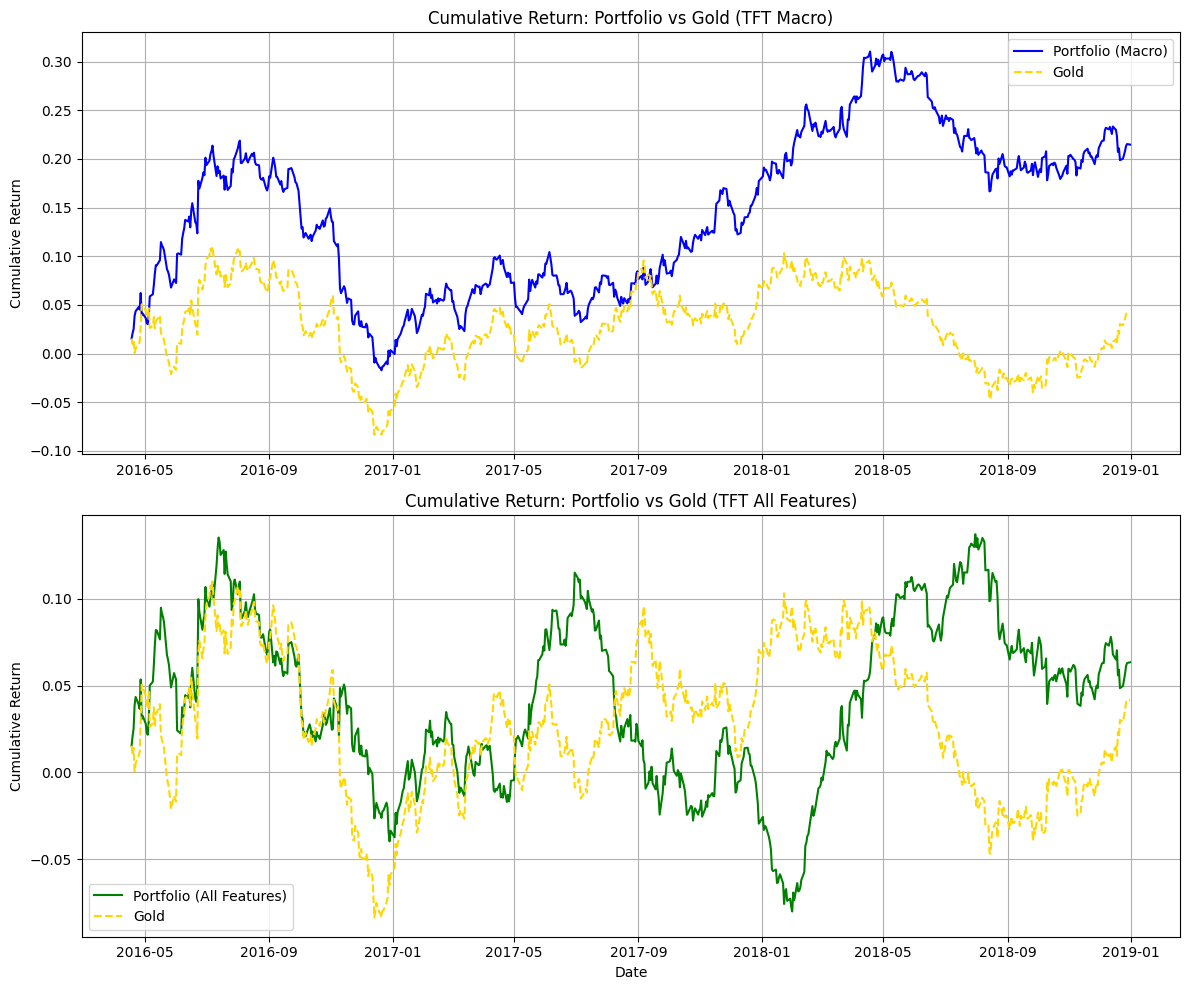


=== TFT Macro Statistics ===
Correct:
 correct_tft_macro
1    369
0    333
Name: count, dtype: int64 

Up:
 up_tft_macro
1    364
0    338
Name: count, dtype: int64 

Going Long:
 going_long_tft_macro
1    587
0    115
Name: count, dtype: int64 


=== TFT All Features Statistics ===
Correct:
 correct_tft_all
1    360
0    342
Name: count, dtype: int64 

Up:
 up_tft_all
1    364
0    338
Name: count, dtype: int64 

Going Long:
 going_long_tft_all
1    414
0    288
Name: count, dtype: int64 


=== TFT Performance Summary ===
Model                Portfolio Return   Gold Return        Outperformance 
----------------------------------------------------------------------
TFT Macro            0.2147             0.0414             0.1733         
TFT All              0.0634             0.0414             0.0220         

Improvement from Macro to All Features: -0.1513 (-15.13%)


In [ ]:
#===============================================================================
# Portfolio Construction and Evaluation - TFT Macro
#===============================================================================

# Create DataFrame voor TFT Macro
gold_prices_tft_macro = pd.DataFrame({
    'Date': test_df['Date'][max_encoder_length_macro:],  # Skip first rows of Date
    'gold_price_orginal_tft_macro': test_df['gold_price'][max_encoder_length_macro:],
    'gold_price_lag_tft_macro': test_df['gold_price_lag'][max_encoder_length_macro:],
    'gold_price_pred_tft_macro': gold_price_prediction_tft_macro_test
})

gold_prices_tft_macro['going_long_tft_macro'] = np.where(gold_prices_tft_macro['gold_price_pred_tft_macro'] > 1 * gold_prices_tft_macro['gold_price_orginal_tft_macro'], 1, 0)
gold_prices_tft_macro['up_tft_macro'] = np.where(gold_prices_tft_macro['gold_price_lag_tft_macro'] > 1 * gold_prices_tft_macro['gold_price_orginal_tft_macro'], 1, 0)
gold_prices_tft_macro['correct_tft_macro'] = np.where(gold_prices_tft_macro['going_long_tft_macro'] == gold_prices_tft_macro['up_tft_macro'], 1, 0)
gold_prices_tft_macro['percentages_tft_macro'] = (gold_prices_tft_macro['gold_price_lag_tft_macro'] - gold_prices_tft_macro['gold_price_orginal_tft_macro']) / gold_prices_tft_macro['gold_price_orginal_tft_macro']
gold_prices_tft_macro['absolute_percentage_tft_macro'] = abs(gold_prices_tft_macro['percentages_tft_macro'])
gold_prices_tft_macro['portfolio_percentage_tft_macro'] = np.where(gold_prices_tft_macro['correct_tft_macro'] == 1, gold_prices_tft_macro['absolute_percentage_tft_macro'], -gold_prices_tft_macro['absolute_percentage_tft_macro'])
gold_prices_tft_macro['cum_return_portfolio_tft_macro'] = (1 + gold_prices_tft_macro['portfolio_percentage_tft_macro']).cumprod() - 1
gold_prices_tft_macro['cum_return_gold_tft_macro'] = (1 + gold_prices_tft_macro['percentages_tft_macro']).cumprod() - 1

print("=== TFT Macro Portfolio ===")
print(gold_prices_tft_macro)

#===============================================================================
# Portfolio Construction and Evaluation - TFT All Features
#===============================================================================

# Create DataFrame voor TFT All
gold_prices_tft_all = pd.DataFrame({
    'Date': test_df['Date'][max_encoder_length_all:],  # Skip first rows of Date
    'gold_price_orginal_tft_all': test_df['gold_price'][max_encoder_length_all:],
    'gold_price_lag_tft_all': test_df['gold_price_lag'][max_encoder_length_all:],
    'gold_price_pred_tft_all': gold_price_prediction_tft_all_test
})

gold_prices_tft_all['going_long_tft_all'] = np.where(gold_prices_tft_all['gold_price_pred_tft_all'] > 1 * gold_prices_tft_all['gold_price_orginal_tft_all'], 1, 0)
gold_prices_tft_all['up_tft_all'] = np.where(gold_prices_tft_all['gold_price_lag_tft_all'] > 1 * gold_prices_tft_all['gold_price_orginal_tft_all'], 1, 0)
gold_prices_tft_all['correct_tft_all'] = np.where(gold_prices_tft_all['going_long_tft_all'] == gold_prices_tft_all['up_tft_all'], 1, 0)
gold_prices_tft_all['percentages_tft_all'] = (gold_prices_tft_all['gold_price_lag_tft_all'] - gold_prices_tft_all['gold_price_orginal_tft_all']) / gold_prices_tft_all['gold_price_orginal_tft_all']
gold_prices_tft_all['absolute_percentage_tft_all'] = abs(gold_prices_tft_all['percentages_tft_all'])
gold_prices_tft_all['portfolio_percentage_tft_all'] = np.where(gold_prices_tft_all['correct_tft_all'] == 1, gold_prices_tft_all['absolute_percentage_tft_all'], -gold_prices_tft_all['absolute_percentage_tft_all'])
gold_prices_tft_all['cum_return_portfolio_tft_all'] = (1 + gold_prices_tft_all['portfolio_percentage_tft_all']).cumprod() - 1
gold_prices_tft_all['cum_return_gold_tft_all'] = (1 + gold_prices_tft_all['percentages_tft_all']).cumprod() - 1

print("\n=== TFT All Features Portfolio ===")
print(gold_prices_tft_all)

#===============================================================================
# Visualisatie: Plot cumulatieve returns
#===============================================================================
import matplotlib.pyplot as plt

# Create subplots for both models
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot voor TFT Macro
ax1.plot(gold_prices_tft_macro['Date'], gold_prices_tft_macro['cum_return_portfolio_tft_macro'], label='Portfolio (Macro)', color='blue')
ax1.plot(gold_prices_tft_macro['Date'], gold_prices_tft_macro['cum_return_gold_tft_macro'], label='Gold', linestyle='--', color='gold')
ax1.set_ylabel('Cumulative Return')
ax1.set_title('Cumulative Return: Portfolio vs Gold (TFT Macro)')
ax1.legend()
ax1.grid(True)

# Plot voor TFT All Features
ax2.plot(gold_prices_tft_all['Date'], gold_prices_tft_all['cum_return_portfolio_tft_all'], label='Portfolio (All Features)', color='green')
ax2.plot(gold_prices_tft_all['Date'], gold_prices_tft_all['cum_return_gold_tft_all'], label='Gold', linestyle='--', color='gold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Return')
ax2.set_title('Cumulative Return: Portfolio vs Gold (TFT All Features)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

#===============================================================================
# Direct comparison between both TFT portfolios
#===============================================================================
plt.figure(figsize=(12, 6))

# Plot beide portfolio returns op dezelfde grafiek
plt.plot(gold_prices_tft_macro['Date'], gold_prices_tft_macro['cum_return_portfolio_tft_macro'], label='Portfolio (Macro)', color='blue')
plt.plot(gold_prices_tft_all['Date'], gold_prices_tft_all['cum_return_portfolio_tft_all'], label='Portfolio (All Features)', color='green')
plt.plot(gold_prices_tft_macro['Date'], gold_prices_tft_macro['cum_return_gold_tft_macro'], label='Gold', linestyle='--', color='gold')

# Extra opmaak
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('TFT Model Comparison: Macro vs All Features')
plt.legend()
plt.grid(True)
plt.show()

#===============================================================================
# Print statistics for TFT Macro
#===============================================================================
print("\n=== TFT Macro Statistics ===")
series = pd.Series(gold_prices_tft_macro['correct_tft_macro'])
print("Correct:\n", series.value_counts(), "\n")

series = pd.Series(gold_prices_tft_macro['up_tft_macro'])
print("Up:\n", series.value_counts(), "\n")

series = pd.Series(gold_prices_tft_macro['going_long_tft_macro'])
print("Going Long:\n", series.value_counts(), "\n")

#===============================================================================
# Print statistics for TFT All Features
#===============================================================================
print("\n=== TFT All Features Statistics ===")
series = pd.Series(gold_prices_tft_all['correct_tft_all'])
print("Correct:\n", series.value_counts(), "\n")

series = pd.Series(gold_prices_tft_all['up_tft_all'])
print("Up:\n", series.value_counts(), "\n")

series = pd.Series(gold_prices_tft_all['going_long_tft_all'])
print("Going Long:\n", series.value_counts(), "\n")

#===============================================================================
# Performance Summary
#===============================================================================
print("\n=== TFT Performance Summary ===")
final_portfolio_return_tft_macro = gold_prices_tft_macro['cum_return_portfolio_tft_macro'].iloc[-1]
final_gold_return_tft_macro = gold_prices_tft_macro['cum_return_gold_tft_macro'].iloc[-1]
final_portfolio_return_tft_all = gold_prices_tft_all['cum_return_portfolio_tft_all'].iloc[-1]
final_gold_return_tft_all = gold_prices_tft_all['cum_return_gold_tft_all'].iloc[-1]

print(f"{'Model':<20} {'Portfolio Return':<18} {'Gold Return':<18} {'Outperformance':<15}")
print("-" * 70)
print(f"{'TFT Macro':<20} {final_portfolio_return_tft_macro:<18.4f} {final_gold_return_tft_macro:<18.4f} {(final_portfolio_return_tft_macro - final_gold_return_tft_macro):<15.4f}")
print(f"{'TFT All':<20} {final_portfolio_return_tft_all:<18.4f} {final_gold_return_tft_all:<18.4f} {(final_portfolio_return_tft_all - final_gold_return_tft_all):<15.4f}")

# Calculate model comparison
improvement_tft = final_portfolio_return_tft_all - final_portfolio_return_tft_macro
print(f"\nImprovement from Macro to All Features: {improvement_tft:.4f} ({improvement_tft*100:.2f}%)")

# Results

In [ ]:
#===============================================================================
# Final Results Tables - Test Set Performance (Absolute Gold Price Metrics)
# Restructured into two separate tables for MAE and MSE
#===============================================================================

# Create data dictionaries for the new table structure
models = ['SVR', 'CNN-LSTM', 'TabNet', 'TFT']

# MAE Table data
mae_without_sentiment = [
    mae_test_svr_macro_gold_abs,
    mae_test_cnn_lstm_macro_gold,
    mae_test_tabnet_macro_gold,
    mae_test_tft_macro_abs
]

mae_with_sentiment = [
    mae_test_svr_all_gold_abs,
    mae_test_cnn_lstm_all_gold,
    mae_test_tabnet_all_gold,
    mae_test_tft_all_abs
]

# MSE Table data
mse_without_sentiment = [
    mse_test_svr_macro_gold_abs,
    mse_test_cnn_lstm_macro_gold,
    mse_test_tabnet_macro_gold,
    mse_test_tft_macro_abs
]

mse_with_sentiment = [
    mse_test_svr_all_gold_abs,
    mse_test_cnn_lstm_all_gold,
    mse_test_tabnet_all_gold,
    mse_test_tft_all_abs
]

# Create MAE Table
mae_table = pd.DataFrame({
    'Model': models,
    'Without Sentiment': mae_without_sentiment,
    'With Sentiment': mae_with_sentiment
})

# Create MSE Table
mse_table = pd.DataFrame({
    'Model': models,
    'Without Sentiment': mse_without_sentiment,
    'With Sentiment': mse_with_sentiment
})

# Print MAE Table
print("=" * 80)
print("                   MAE RESULTS - TEST SET PERFORMANCE")
print("                   (Absolute Gold Price Metrics)")
print("=" * 80)
print(mae_table.to_string(index=False))
print("=" * 80)

# Print MSE Table
print("\n")
print("=" * 80)
print("                   MSE RESULTS - TEST SET PERFORMANCE")
print("                   (Absolute Gold Price Metrics)")
print("=" * 80)
print(mse_table.to_string(index=False))
print("=" * 80)

# Print LaTeX format for MAE Table
print("\nLaTeX format for MAE Table (copy-paste ready):")
print("-" * 50)
for index, row in mae_table.iterrows():
    print(f"{row['Model']} & {row['Without Sentiment']:.4f} & {row['With Sentiment']:.4f} \\\\")
print("-" * 50)

# Print LaTeX format for MSE Table
print("\nLaTeX format for MSE Table (copy-paste ready):")
print("-" * 50)
for index, row in mse_table.iterrows():
    print(f"{row['Model']} & {row['Without Sentiment']:.4f} & {row['With Sentiment']:.4f} \\\\")
print("-" * 50)

                   MAE RESULTS - TEST SET PERFORMANCE                    
                      (Absolute Gold Price Metrics)                      
Model    Without Sentiment With Sentiment 
SVR      0.780065        0.738945       
CNN-LSTM 0.223314        0.035842       
TabNet   1.492761        1.562372       
TFT      1.467717        0.908815       

                   MSE RESULTS - TEST SET PERFORMANCE                    
                      (Absolute Gold Price Metrics)                      
Model    Without Sentiment With Sentiment 
SVR      1.146816        1.081143       
CNN-LSTM 0.0500          0.001313       
TabNet   2.846641        6.082125       
TFT      3.483702        1.832566       

LaTeX format for MAE Table (copy-paste ready):
--------------------------------------------------
SVR & 0.7821 & 0.7389 \\
CNN-LSTM & 0.2233 & 0.0358 \\
TabNet & 1.4928 & 1.5624 \\
TFT & 1.4677 & 0.9088 \\
--------------------------------------------------

LaTeX format for MSE Table (co

In [ ]:
# Cumulative returns, Annulized returns and Sharpe ratio
trading_days = len(gold_prices_svr_macro)
risk_free_rate_daily = 0.02 / 252

print(f"SVR Macro - returns")

cumulative_returns_svr_macro = gold_prices_svr_macro['cum_return_portfolio_svr_macro'].iloc[-1]
daily_returns_svr_macro = gold_prices_svr_macro['portfolio_percentage_svr_macro']
mean_daily_return_svr_macro = daily_returns_svr_macro.mean()
std_daily_return_svr_macro = daily_returns_svr_macro.std()
daily_sharpe_ratio_svr_macro = (mean_daily_return_svr_macro - risk_free_rate_daily) / std_daily_return_svr_macro
annualized_sharpe_ratio_svr_macro = daily_sharpe_ratio_svr_macro * np.sqrt(252)
annualized_return_svr_macro = (1 + cumulative_returns_svr_macro) ** (252/trading_days) - 1

print(f"SVR Macro - Cumulatieve return: {cumulative_returns_svr_macro:.4f} ({cumulative_returns_svr_macro*100:.2f}%)")
print(f"SVR Macro - Geannualiseerde return: {annualized_return_svr_macro:.4f} ({annualized_return_svr_macro*100:.2f}%)")
print(f"SVR Macro - Sharpe ratio: {annualized_sharpe_ratio_svr_macro:.4f}")

print(f"SVR All - returns")

cumulative_returns_svr_all = gold_prices_svr_all['cum_return_portfolio_svr_all'].iloc[-1]
daily_returns_svr_all = gold_prices_svr_all['portfolio_percentage_svr_all']
mean_daily_return_svr_all = daily_returns_svr_all.mean()
std_daily_return_svr_all = daily_returns_svr_all.std()
daily_sharpe_ratio_svr_all = (mean_daily_return_svr_all - risk_free_rate_daily) / std_daily_return_svr_all
annualized_sharpe_ratio_svr_all = daily_sharpe_ratio_svr_all * np.sqrt(252)
annualized_return_svr_all = (1 + cumulative_returns_svr_all) ** (252/trading_days) - 1

print(f"SVR All - Cumulatieve return: {cumulative_returns_svr_all:.4f} ({cumulative_returns_svr_all*100:.2f}%)")
print(f"SVR All - Geannualiseerde return: {annualized_return_svr_all:.4f} ({annualized_return_svr_all*100:.2f}%)")
print(f"SVR All - Sharpe ratio: {annualized_sharpe_ratio_svr_all:.4f}")

print(f"CNN-LSTM Macro - returns")

cumulative_returns_cnn_lstm_macro = gold_prices_cnn_lstm_macro['cum_return_portfolio_cnn_lstm_macro'].iloc[-1]
daily_returns_cnn_lstm_macro = gold_prices_cnn_lstm_macro['portfolio_percentage_cnn_lstm_macro']
mean_daily_return_cnn_lstm_macro = daily_returns_cnn_lstm_macro.mean()
std_daily_return_cnn_lstm_macro = daily_returns_cnn_lstm_macro.std()
daily_sharpe_ratio_cnn_lstm_macro = (mean_daily_return_cnn_lstm_macro - risk_free_rate_daily) / std_daily_return_cnn_lstm_macro
annualized_sharpe_ratio_cnn_lstm_macro = daily_sharpe_ratio_cnn_lstm_macro * np.sqrt(252)
annualized_return_cnn_lstm_macro = (1 + cumulative_returns_cnn_lstm_macro) ** (252/trading_days) - 1

print(f"CNN-LSTM Macro - Cumulatieve return: {cumulative_returns_cnn_lstm_macro:.4f} ({cumulative_returns_cnn_lstm_macro*100:.2f}%)")
print(f"CNN-LSTM Macro - Geannualiseerde return: {annualized_return_cnn_lstm_macro:.4f} ({annualized_return_cnn_lstm_macro*100:.2f}%)")
print(f"CNN-LSTM Macro - Sharpe ratio: {annualized_sharpe_ratio_cnn_lstm_macro:.4f}")

print(f"CNN-LSTM All - returns")

cumulative_returns_cnn_lstm_all = gold_prices_cnn_lstm_all['cum_return_portfolio_cnn_lstm_all'].iloc[-1]
daily_returns_cnn_lstm_all = gold_prices_cnn_lstm_all['portfolio_percentage_cnn_lstm_all']
mean_daily_return_cnn_lstm_all = daily_returns_cnn_lstm_all.mean()
std_daily_return_cnn_lstm_all = daily_returns_cnn_lstm_all.std()
daily_sharpe_ratio_cnn_lstm_all = (mean_daily_return_cnn_lstm_all - risk_free_rate_daily) / std_daily_return_cnn_lstm_all
annualized_sharpe_ratio_cnn_lstm_all = daily_sharpe_ratio_cnn_lstm_all * np.sqrt(252)
annualized_return_cnn_lstm_all = (1 + cumulative_returns_cnn_lstm_all) ** (252/trading_days) - 1

print(f"CNN-LSTM All - Cumulatieve return: {cumulative_returns_cnn_lstm_all:.4f} ({cumulative_returns_cnn_lstm_all*100:.2f}%)")
print(f"CNN-LSTM All - Geannualiseerde return: {annualized_return_cnn_lstm_all:.4f} ({annualized_return_cnn_lstm_all*100:.2f}%)")
print(f"CNN-LSTM All - Sharpe ratio: {annualized_sharpe_ratio_cnn_lstm_all:.4f}")

print(f"TabNet Macro - returns")

cumulative_returns_tabnet_macro = gold_prices_tabnet_macro['cum_return_portfolio_tabnet_macro'].iloc[-1]
daily_returns_tabnet_macro = gold_prices_tabnet_macro['portfolio_percentage_tabnet_macro']
mean_daily_return_tabnet_macro = daily_returns_tabnet_macro.mean()
std_daily_return_tabnet_macro = daily_returns_tabnet_macro.std()
daily_sharpe_ratio_tabnet_macro = (mean_daily_return_tabnet_macro - risk_free_rate_daily) / std_daily_return_tabnet_macro
annualized_sharpe_ratio_tabnet_macro = daily_sharpe_ratio_tabnet_macro * np.sqrt(252)
annualized_return_tabnet_macro = (1 + cumulative_returns_tabnet_macro) ** (252/trading_days) - 1

print(f"TabNet Macro - Cumulatieve return: {cumulative_returns_tabnet_macro:.4f} ({cumulative_returns_tabnet_macro*100:.2f}%)")
print(f"TabNet Macro - Geannualiseerde return: {annualized_return_tabnet_macro:.4f} ({annualized_return_tabnet_macro*100:.2f}%)")
print(f"TabNet Macro - Sharpe ratio: {annualized_sharpe_ratio_tabnet_macro:.4f}")

print(f"TabNet All - returns")

cumulative_returns_tabnet_all = gold_prices_tabnet_all['cum_return_portfolio_tabnet_all'].iloc[-1]
daily_returns_tabnet_all = gold_prices_tabnet_all['portfolio_percentage_tabnet_all']
mean_daily_return_tabnet_all = daily_returns_tabnet_all.mean()
std_daily_return_tabnet_all = daily_returns_tabnet_all.std()
daily_sharpe_ratio_tabnet_all = (mean_daily_return_tabnet_all - risk_free_rate_daily) / std_daily_return_tabnet_all
annualized_sharpe_ratio_tabnet_all = daily_sharpe_ratio_tabnet_all * np.sqrt(252)
annualized_return_tabnet_all = (1 + cumulative_returns_tabnet_all) ** (252/trading_days) - 1

print(f"TabNet All - Cumulatieve return: {cumulative_returns_tabnet_all:.4f} ({cumulative_returns_tabnet_all*100:.2f}%)")
print(f"TabNet All - Geannualiseerde return: {annualized_return_tabnet_all:.4f} ({annualized_return_tabnet_all*100:.2f}%)")
print(f"TabNet All - Sharpe ratio: {annualized_sharpe_ratio_tabnet_all:.4f}")

print(f"TFT Macro - returns")

cumulative_returns_tft_macro = gold_prices_tft_macro['cum_return_portfolio_tft_macro'].iloc[-1]
daily_returns_tft_macro = gold_prices_tft_macro['portfolio_percentage_tft_macro']
mean_daily_return_tft_macro = daily_returns_tft_macro.mean()
std_daily_return_tft_macro = daily_returns_tft_macro.std()
daily_sharpe_ratio_tft_macro = (mean_daily_return_tft_macro - risk_free_rate_daily) / std_daily_return_tft_macro
annualized_sharpe_ratio_tft_macro = daily_sharpe_ratio_tft_macro * np.sqrt(252)
annualized_return_tft_macro = (1 + cumulative_returns_tft_macro) ** (252/trading_days) - 1

print(f"TFT Macro - Cumulatieve return: {cumulative_returns_tft_macro:.4f} ({cumulative_returns_tft_macro*100:.2f}%)")
print(f"TFT Macro - Geannualiseerde return: {annualized_return_tft_macro:.4f} ({annualized_return_tft_macro*100:.2f}%)")
print(f"TFT Macro - Sharpe ratio: {annualized_sharpe_ratio_tft_macro:.4f}")

print(f"TFT All - returns")

cumulative_returns_tft_all = gold_prices_tft_all['cum_return_portfolio_tft_all'].iloc[-1]
daily_returns_tft_all = gold_prices_tft_all['portfolio_percentage_tft_all']
mean_daily_return_tft_all = daily_returns_tft_all.mean()
std_daily_return_tft_all = daily_returns_tft_all.std()
daily_sharpe_ratio_tft_all = (mean_daily_return_tft_all - risk_free_rate_daily) / std_daily_return_tft_all
annualized_sharpe_ratio_tft_all = daily_sharpe_ratio_tft_all * np.sqrt(252)
annualized_return_tft_all = (1 + cumulative_returns_tft_all) ** (252/trading_days) - 1

print(f"TFT All - Cumulatieve return: {cumulative_returns_tft_all:.4f} ({cumulative_returns_tft_all*100:.2f}%)")
print(f"TFT All - Geannualiseerde return: {annualized_return_tft_all:.4f} ({annualized_return_tft_all*100:.2f}%)")
print(f"TFT All - Sharpe ratio: {annualized_sharpe_ratio_tft_all:.4f}")

#===============================================================================
# Final Results - Portfolio Performance Metrics
#===============================================================================

# Create comprehensive final results table
final_results_portfolio = pd.DataFrame({
    'Model': [
        'SVR without sentiment',
        'SVR with sentiment',
        'CNN-LSTM without sentiment',
        'CNN-LSTM with sentiment',
        'TabNet without sentiment',
        'TabNet with sentiment',
        'TFT without sentiment',
        'TFT with sentiment'
    ],
    'Cumulative Return': [
        cumulative_returns_svr_macro,
        cumulative_returns_svr_all,
        cumulative_returns_cnn_lstm_macro,
        cumulative_returns_cnn_lstm_all,
        cumulative_returns_tabnet_macro,
        cumulative_returns_tabnet_all,
        cumulative_returns_tft_macro,
        cumulative_returns_tft_all
    ],
    'Annualized Return': [
        annualized_return_svr_macro,
        annualized_return_svr_all,
        annualized_return_cnn_lstm_macro,
        annualized_return_cnn_lstm_all,
        annualized_return_tabnet_macro,
        annualized_return_tabnet_all,
        annualized_return_tft_macro,
        annualized_return_tft_all
    ],
    'Sharpe Ratio': [
        annualized_sharpe_ratio_svr_macro,
        annualized_sharpe_ratio_svr_all,
        annualized_sharpe_ratio_cnn_lstm_macro,
        annualized_sharpe_ratio_cnn_lstm_all,
        annualized_sharpe_ratio_tabnet_macro,
        annualized_sharpe_ratio_tabnet_all,
        annualized_sharpe_ratio_tft_macro,
        annualized_sharpe_ratio_tft_all
    ]
})

print("=" * 80)
print("                   FINAL RESULTS - PORTFOLIO PERFORMANCE")
print("                   (Investment Strategy Metrics)")
print("=" * 80)
print(final_results_portfolio.to_string(index=False))
print("=" * 80)

# Print LaTeX format rows
print("\nLaTeX format (copy-paste ready):")
print("-" * 50)
for index, row in final_results_portfolio.iterrows():
    print(f"{row['Model']} & {row['Cumulative Return']:.4f} & {row['Annualized Return']:.4f} & {row['Sharpe Ratio']:.4f} \\\\")
print("-" * 50)

# Convert to percentages for better readability
final_results_portfolio_pct = final_results_portfolio.copy()
final_results_portfolio_pct['Cumulative Return'] = final_results_portfolio_pct['Cumulative Return'] * 100
final_results_portfolio_pct['Annualized Return'] = final_results_portfolio_pct['Annualized Return'] * 100

print("\nPercentage format:")
print("-" * 50)
print(final_results_portfolio_pct.to_string(index=False))
print("-" * 50)

# LaTeX format with percentages
print("\nLaTeX format with percentages (copy-paste ready):")
print("-" * 50)
for index, row in final_results_portfolio_pct.iterrows():
    print(f"{row['Model']} & {row['Cumulative Return']:.2f}\\% & {row['Annualized Return']:.2f}\\% & {row['Sharpe Ratio']:.4f} \\\\")
print("-" * 50)

SVR Macro - returns
SVR Macro - Cumulative return: 0.2277 (22.77%)
SVR Macro - Geannualiseerde return: 0.0764 (7.64%)
SVR Macro - Sharpe ratio: 0.5345
SVR All - returns
SVR All - Cumulative return: 0.1744 (17.44%)
SVR All - Geannualiseerde return: 0.0594 (5.94%)
SVR All - Sharpe ratio: 0.3921
CNN-LSTM Macro - returns
CNN-LSTM Macro - Cumulative return: 0.0414 (4.14%)
CNN-LSTM Macro - Geannualiseerde return: 0.0147 (1.47%)
CNN-LSTM Macro - Sharpe ratio: 0.0077
CNN-LSTM All - returns
CNN-LSTM All - Cumulative return: 0.0414 (4.14%)
CNN-LSTM All - Geannualiseerde return: 0.0147 (1.47%)
CNN-LSTM All - Sharpe ratio: 0.0077
TabNet Macro - returns
TabNet Macro - Cumulative return: 0.0469 (4.69%)
TabNet Macro - Geannualiseerde return: 0.0166 (1.66%)
TabNet Macro - Sharpe ratio: 0.0247
TabNet All - returns
TabNet All - Cumulative return: -0.1662 (-16.62%)
TabNet All - Geannualiseerde return: -0.0632 (-6.32%)
TabNet All - Sharpe ratio: -0.7033
TFT Macro - returns
TFT Macro - Cumulative return: 0

SVR Model Comparisons

1. SVR Without Sentiment (Macro Features)


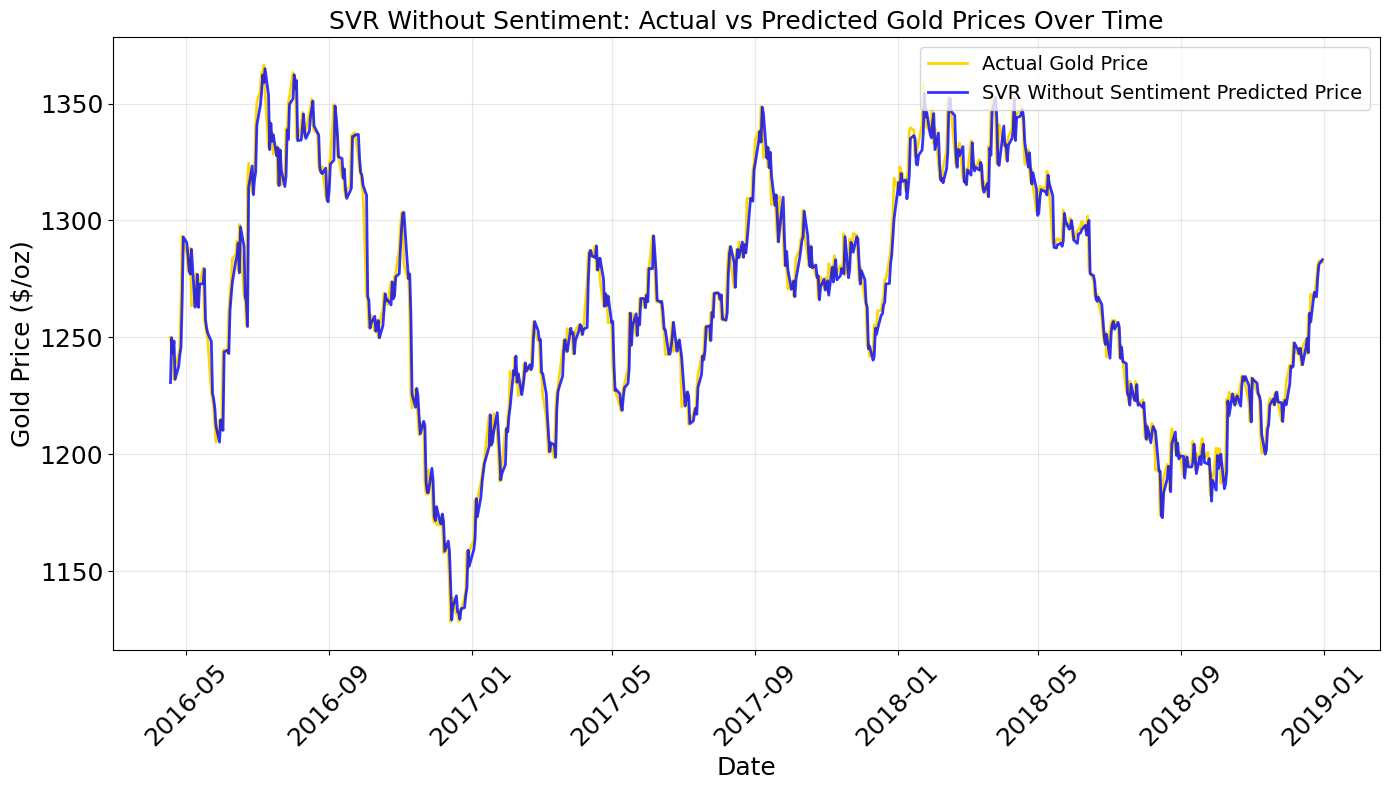


2. SVR With Sentiment (All Features)


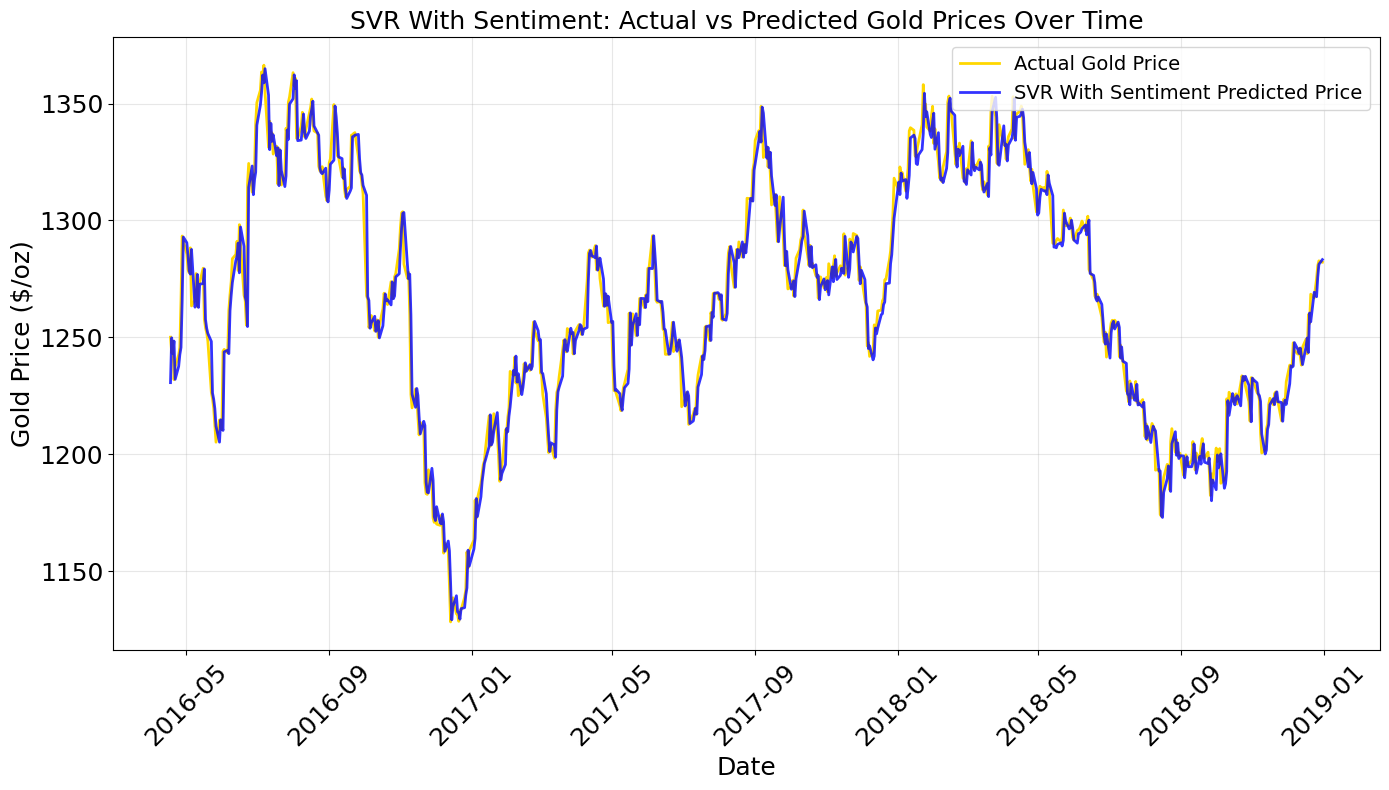


CNN-LSTM Model Comparisons

3. CNN-LSTM Without Sentiment (Macro Features)



4. CNN-LSTM With Sentiment (All Features)


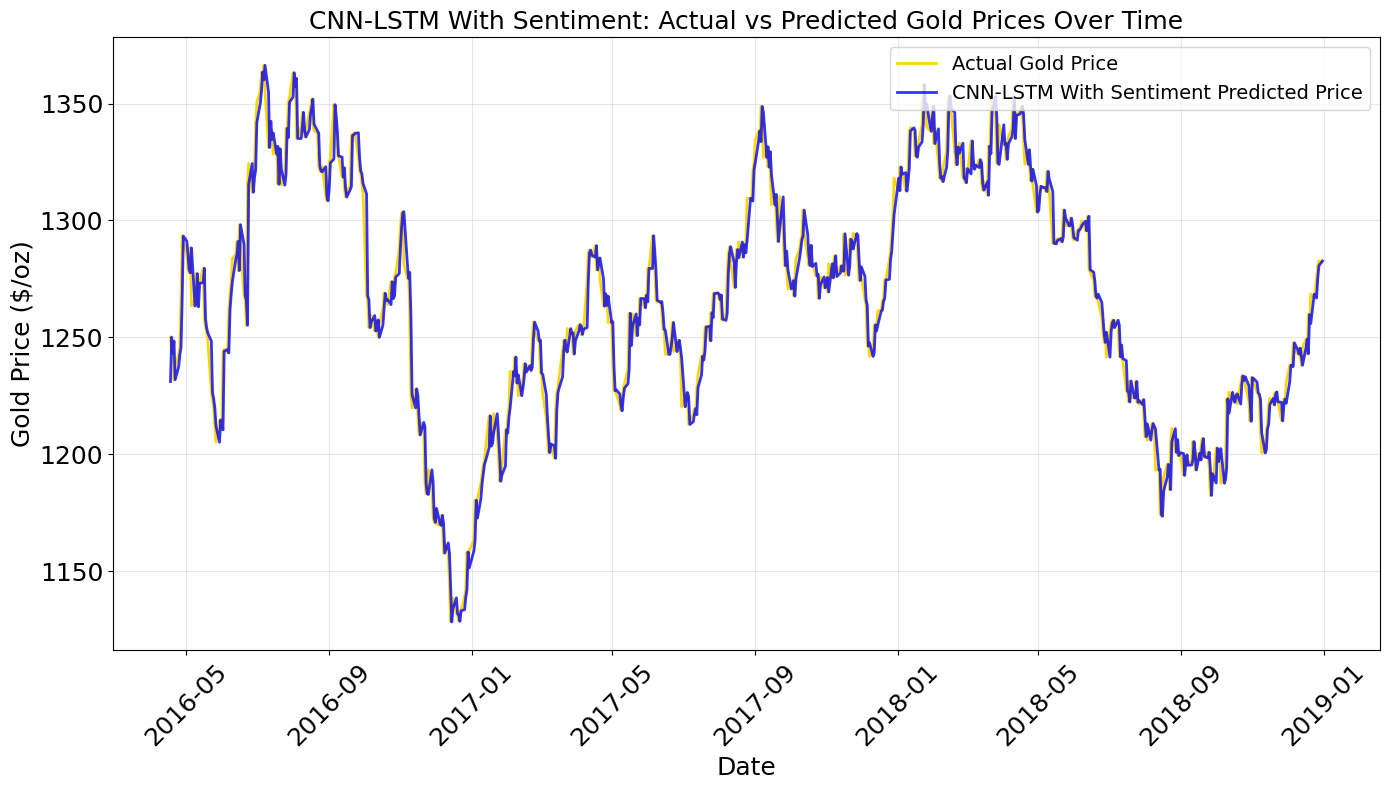


TabNet Model Comparisons

5. TabNet Without Sentiment (Macro Features)


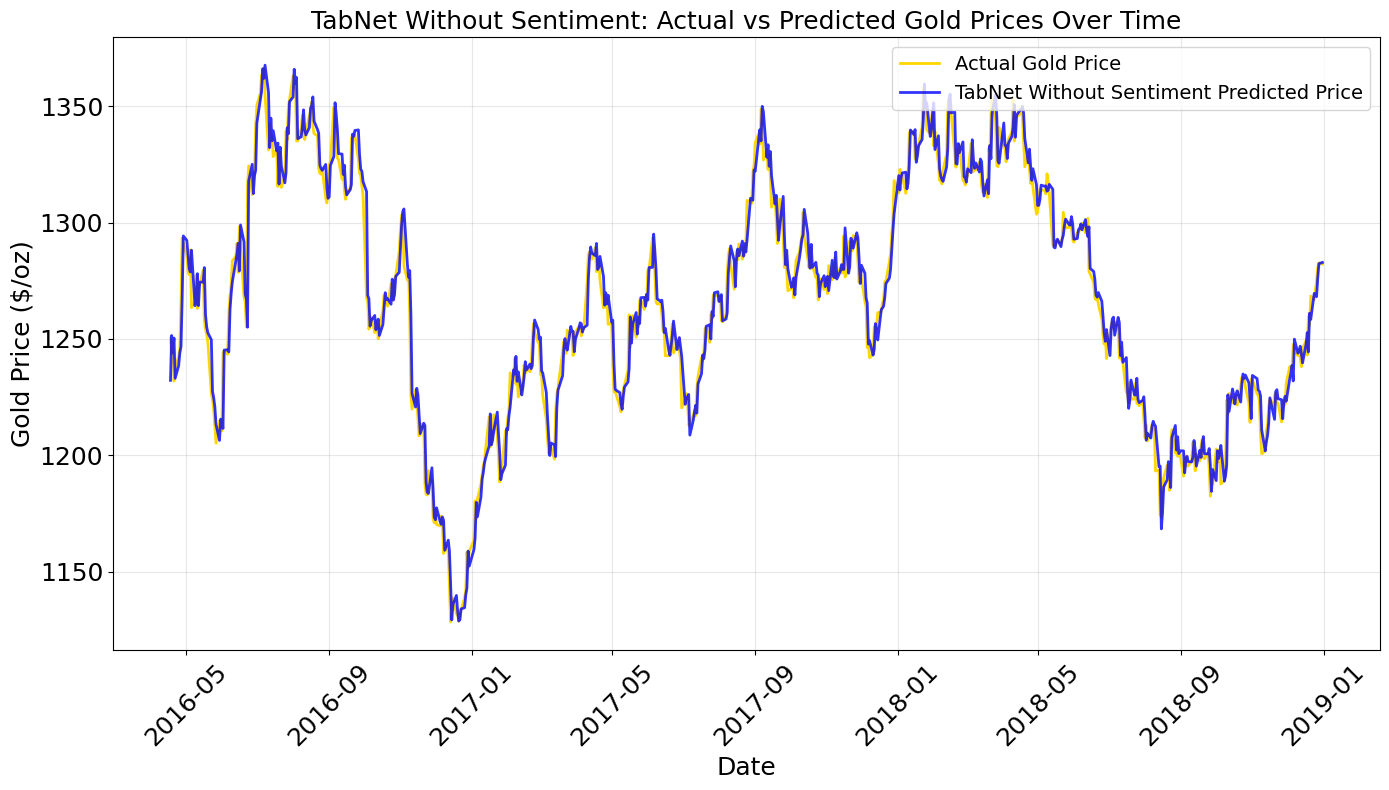


6. TabNet With Sentiment (All Features)


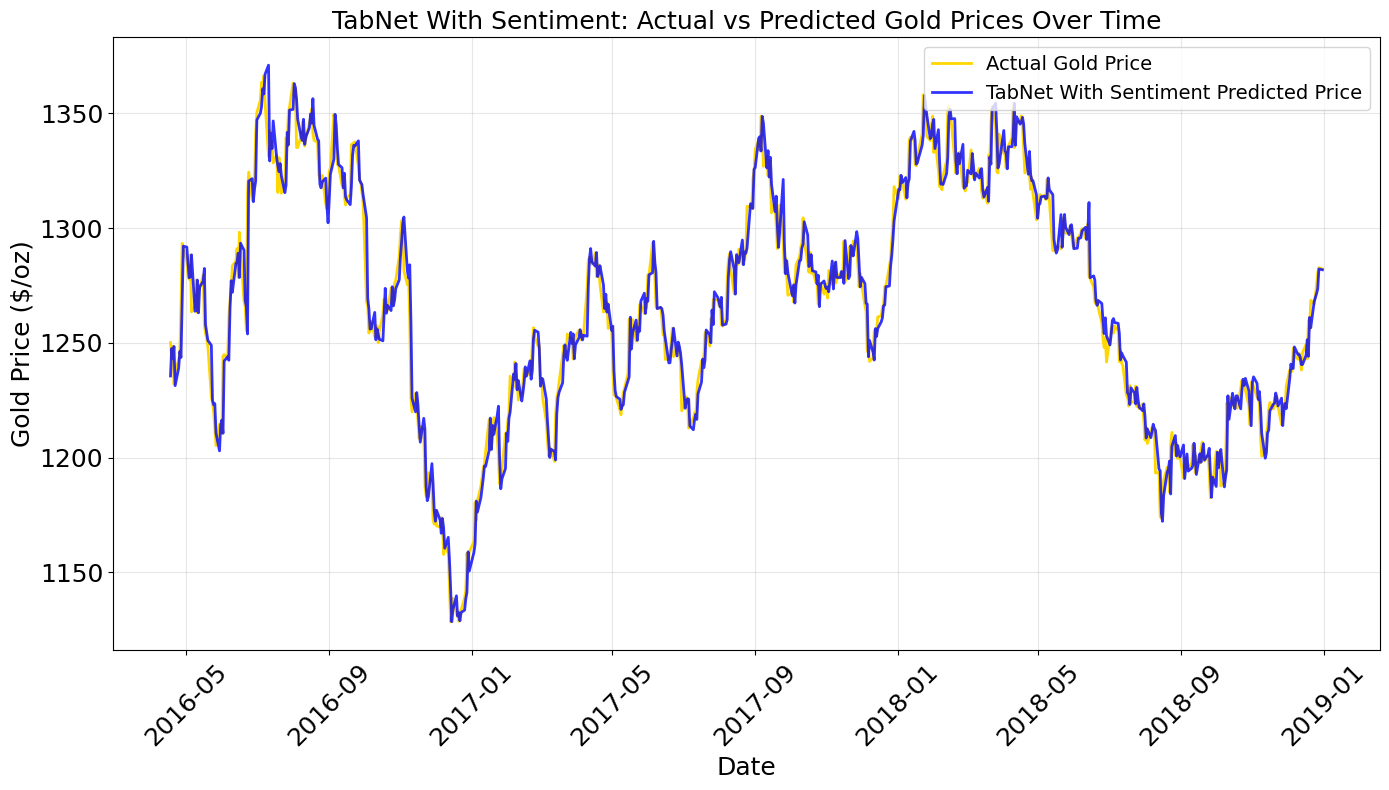


TFT Model Comparisons

7. TFT Without Sentiment (Macro Features)



8. TFT With Sentiment (All Features)


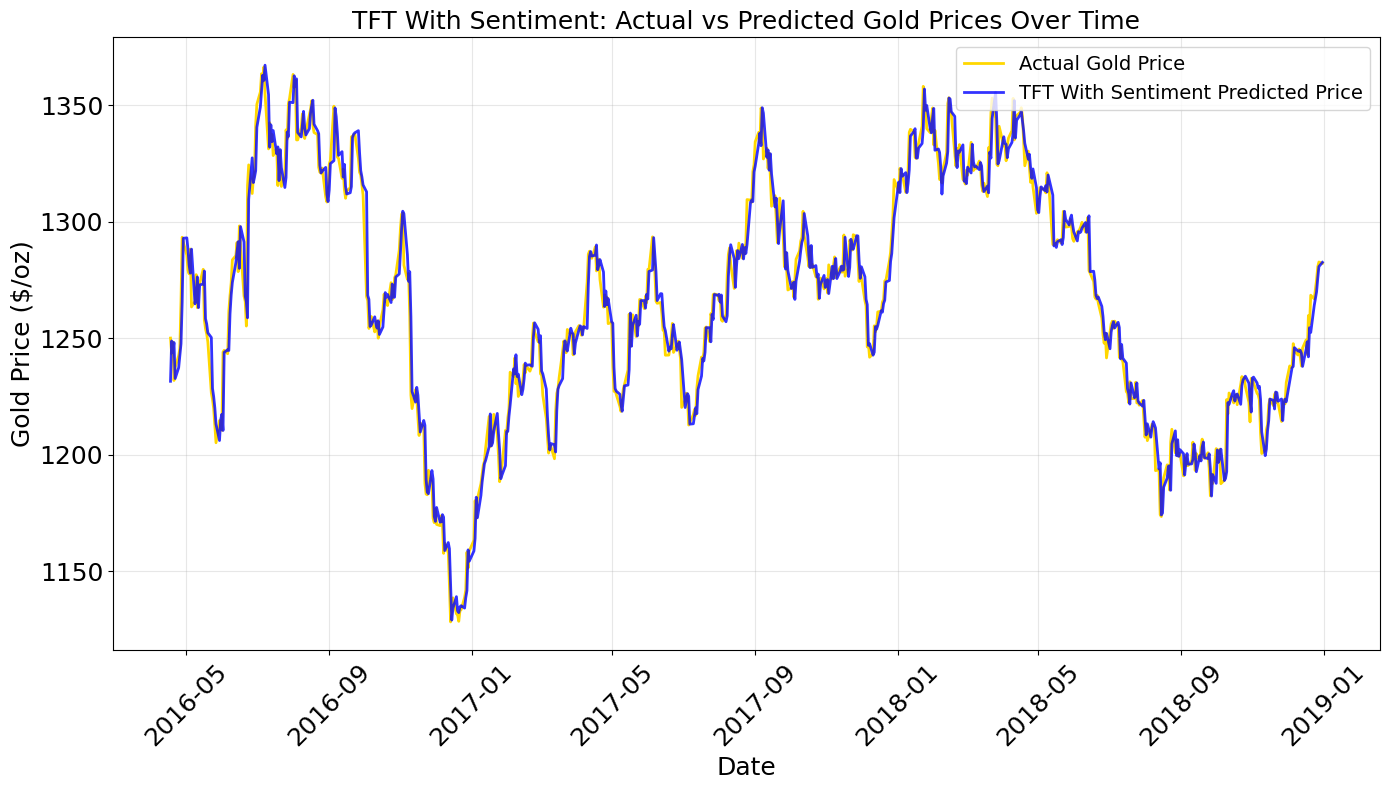

In [ ]:
# Function to create comparison plot
def plot_actual_vs_predicted(gold_prices_df, date_col, actual_col, predicted_col, model_name, title_prefix):
    plt.figure(figsize=(14, 8))

    # Plot actual gold prices
    plt.plot(gold_prices_df[date_col],
             gold_prices_df[actual_col],
             label='Actual Gold Price',
             color='gold',
             linewidth=2)

    # Plot predicted gold prices
    plt.plot(gold_prices_df[date_col],
             gold_prices_df[predicted_col],
             label=f'{model_name} Predicted Price',
             color='blue',
             linewidth=2,
             alpha=0.8)

    # Add labels and title - VERGROTE TEKST EN USD VERVANGEN DOOR $
    plt.xlabel('Date', fontsize=18)  # Vergroot naar 18
    plt.ylabel('Gold Price ($/oz)', fontsize=18)  # Vervangen USD door $ en vergroot naar 18
    plt.title(f'{title_prefix}: Actual vs Predicted Gold Prices Over Time', fontsize=18)  # Vergroot naar 18

    # Add legend with larger font - deze blijft op 14
    plt.legend(loc='upper right', fontsize=14)

    # Add grid
    plt.grid(True, alpha=0.3)

    # Format x-axis for better date display and larger tick labels
    plt.xticks(rotation=45, fontsize=18)  # Vergroot naar 18
    plt.yticks(fontsize=18)  # Vergroot naar 18

    # Tight layout to prevent label cutoff
    plt.tight_layout()
    plt.show()

#===============================================================================
# SVR MODELS
#===============================================================================
print("="*50)
print("SVR Model Comparisons")
print("="*50)

print("\n1. SVR Without Sentiment (Macro Features)")
plot_actual_vs_predicted(gold_prices_svr_macro,
                        'Date',
                        'gold_price_lag',
                        'gold_price_prediction_svr_macro',
                        'SVR Without Sentiment',
                        'SVR Without Sentiment')

print("\n2. SVR With Sentiment (All Features)")
plot_actual_vs_predicted(gold_prices_svr_all,
                        'Date',
                        'gold_price_lag',
                        'gold_price_prediction_svr_all',
                        'SVR With Sentiment',
                        'SVR With Sentiment')

#===============================================================================
# CNN-LSTM MODELS
#===============================================================================
print("\n" + "="*50)
print("CNN-LSTM Model Comparisons")
print("="*50)

print("\n3. CNN-LSTM Without Sentiment (Macro Features)")
plot_actual_vs_predicted(gold_prices_cnn_lstm_macro,
                        'Date',
                        'gold_price_lag',
                        'gold_price_prediction_cnn_lstm_macro',
                        'CNN-LSTM Without Sentiment',
                        'CNN-LSTM Without Sentiment')

print("\n4. CNN-LSTM With Sentiment (All Features)")
plot_actual_vs_predicted(gold_prices_cnn_lstm_all,
                        'Date',
                        'gold_price_lag',
                        'gold_price_prediction_cnn_lstm_all',
                        'CNN-LSTM With Sentiment',
                        'CNN-LSTM With Sentiment')

#===============================================================================
# TABNET MODELS
#===============================================================================
print("\n" + "="*50)
print("TabNet Model Comparisons")
print("="*50)

print("\n5. TabNet Without Sentiment (Macro Features)")
plot_actual_vs_predicted(gold_prices_tabnet_macro,
                        'Date',
                        'gold_price_lag',
                        'gold_price_prediction_tabnet_macro',
                        'TabNet Without Sentiment',
                        'TabNet Without Sentiment')

print("\n6. TabNet With Sentiment (All Features)")
plot_actual_vs_predicted(gold_prices_tabnet_all,
                        'Date',
                        'gold_price_lag',
                        'gold_price_prediction_tabnet_all',
                        'TabNet With Sentiment',
                        'TabNet With Sentiment')

#===============================================================================
# TFT MODELS - Update these to use the correct column names
#===============================================================================
print("\n" + "="*50)
print("TFT Model Comparisons")
print("="*50)

print("\n7. TFT Without Sentiment (Macro Features)")
plot_actual_vs_predicted(gold_prices_tft_macro,
                        'Date',
                        'gold_price_lag_tft_macro',  # Updated column name
                        'gold_price_pred_tft_macro',
                        'TFT Without Sentiment',
                        'TFT Without Sentiment')

print("\n8. TFT With Sentiment (All Features)")
plot_actual_vs_predicted(gold_prices_tft_all,
                        'Date',
                        'gold_price_lag_tft_all',  # Updated column name
                        'gold_price_pred_tft_all',
                        'TFT With Sentiment',
                        'TFT With Sentiment')